In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The objective of this notebook is to perform ANOVA test on different features to validate the statistical findings

In [ ]:
import os
os.chdir("/content/drive/My Drive/PSU/text_variation_and_chess/ghostbuster_data")
!pwd

/content/drive/My Drive/PSU/text_variation_and_chess/ghostbuster_data


In [ ]:
from glob import glob
import ast
import shutil
import glob
import scipy.stats as stats
import json
import math
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from statistics import stdev
import networkx as nx
import pandas as pd
import codecs
import requests
from bs4 import BeautifulSoup
import re
import pickle
from tqdm import tqdm
tqdm.pandas()
import random
from sklearn.feature_extraction.text import TfidfVectorizer
import csv
from sklearn.metrics import classification_report, precision_score,recall_score
from sklearn.model_selection import train_test_split
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import warnings
import email # for handling email data format

# Ignore all warnings
warnings.filterwarnings('ignore')

In [ ]:
!ls

 backup				     reuter_feature_list1.csv
 gemini_split_essay.csv		     reuter_feature_list.csv
 gemini_split_reuter_data.csv	     reuter_llama_generated_articles.csv
 gemini_split_reuter_original.csv    reuter_llm_data.csv
 Ghostbuster_data_mapping.ipynb      reuter_mistral_generated_articles.csv
 ghostbuster-data-master	     reuter_prompts.csv
 ghostbuster-data-master.zip	    'Reuter similarity analysis.ipynb'
 input.csv			     Reuter_statistical_test.ipynb
 reuter_embed_list1.csv		     reuter_uid_scores1.csv
 reuter_embed_list.csv		     reuter_uid_scores.csv
'Reuter feature extractions.ipynb'


# Features statistical significance tests

## Initialization

In [ ]:
from scipy.spatial.distance import jensenshannon
from scipy.stats import wasserstein_distance
import scipy.stats as stats
from statsmodels.formula.api import ols
import statsmodels.api as sm
from scipy.stats import f_oneway

In [ ]:
def calculate_distance(vector1, vector2, method = 'diff'):
  if method == 'diff':
    return np.abs(vector1-vector2)
  if method =='jsd':
    # print(vector1)
    # print(vector2)
    # print(jensenshannon(vector1, vector2))
    value = jensenshannon(vector1, vector2, base=2)
    if math.isnan(value): value = 0
    return value
  if method == 'cosine':
    return cosine_distance(vector1, vector2)



In [ ]:
def plot_box_plot(I, B, C, feature_name):
  data = [I, B, C]

  # Define colors for each box
  box_colors = ['blue', 'red', 'green']

  # Create a horizontal box plot
  fig, ax = plt.subplots()
  box_plot = ax.boxplot(data, labels=['Introduction', 'Body', 'Conclusion'], vert=False, patch_artist=True)

  # Customize colors for each box
  for patch, color in zip(box_plot['boxes'], box_colors):
      patch.set_facecolor(color)

  # Add a title and labels
  ax.set_title(feature_name,fontsize=16)
  ax.set_xlabel("Feature space distance",fontsize=15)

In [ ]:
def test_one_way_anova(I, B, C, feature_name):
  f_value, p_value = f_oneway(I, B, C)
  print("f_value: ", f_value)
  print("p_value: ", p_value)

  print("I>B: ",stats.wilcoxon(I, B, alternative='greater'))
  print("I>C: ",stats.wilcoxon(I, C, alternative='greater'))
  print("B>C: ",stats.wilcoxon(B, C, alternative='greater'))
  print('-'*50)
  print("B>I: ",stats.wilcoxon(B, I, alternative='greater'))
  print("C>I: ",stats.wilcoxon(C, I, alternative='greater'))
  print("C>B: ",stats.wilcoxon(C, B, alternative='greater'))

  plot_box_plot(I, B, C, feature_name)


In [ ]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

def test_two_way_anova(H_I_B, H_I_C, H_B_C, AI_I_B, AI_I_C, AI_B_C, feature_name):
    # Combine data from both sources
    data = {
        'Source': ['Human'] * (len(H_I_B) + len(H_I_C) + len(H_B_C)) +
                  ['AI'] * (len(AI_I_B) + len(AI_I_C) + len(AI_B_C)),
        'Segment': (['I-B'] * len(H_I_B) +
                    ['I-C'] * len(H_I_C) +
                    ['B-C'] * len(H_B_C) +
                    ['I-B'] * len(AI_I_B) +
                    ['I-C'] * len(AI_I_C) +
                    ['B-C'] * len(AI_B_C)),
        'score': H_I_B + H_I_C + H_B_C + AI_I_B + AI_I_C + AI_B_C
    }

    # Convert data to DataFrame
    adf = pd.DataFrame(data)
    # Explicitly convert 'Segment' and 'Source' to categorical
    adf['Segment'] = pd.Categorical(adf['Segment'])  # Convert 'Segment' to categorical
    adf['Source'] = pd.Categorical(adf['Source'])  # Convert 'Source' to categorical
    # print(adf)
    # Fit the two-way ANOVA model
    model = ols('score ~ Segment * Source', data=adf).fit() # Remove C() as columns are already categorical

    # Print the ANOVA table
    anova_table = sm.stats.anova_lm(model, typ=2)
    print(anova_table)

    print("(H>A) I-B: ",stats.wilcoxon(H_I_B, AI_I_B, alternative='greater'))
    print("(H>A) I-C: ",stats.wilcoxon(H_I_C, AI_I_C, alternative='greater'))
    print("(H>A) B-C: ",stats.wilcoxon(H_B_C, AI_B_C, alternative='greater'))
    print('-'*50)
    print("(A>H) I-B: ",stats.wilcoxon(AI_I_B, H_I_B, alternative='greater'))
    print("(A>H) I-C: ",stats.wilcoxon(AI_I_C, H_I_C, alternative='greater'))
    print("(A>H) B-C: ",stats.wilcoxon(AI_B_C, H_B_C, alternative='greater'))


    data = [H_I_B, AI_I_B, H_I_C, AI_I_C, H_B_C, AI_B_C]

    # Define colors for each box
    plt.boxplot(data, labels=['I-B(Human)','I-B(AI)', 'I-C(Human)', 'I-C(AI)', 'B-C(Human)','B-C(AI)', ])
    plt.title(feature_name,fontsize=16)
    plt.ylabel("Feature space distance",fontsize=15)
    plt.show()

In [ ]:
import numpy as np

def cosine_distance(a, b):
    """Calculates the cosine distance between two vectors.

    Args:
        a (list or numpy array): The first vector.
        b (list or numpy array): The second vector.

    Returns:
        float: The cosine distance between the two vectors.
    """

    a = np.array(a)
    b = np.array(b)

    dot_product = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    # print(norm_a, norm_b)
    cosine_similarity = dot_product / (norm_a * norm_b)
    cosine_distance = 1 - cosine_similarity

    return cosine_distance

## Reuter

### VOC_richness

In [ ]:
orig_df =  pd.read_csv('reuter_feature_list.csv')
col_name = 'brunet_idx'
intro_col = 'intro_' + col_name
body_col = 'body_' + col_name
conclusion_col = 'conclusion_' + col_name
mask = (orig_df[intro_col] != 0) & (orig_df[body_col] != 0) & (orig_df[conclusion_col] != 0) & (orig_df[intro_col] != 1) & (orig_df[body_col] != 1) & (orig_df[conclusion_col] != 1)
df = orig_df[mask]

In [ ]:
h_intro_emd = []
h_body_emd = []
h_conclusion_emd = []
ai_intro_emd = []
ai_body_emd = []
ai_conclusion_emd = []

human_rows = df[df['source'] == 'human']

for i, row in human_rows.iterrows():
  try:
    # Get all rows with the current key but a different source
    key = row['key']
    other_sources = df[(df['key'] == key) & (df['source'] != 'human')]
    # print(other_sources.shape)
    # Sample a row from the other_sources DataFrame
    sampled_row = other_sources.sample(n=1, random_state=42).iloc[0]
    h_intro_emd.append(row[intro_col])
    h_body_emd.append(row[body_col])
    h_conclusion_emd.append(row[conclusion_col])

    ai_intro_emd.append(sampled_row[intro_col])
    ai_body_emd.append(sampled_row[body_col])
    ai_conclusion_emd.append(sampled_row[conclusion_col])
    # I.append(np.abs(row[intro_col]) - sampled_row[intro_col])
    # B.append(np.abs(row[body_col]) - sampled_row[body_col])
    # C.append(np.abs(row[conclusion_col]) - sampled_row[conclusion_col])
  except:
    continue

I  = []
B = []
C = []
for i in range(len(h_intro_emd)):
  I.append(calculate_distance(h_intro_emd[i], ai_intro_emd[i]))
  B.append(calculate_distance(h_body_emd[i], ai_body_emd[i]))
  C.append(calculate_distance(h_conclusion_emd[i], ai_conclusion_emd[i]))

H_I_B, H_I_C, H_B_C, AI_I_B, AI_I_C, AI_B_C = [], [], [], [], [], []
for i in range(len(h_intro_emd)):
  H_I_B.append(calculate_distance(h_intro_emd[i], h_body_emd[i]))
  H_I_C.append(calculate_distance(h_intro_emd[i], h_conclusion_emd[i]))
  H_B_C.append(calculate_distance(h_body_emd[i], h_conclusion_emd[i]))
  AI_I_B.append(calculate_distance(ai_intro_emd[i], ai_body_emd[i]))
  AI_I_C.append(calculate_distance(ai_intro_emd[i], ai_conclusion_emd[i]))
  AI_B_C.append(calculate_distance(ai_body_emd[i], ai_conclusion_emd[i]))


f_value:  405.8491277330761
p_value:  3.5256242445760676e-155
I>B:  WilcoxonResult(statistic=34745.0, pvalue=1.0)
I>C:  WilcoxonResult(statistic=70258.0, pvalue=1.0)
B>C:  WilcoxonResult(statistic=308793.0, pvalue=1.966216765893457e-34)
--------------------------------------------------
B>I:  WilcoxonResult(statistic=387076.0, pvalue=7.901512000019453e-107)
C>I:  WilcoxonResult(statistic=351563.0, pvalue=6.762740684397251e-69)
C>B:  WilcoxonResult(statistic=113028.0, pvalue=1.0)


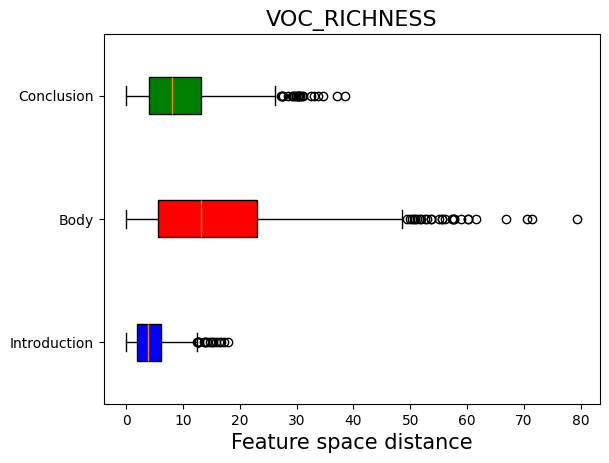

In [ ]:
test_one_way_anova(I, B, C, "VOC_RICHNESS")

                       sum_sq      df            F         PR(>F)
Segment         328461.182187     2.0  1145.098486   0.000000e+00
Source           74329.512143     1.0   518.262835  1.031293e-109
Segment:Source   47917.960543     2.0   167.054091   3.688430e-71
Residual        789099.560754  5502.0          NaN            NaN
(H>A) I-B:  WilcoxonResult(statistic=327467.0, pvalue=5.657394092078797e-48)
(H>A) I-C:  WilcoxonResult(statistic=184724.0, pvalue=0.9994404545448988)
(H>A) B-C:  WilcoxonResult(statistic=344203.0, pvalue=4.299895064813347e-62)
--------------------------------------------------
(A>H) I-B:  WilcoxonResult(statistic=94354.0, pvalue=1.0)
(A>H) I-C:  WilcoxonResult(statistic=237097.0, pvalue=0.0005595454551011274)
(A>H) B-C:  WilcoxonResult(statistic=77618.0, pvalue=1.0)


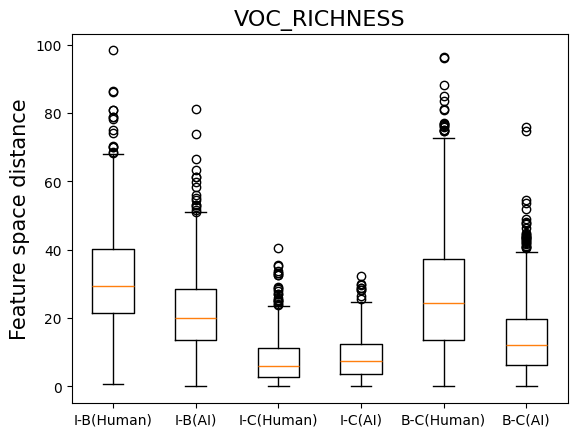

In [ ]:
test_two_way_anova(H_I_B, H_I_C, H_B_C, AI_I_B, AI_I_C, AI_B_C, "VOC_RICHNESS")

f_value:  255.97182216945635
p_value:  1.120313214800772e-102
I>B:  WilcoxonResult(statistic=94398.0, pvalue=1.0)
I>C:  WilcoxonResult(statistic=274479.0, pvalue=1.2799163316463367e-15)
B>C:  WilcoxonResult(statistic=342348.0, pvalue=1.9537707674096604e-60)
--------------------------------------------------
B>I:  WilcoxonResult(statistic=327423.0, pvalue=6.127231597859021e-48)
C>I:  WilcoxonResult(statistic=147342.0, pvalue=0.9999999999999987)
C>B:  WilcoxonResult(statistic=79473.0, pvalue=1.0)


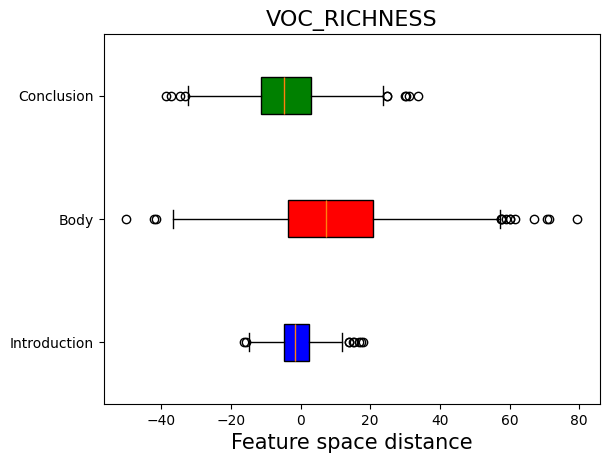

In [ ]:
test_one_way_anova(I, B, C, "VOC_RICHNESS")

                      sum_sq      df            F         PR(>F)
Segment         2.037657e+06     2.0  6502.057712   0.000000e+00
Source          5.329173e+03     1.0    34.010235   5.794506e-09
Segment:Source  1.239612e+05     2.0   395.553735  3.119671e-161
Residual        8.621261e+05  5502.0          NaN            NaN
(H>A) I-B:  WilcoxonResult(statistic=94398.0, pvalue=1.0)
(H>A) I-C:  WilcoxonResult(statistic=274479.0, pvalue=1.2799163316463367e-15)
(H>A) B-C:  WilcoxonResult(statistic=342348.0, pvalue=1.9537707674096604e-60)
--------------------------------------------------
(A>H) I-B:  WilcoxonResult(statistic=327423.0, pvalue=6.127231597859021e-48)
(A>H) I-C:  WilcoxonResult(statistic=147342.0, pvalue=0.9999999999999987)
(A>H) B-C:  WilcoxonResult(statistic=79473.0, pvalue=1.0)


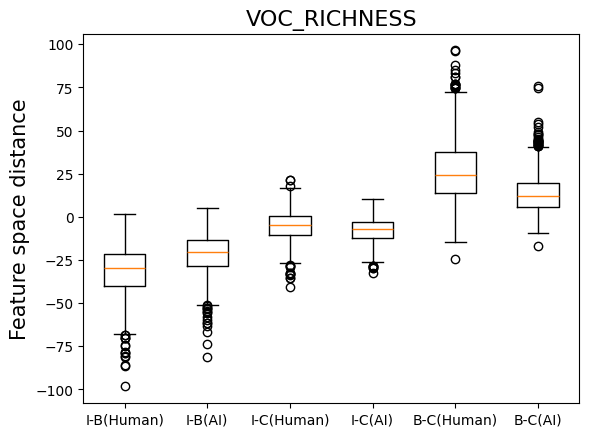

In [ ]:
test_two_way_anova(H_I_B, H_I_C, H_B_C, AI_I_B, AI_I_C, AI_B_C, "VOC_RICHNESS")

### Readability score

In [ ]:
orig_df =  pd.read_csv('reuter_feature_list.csv')
score_name = 'flesch_reading_ease'
col_name = 'reading_scores'
intro_col = 'intro_' + col_name
body_col = 'body_' + col_name
conclusion_col = 'conclusion_' + col_name
mask = (orig_df['intro_reading_scores'] != '{}') & (orig_df['body_reading_scores'] != '{}') & (orig_df['conclusion_reading_scores'] != '{}')
df = orig_df[mask]

In [ ]:
intro_col

'intro_reading_scores'

In [ ]:
df.shape

(5643, 60)

In [ ]:
h_intro_emd = []
h_body_emd = []
h_conclusion_emd = []
ai_intro_emd = []
ai_body_emd = []
ai_conclusion_emd = []

human_rows = df[df['source'] == 'human']

for i, row in human_rows.iterrows():
  try:
    # Get all rows with the current key but a different source
    key = row['key']
    other_sources = df[(df['key'] == key) & (df['source'] != 'human')]
    # print(other_sources.shape)
    # Sample a row from the other_sources DataFrame
    sampled_row = other_sources.sample(n=1, random_state=42).iloc[0]
    h_intro_emd.append(ast.literal_eval(row[intro_col])[score_name])
    h_body_emd.append(ast.literal_eval(row[body_col])[score_name])
    h_conclusion_emd.append(ast.literal_eval(row[conclusion_col])[score_name])

    ai_intro_emd.append(ast.literal_eval(sampled_row[intro_col])[score_name])
    ai_body_emd.append(ast.literal_eval(sampled_row[body_col])[score_name])
    ai_conclusion_emd.append(ast.literal_eval(sampled_row[conclusion_col])[score_name])
    # I.append(np.abs(row[intro_col]) - sampled_row[intro_col])
    # B.append(np.abs(row[body_col]) - sampled_row[body_col])
    # C.append(np.abs(row[conclusion_col]) - sampled_row[conclusion_col])
  except:
    continue

I  = []
B = []
C = []
for i in range(len(h_intro_emd)):
  I.append(calculate_distance(h_intro_emd[i], ai_intro_emd[i]))
  B.append(calculate_distance(h_body_emd[i], ai_body_emd[i]))
  C.append(calculate_distance(h_conclusion_emd[i], ai_conclusion_emd[i]))

H_I_B, H_I_C, H_B_C, AI_I_B, AI_I_C, AI_B_C = [], [], [], [], [], []
for i in range(len(h_intro_emd)):
  H_I_B.append(calculate_distance(h_intro_emd[i], h_body_emd[i]))
  H_I_C.append(calculate_distance(h_intro_emd[i], h_conclusion_emd[i]))
  H_B_C.append(calculate_distance(h_body_emd[i], h_conclusion_emd[i]))
  AI_I_B.append(calculate_distance(ai_intro_emd[i], ai_body_emd[i]))
  AI_I_C.append(calculate_distance(ai_intro_emd[i], ai_conclusion_emd[i]))
  AI_B_C.append(calculate_distance(ai_body_emd[i], ai_conclusion_emd[i]))


f_value:  41.88560702774617
p_value:  1.1902939066086976e-18
I>B:  WilcoxonResult(statistic=255619.5, pvalue=5.5355546123420904e-06)
I>C:  WilcoxonResult(statistic=187749.5, pvalue=0.9999301008004141)
B>C:  WilcoxonResult(statistic=150769.5, pvalue=0.9999999999999999)
--------------------------------------------------
B>I:  WilcoxonResult(statistic=182896.5, pvalue=0.9999944644453876)
C>I:  WilcoxonResult(statistic=250766.5, pvalue=6.989919958584835e-05)
C>B:  WilcoxonResult(statistic=287746.5, pvalue=6.241774575722486e-17)


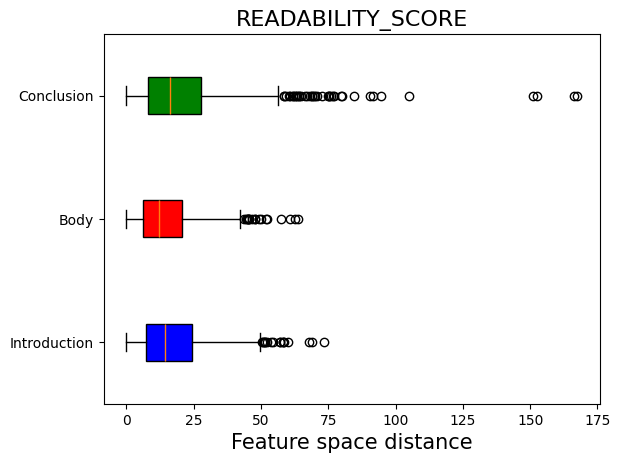

In [ ]:
test_one_way_anova(I, B, C, "READABILITY_SCORE")

                       sum_sq      df           F        PR(>F)
Segment          11282.134935     2.0   35.035711  7.558340e-16
Source           18953.886846     1.0  117.719368  3.710759e-27
Segment:Source    3067.499200     2.0    9.525858  7.412784e-05
Residual        903260.925936  5610.0         NaN           NaN
(H>A) I-B:  WilcoxonResult(statistic=247797.0, pvalue=0.000280716619854453)
(H>A) I-C:  WilcoxonResult(statistic=270857.0, pvalue=1.4541959427709277e-10)
(H>A) B-C:  WilcoxonResult(statistic=275523.0, pvalue=5.1978249946318355e-12)
--------------------------------------------------
(A>H) I-B:  WilcoxonResult(statistic=190719.0, pvalue=0.9997192833801456)
(A>H) I-C:  WilcoxonResult(statistic=166723.0, pvalue=0.9999999998545804)
(A>H) B-C:  WilcoxonResult(statistic=162993.0, pvalue=0.9999999999948022)


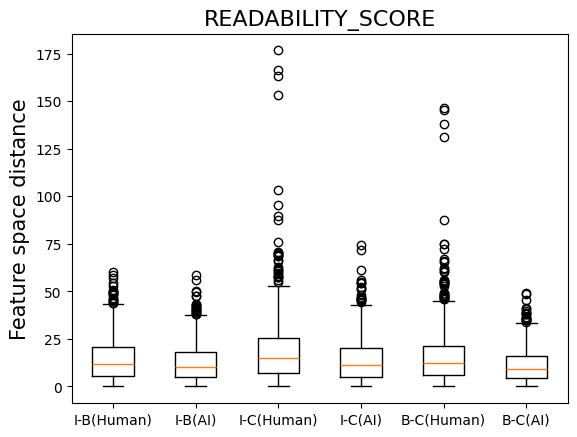

In [ ]:
test_two_way_anova(H_I_B, H_I_C, H_B_C, AI_I_B, AI_I_C, AI_B_C, "READABILITY_SCORE")

### AVG sentiment score

In [ ]:
orig_df = pd.read_csv('reuter_feature_list.csv')
mask = (orig_df['intro_polarity_scores'] != '[]') & (orig_df['body_polarity_scores'] != '[]') & (orig_df['conclusion_polarity_scores'] != '[]')
df = orig_df[mask]

In [ ]:
def get_mean_from_column(L):
  means = []
  for s in L:
    d = ast.literal_eval(s)
    means.append(np.average(d))
  return means
intro_col = 'intro_polarity_scores'
body_col = 'body_polarity_scores'
conclusion_col = 'conclusion_polarity_scores'

In [ ]:
h_intro_emd = []
h_body_emd = []
h_conclusion_emd = []
ai_intro_emd = []
ai_body_emd = []
ai_conclusion_emd = []

human_rows = df[df['source'] == 'human']

for i, row in human_rows.iterrows():
  try:
    # Get all rows with the current key but a different source
    key = row['key']
    other_sources = df[(df['key'] == key) & (df['source'] != 'human')]
    # print(other_sources.shape)
    # Sample a row from the other_sources DataFrame
    sampled_row = other_sources.sample(n=1, random_state=42).iloc[0]
    h_intro_emd.append(np.average(ast.literal_eval(row[intro_col])))
    h_body_emd.append(np.average(ast.literal_eval(row[body_col])))
    h_conclusion_emd.append(np.average(ast.literal_eval(row[conclusion_col])))

    ai_intro_emd.append(np.average(ast.literal_eval(sampled_row[intro_col])))
    ai_body_emd.append(np.average(ast.literal_eval(sampled_row[body_col])))
    ai_conclusion_emd.append(np.average(ast.literal_eval(sampled_row[conclusion_col])))
    # I.append(np.abs(row[intro_col]) - sampled_row[intro_col])
    # B.append(np.abs(row[body_col]) - sampled_row[body_col])
    # C.append(np.abs(row[conclusion_col]) - sampled_row[conclusion_col])
  except:
    continue

I  = []
B = []
C = []
for i in range(len(h_intro_emd)):
  I.append(calculate_distance(h_intro_emd[i], ai_intro_emd[i]))
  B.append(calculate_distance(h_body_emd[i], ai_body_emd[i]))
  C.append(calculate_distance(h_conclusion_emd[i], ai_conclusion_emd[i]))

H_I_B, H_I_C, H_B_C, AI_I_B, AI_I_C, AI_B_C = [], [], [], [], [], []
for i in range(len(h_intro_emd)):
  H_I_B.append(calculate_distance(h_intro_emd[i], h_body_emd[i]))
  H_I_C.append(calculate_distance(h_intro_emd[i], h_conclusion_emd[i]))
  H_B_C.append(calculate_distance(h_body_emd[i], h_conclusion_emd[i]))
  AI_I_B.append(calculate_distance(ai_intro_emd[i], ai_body_emd[i]))
  AI_I_C.append(calculate_distance(ai_intro_emd[i], ai_conclusion_emd[i]))
  AI_B_C.append(calculate_distance(ai_body_emd[i], ai_conclusion_emd[i]))


f_value:  81.2789662949568
p_value:  4.852411070315716e-35
I>B:  WilcoxonResult(statistic=309334.0, pvalue=6.592948735350534e-28)
I>C:  WilcoxonResult(statistic=230460.0, pvalue=0.049527863955775485)
B>C:  WilcoxonResult(statistic=132986.0, pvalue=1.0)
--------------------------------------------------
B>I:  WilcoxonResult(statistic=129182.0, pvalue=1.0)
C>I:  WilcoxonResult(statistic=203386.0, pvalue=0.9504721360442245)
C>B:  WilcoxonResult(statistic=305530.0, pvalue=9.241789075399683e-26)


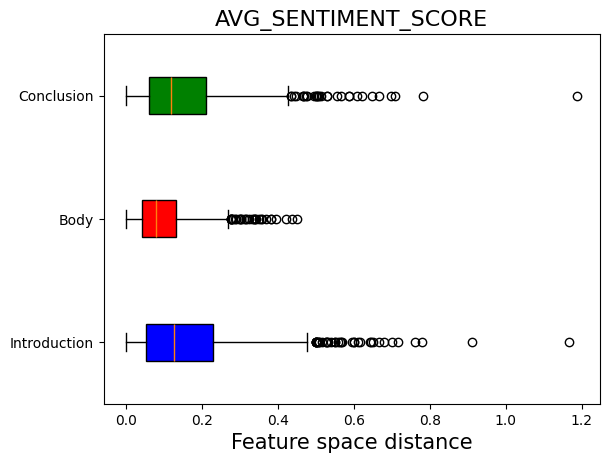

In [ ]:
test_one_way_anova(I, B, C, "AVG_SENTIMENT_SCORE")

                   sum_sq      df          F        PR(>F)
Segment          1.081332     2.0  39.188419  1.254521e-17
Source           0.005329     1.0   0.386271  5.342914e-01
Segment:Source   0.003736     2.0   0.135398  8.733710e-01
Residual        77.398804  5610.0        NaN           NaN
(H>A) I-B:  WilcoxonResult(statistic=225409.0, pvalue=0.22859273998751822)
(H>A) I-C:  WilcoxonResult(statistic=217386.5, pvalue=0.47748119238921355)
(H>A) B-C:  WilcoxonResult(statistic=213309.0, pvalue=0.7639520285077228)
--------------------------------------------------
(A>H) I-B:  WilcoxonResult(statistic=213107.0, pvalue=0.7714072600124817)
(A>H) I-C:  WilcoxonResult(statistic=216459.5, pvalue=0.5225188076107864)
(A>H) B-C:  WilcoxonResult(statistic=225207.0, pvalue=0.2360479714922772)


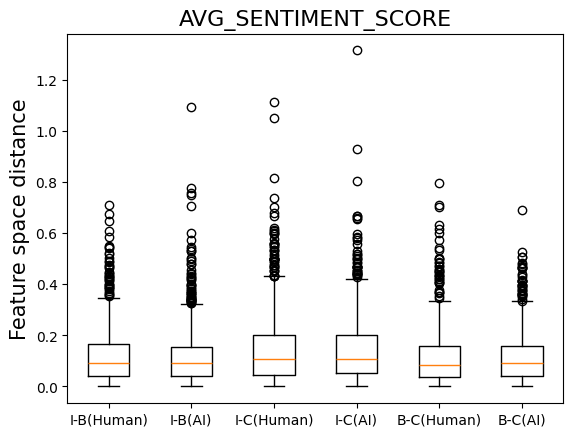

In [ ]:
test_two_way_anova(H_I_B, H_I_C, H_B_C, AI_I_B, AI_I_C, AI_B_C, "AVG_SENTIMENT_SCORE")

### AVG formaility score

In [ ]:
orig_df =  pd.read_csv('reuter_feature_list.csv')
intro_col = 'intro_formality_score'
body_col = 'body_formality_score'
conclusion_col = 'conclusion_formality_score'
mask = (orig_df[intro_col] != '[]') & (orig_df[body_col] != '[]') & (orig_df[conclusion_col] != '[]')
df = orig_df[mask]
df.shape

(5643, 60)

In [ ]:
h_intro_emd = []
h_body_emd = []
h_conclusion_emd = []
ai_intro_emd = []
ai_body_emd = []
ai_conclusion_emd = []

human_rows = df[df['source'] == 'human']

for i, row in human_rows.iterrows():
  try:
    # Get all rows with the current key but a different source
    key = row['key']
    other_sources = df[(df['key'] == key) & (df['source'] != 'human')]
    # print(other_sources.shape)
    # Sample a row from the other_sources DataFrame
    sampled_row = other_sources.sample(n=1, random_state=42).iloc[0]
    h_intro_emd.append(np.average(ast.literal_eval(row[intro_col])))
    h_body_emd.append(np.average(ast.literal_eval(row[body_col])))
    h_conclusion_emd.append(np.average(ast.literal_eval(row[conclusion_col])))

    ai_intro_emd.append(np.average(ast.literal_eval(sampled_row[intro_col])))
    ai_body_emd.append(np.average(ast.literal_eval(sampled_row[body_col])))
    ai_conclusion_emd.append(np.average(ast.literal_eval(sampled_row[conclusion_col])))
    # I.append(np.abs(row[intro_col]) - sampled_row[intro_col])
    # B.append(np.abs(row[body_col]) - sampled_row[body_col])
    # C.append(np.abs(row[conclusion_col]) - sampled_row[conclusion_col])
  except:
    continue

I  = []
B = []
C = []
for i in range(len(h_intro_emd)):
  I.append(calculate_distance(h_intro_emd[i], ai_intro_emd[i]))
  B.append(calculate_distance(h_body_emd[i], ai_body_emd[i]))
  C.append(calculate_distance(h_conclusion_emd[i], ai_conclusion_emd[i]))

H_I_B, H_I_C, H_B_C, AI_I_B, AI_I_C, AI_B_C = [], [], [], [], [], []
for i in range(len(h_intro_emd)):
  H_I_B.append(calculate_distance(h_intro_emd[i], h_body_emd[i]))
  H_I_C.append(calculate_distance(h_intro_emd[i], h_conclusion_emd[i]))
  H_B_C.append(calculate_distance(h_body_emd[i], h_conclusion_emd[i]))
  AI_I_B.append(calculate_distance(ai_intro_emd[i], ai_body_emd[i]))
  AI_I_C.append(calculate_distance(ai_intro_emd[i], ai_conclusion_emd[i]))
  AI_B_C.append(calculate_distance(ai_body_emd[i], ai_conclusion_emd[i]))


f_value:  71.2043217573067
p_value:  6.850924889683968e-31
I>B:  WilcoxonResult(statistic=293456.0, pvalue=1.5024904778570264e-19)
I>C:  WilcoxonResult(statistic=206742.5, pvalue=0.9114508327090655)
B>C:  WilcoxonResult(statistic=132371.5, pvalue=1.0)
--------------------------------------------------
B>I:  WilcoxonResult(statistic=145060.0, pvalue=1.0)
C>I:  WilcoxonResult(statistic=228968.5, pvalue=0.08854916729093454)
C>B:  WilcoxonResult(statistic=306144.5, pvalue=4.2183633920138765e-26)


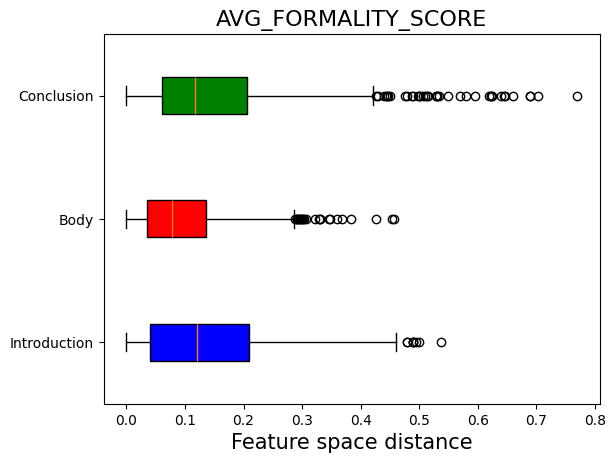

In [ ]:
test_one_way_anova(I, B, C, "AVG_FORMALITY_SCORE")

                   sum_sq      df           F        PR(>F)
Segment          1.610387     2.0   74.809221  8.638914e-33
Source           1.568956     1.0  145.769142  3.746382e-33
Segment:Source   0.293106     2.0   13.615990  1.261701e-06
Residual        60.382061  5610.0         NaN           NaN
(H>A) I-B:  WilcoxonResult(statistic=252750.5, pvalue=1.965578674668295e-05)
(H>A) I-C:  WilcoxonResult(statistic=281569.5, pvalue=1.6763838029257074e-15)
(H>A) B-C:  WilcoxonResult(statistic=273660.5, pvalue=2.4197840494555024e-11)
--------------------------------------------------
(A>H) I-B:  WilcoxonResult(statistic=184829.5, pvalue=0.9999803442132533)
(A>H) I-C:  WilcoxonResult(statistic=152276.5, pvalue=0.9999999999999983)
(A>H) B-C:  WilcoxonResult(statistic=164855.5, pvalue=0.9999999999758021)


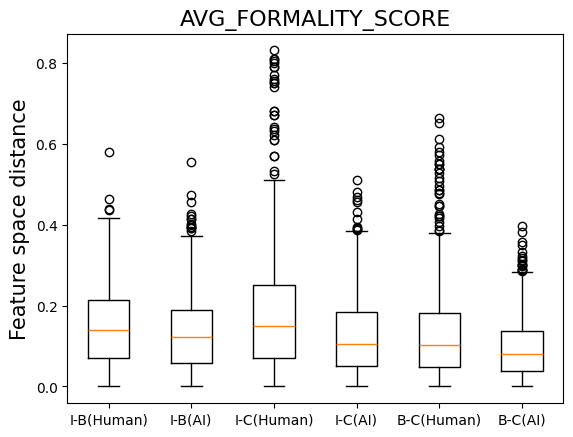

In [ ]:
test_two_way_anova(H_I_B, H_I_C, H_B_C, AI_I_B, AI_I_C, AI_B_C, "AVG_FORMALITY_SCORE")

### AVG surprisal scores

In [ ]:
orig_df = pd.read_csv('reuter_feature_list.csv')
mask = (orig_df['intro_perplexity_scores'] != '[]') & (orig_df['body_perplexity_scores'] != '[]') & (orig_df['conclusion_perplexity_scores'] != '[]') & (orig_df['intro_avg_burstiness_score'] != 0) \
& (orig_df['conclusion_avg_burstiness_score'] != 0)  & (orig_df['intro_avg_burstiness_score'] <2000) & (orig_df['conclusion_avg_burstiness_score'] <2000) & (orig_df['body_avg_burstiness_score'] <2000)
df = orig_df[mask]
df.shape

(1438, 20)

In [ ]:
df.columns

Index(['key', 'source', 'intro_text', 'body_text', 'conclusion_text', 'intro_uid_scores', 'conclusion_uid_scores', 'body_uid_scores', 'intro_perplexity_scores', 'intro_avg_perplexity_score', 'intro_std_perplexity_score', 'intro_avg_burstiness_score', 'conclusion_perplexity_scores', 'conclusion_avg_perplexity_score', 'conclusion_std_perplexity_score', 'conclusion_avg_burstiness_score', 'body_perplexity_scores', 'body_avg_perplexity_score', 'body_std_perplexity_score', 'body_avg_burstiness_score'], dtype='object')

In [ ]:
col_name = 'avg_perplexity_score'
intro_col = 'intro_' + col_name
body_col = 'body_' + col_name
conclusion_col = 'conclusion_' + col_name

In [ ]:
h_intro_emd = []
h_body_emd = []
h_conclusion_emd = []
ai_intro_emd = []
ai_body_emd = []
ai_conclusion_emd = []

human_rows = df[df['source'] == 'human']

for i, row in human_rows.iterrows():
  try:
    # Get all rows with the current key but a different source
    key = row['key']
    other_sources = df[(df['key'] == key) & (df['source'] != 'human')]
    # print(other_sources.shape)
    # Sample a row from the other_sources DataFrame
    sampled_row = other_sources.sample(n=1, random_state=42).iloc[0]
    h_intro_emd.append(row[intro_col])
    h_body_emd.append(row[body_col])
    h_conclusion_emd.append(row[conclusion_col])

    ai_intro_emd.append(sampled_row[intro_col])
    ai_body_emd.append(sampled_row[body_col])
    ai_conclusion_emd.append(sampled_row[conclusion_col])
    # I.append(np.abs(row[intro_col]) - sampled_row[intro_col])
    # B.append(np.abs(row[body_col]) - sampled_row[body_col])
    # C.append(np.abs(row[conclusion_col]) - sampled_row[conclusion_col])
  except:
    continue

I  = []
B = []
C = []
for i in range(len(h_intro_emd)):
  I.append(calculate_distance(h_intro_emd[i], ai_intro_emd[i]))
  B.append(calculate_distance(h_body_emd[i], ai_body_emd[i]))
  C.append(calculate_distance(h_conclusion_emd[i], ai_conclusion_emd[i]))

H_I_B, H_I_C, H_B_C, AI_I_B, AI_I_C, AI_B_C = [], [], [], [], [], []
for i in range(len(h_intro_emd)):
  H_I_B.append(calculate_distance(h_intro_emd[i], h_body_emd[i]))
  H_I_C.append(calculate_distance(h_intro_emd[i], h_conclusion_emd[i]))
  H_B_C.append(calculate_distance(h_body_emd[i], h_conclusion_emd[i]))
  AI_I_B.append(calculate_distance(ai_intro_emd[i], ai_body_emd[i]))
  AI_I_C.append(calculate_distance(ai_intro_emd[i], ai_conclusion_emd[i]))
  AI_B_C.append(calculate_distance(ai_body_emd[i], ai_conclusion_emd[i]))


f_value:  0.46820393043284153
p_value:  0.6267111023589129
I>B:  WilcoxonResult(statistic=1661.0, pvalue=0.3461068728785481)
I>C:  WilcoxonResult(statistic=1532.5, pvalue=0.5917840005845414)
B>C:  WilcoxonResult(statistic=1362.0, pvalue=0.856648260905643)
--------------------------------------------------
B>I:  WilcoxonResult(statistic=1499.0, pvalue=0.6538931271214519)
C>I:  WilcoxonResult(statistic=1627.5, pvalue=0.4082159994154586)
C>B:  WilcoxonResult(statistic=1798.0, pvalue=0.14335173909435694)


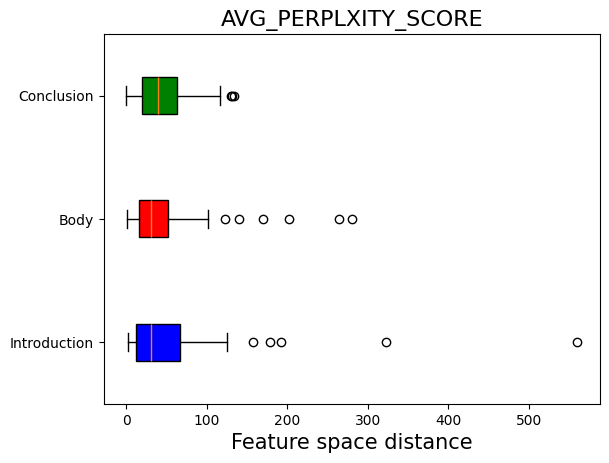

In [ ]:
test_one_way_anova(I, B, C, "AVG_PERPLXITY_SCORE")

                      sum_sq     df          F        PR(>F)
Segment         7.664980e+03    2.0   1.788287  1.683873e-01
Source          1.002882e+05    1.0  46.795726  2.474335e-11
Segment:Source  9.105930e+02    2.0   0.212447  8.086811e-01
Residual        1.002974e+06  468.0        NaN           NaN
(H>A) I-B:  WilcoxonResult(statistic=2571.5, pvalue=6.313493650756354e-07)
(H>A) I-C:  WilcoxonResult(statistic=2581.5, pvalue=1.0801945014092279e-07)
(H>A) B-C:  WilcoxonResult(statistic=2826.0, pvalue=5.670673584342805e-10)
--------------------------------------------------
(A>H) I-B:  WilcoxonResult(statistic=588.5, pvalue=0.9999993686506349)
(A>H) I-C:  WilcoxonResult(statistic=499.5, pvalue=0.9999998919805498)
(A>H) B-C:  WilcoxonResult(statistic=334.0, pvalue=0.9999999994329326)


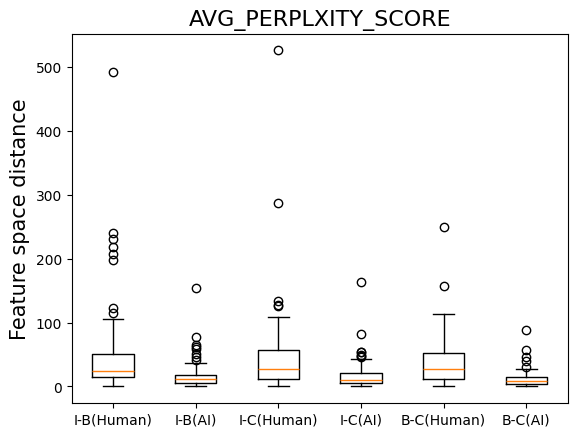

In [ ]:
test_two_way_anova(H_I_B, H_I_C, H_B_C, AI_I_B, AI_I_C, AI_B_C, "AVG_PERPLXITY_SCORE")

### Surprisal scores

In [ ]:
orig_df = pd.read_csv('reuter_feature_list.csv')
mask = (orig_df['intro_perplexity_scores'] != '[]') & (orig_df['conclusion_perplexity_scores'] != '[]') & (orig_df['body_perplexity_scores'] != '[]')
df = orig_df[mask]
df.shape

(5643, 20)

In [ ]:
N = 50
from scipy.interpolate import interp1d
def convert_to_fixed_length_time_series(time_series):
    # Create an interpolation function
    x = np.arange(len(time_series))
    f = interp1d(x, time_series, kind='linear')

    # Resample the time series to a fixed length N
    new_x = np.linspace(0, len(time_series) - 1, N)
    new_time_series = f(new_x)
    return new_time_series
def get_fixed_len_perplexity_scores(perplexity_score):
  L = ast.literal_eval(perplexity_score)
  return convert_to_fixed_length_time_series(L)
intro_col = 'intro_perplexity_scores'
body_col = 'body_perplexity_scores'
conclusion_col = 'conclusion_perplexity_scores'
df[intro_col] = df[intro_col].apply(get_fixed_len_perplexity_scores)
df[body_col] = df[body_col].apply(get_fixed_len_perplexity_scores)
df[conclusion_col] = df[conclusion_col].apply(get_fixed_len_perplexity_scores)

In [ ]:
h_intro_emd = []
h_body_emd = []
h_conclusion_emd = []
ai_intro_emd = []
ai_body_emd = []
ai_conclusion_emd = []

human_rows = df[df['source'] == 'human']

for i, row in human_rows.iterrows():
  try:
    # Get all rows with the current key but a different source
    key = row['key']
    other_sources = df[(df['key'] == key) & (df['source'] != 'human')]
    # print(other_sources.shape)
    # Sample a row from the other_sources DataFrame
    sampled_row = other_sources.sample(n=1, random_state=42).iloc[0]
    h_intro_emd.append(row[intro_col])
    h_body_emd.append(row[body_col])
    h_conclusion_emd.append(row[conclusion_col])

    ai_intro_emd.append(sampled_row[intro_col])
    ai_body_emd.append(sampled_row[body_col])
    ai_conclusion_emd.append(sampled_row[conclusion_col])
    # I.append(np.abs(row[intro_col]) - sampled_row[intro_col])
    # B.append(np.abs(row[body_col]) - sampled_row[body_col])
    # C.append(np.abs(row[conclusion_col]) - sampled_row[conclusion_col])
  except:
    continue

I  = []
B = []
C = []
for i in range(len(h_intro_emd)):
  I.append(calculate_distance(h_intro_emd[i], ai_intro_emd[i]))
  B.append(calculate_distance(h_body_emd[i], ai_body_emd[i]))
  C.append(calculate_distance(h_conclusion_emd[i], ai_conclusion_emd[i]))

H_I_B, H_I_C, H_B_C, AI_I_B, AI_I_C, AI_B_C = [], [], [], [], [], []
for i in range(len(h_intro_emd)):
  H_I_B.append(calculate_distance(h_intro_emd[i], h_body_emd[i]))
  H_I_C.append(calculate_distance(h_intro_emd[i], h_conclusion_emd[i]))
  H_B_C.append(calculate_distance(h_body_emd[i], h_conclusion_emd[i]))
  AI_I_B.append(calculate_distance(ai_intro_emd[i], ai_body_emd[i]))
  AI_I_C.append(calculate_distance(ai_intro_emd[i], ai_conclusion_emd[i]))
  AI_B_C.append(calculate_distance(ai_body_emd[i], ai_conclusion_emd[i]))


f_value:  102.41851742505064
p_value:  1.1730381605588634e-43
I>B:  WilcoxonResult(statistic=132259.0, pvalue=1.0)
I>C:  WilcoxonResult(statistic=248662.0, pvalue=0.00018960336044279667)
B>C:  WilcoxonResult(statistic=334323.0, pvalue=2.82247692443278e-44)
--------------------------------------------------
B>I:  WilcoxonResult(statistic=306257.0, pvalue=3.6520094736846537e-26)
C>I:  WilcoxonResult(statistic=189854.0, pvalue=0.9998103966395572)
C>B:  WilcoxonResult(statistic=104193.0, pvalue=1.0)


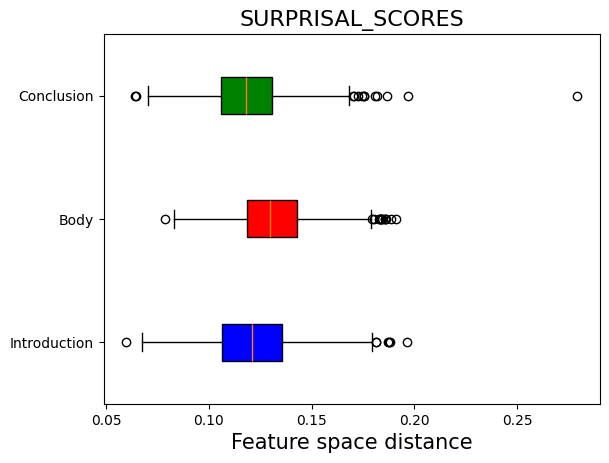

In [ ]:
test_one_way_anova(I, B, C, "SURPRISAL_SCORES")

                  sum_sq      df          F        PR(>F)
Segment         0.047408     2.0  54.018870  5.793512e-24
Source          0.022675     1.0  51.674944  7.405180e-13
Segment:Source  0.001742     2.0   1.985062  1.374686e-01
Residual        2.461698  5610.0        NaN           NaN
(H>A) I-B:  WilcoxonResult(statistic=243395.0, pvalue=0.0017641935929468152)
(H>A) I-C:  WilcoxonResult(statistic=251181.0, pvalue=5.701308869152963e-05)
(H>A) B-C:  WilcoxonResult(statistic=271485.0, pvalue=1.3698923029521685e-10)
--------------------------------------------------
(A>H) I-B:  WilcoxonResult(statistic=195121.0, pvalue=0.9982358064070532)
(A>H) I-C:  WilcoxonResult(statistic=187335.0, pvalue=0.9999429869113085)
(A>H) B-C:  WilcoxonResult(statistic=167031.0, pvalue=0.9999999998630108)


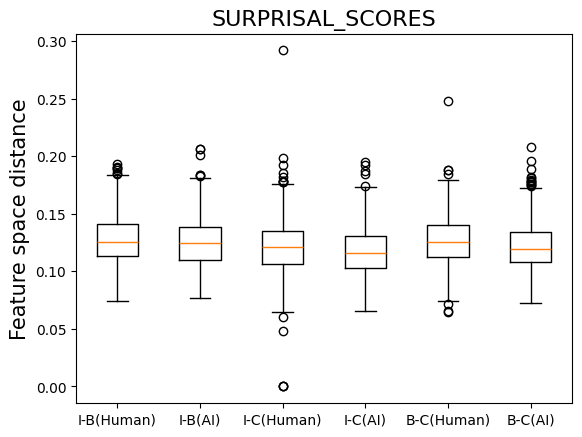

In [ ]:
test_two_way_anova(H_I_B, H_I_C, H_B_C, AI_I_B, AI_I_C, AI_B_C, "SURPRISAL_SCORES")

### Change of content

In [ ]:
df = pd.read_csv('reuter_feature_list.csv')
print(df.shape)
df = df.dropna()
df.shape

(5730, 8)


(5623, 8)

In [ ]:
def process_strings(s):
  s = s.replace('\n', '')
  s = s.replace('dtype=float32', '')
  s = s.replace('array(', '')
  s = s.replace(')', '')
  s = s.replace('[', '')
  s = s.replace(']', '')
  return s
def convert_to_traditional_form(text):
    # Split the text by comma to get individual numbers
    text = process_strings(text)
    numbers = text.split(', ')
    traditional_numbers = []
    # Convert each number from scientific notation to traditional form
    for number in numbers:
      try:
        traditional_numbers.append(float(number))
      except:
        continue
    # traditional_numbers = [float(number) for number in numbers[:-1]]
    D = 384
    N = len(traditional_numbers) // D
    array_2d = np.array(traditional_numbers).reshape(N, D)
    return array_2d

def get_content_change(s):
  embeddings = convert_to_traditional_form(s)
  # print(embeddings.shape)
  if len(embeddings)<2: # only one sentence, so we return the value 0.5 as no correlation value
    return 0.5
  n_sentences  = len(embeddings)
  D = []
  # print(n_sentences)
  for i in range(n_sentences-1):
    # print(embeddings[i])
    D.append(cosine_distance(embeddings[i], embeddings[i+1]))
  # print(embeddings.shape, D, np.mean(D))
  return np.mean(D)

In [ ]:
col_name = 'content_change'
intro_col = 'intro_' + col_name
body_col = 'body_' + col_name
conclusion_col = 'conclusion_' + col_name


In [ ]:
intro_embeddings = df['intro_embeddings']
body_embeddings = df['body_embeddings']
get_content_change(intro_embeddings[220])

0.5

In [ ]:
df[intro_col] = df['intro_embeddings'].progress_apply(get_content_change)
df[body_col] = df['body_embeddings'].progress_apply(get_content_change)
df[conclusion_col] = df['conclusion_embeddings'].progress_apply(get_content_change)

100%|██████████| 5623/5623 [00:03<00:00, 1730.13it/s]


In [ ]:
df.sample(2)

,key,source,intro_text,body_text,conclusion_text,intro_embeddings,body_embeddings,conclusion_embeddings,intro_content_change,body_content_change,conclusion_content_change
3431,MartinWolk_11,text-bison-001,Boeing Defense and Space Group President Ted C...,"""The JSF is a critical program for the U.S. mi...",Colbert's comments come as the JSF program fac...,"[array([ 1.37602001e-01, 1.76784053e-01, -2.9...","[array([ 9.53874364e-02, 6.22125380e-02, -4.5...","[array([-2.65518278e-02, -2.63544887e-01, -6.4...",0.500000,0.732987,0.685311
1491,KouroshKarimkhany_18,claude,Apple Inc. announced a slate of new hardware a...,"At a press event today, Apple unveiled upgrade...",The moves are part of Apple’s broader strategy...,"[array([ 8.56581202e-04, -4.33233261e-01, 1.2...","[array([ 2.42312461e-01, -5.32966629e-02, 2.4...","[array([ 2.37121642e-01, -4.51040357e-01, 1.1...",0.764054,0.515560,0.501747


In [ ]:
h_intro_emd = []
h_body_emd = []
h_conclusion_emd = []
ai_intro_emd = []
ai_body_emd = []
ai_conclusion_emd = []

human_rows = df[df['source'] == 'human']

for i, row in human_rows.iterrows():
  try:
    # Get all rows with the current key but a different source
    key = row['key']
    other_sources = df[(df['key'] == key) & (df['source'] != 'human')]
    # print(other_sources.shape)
    # Sample a row from the other_sources DataFrame
    sampled_row = other_sources.sample(n=1, random_state=42).iloc[0]
    h_intro_emd.append(row[intro_col])
    h_body_emd.append(row[body_col])
    h_conclusion_emd.append(row[conclusion_col])

    ai_intro_emd.append(sampled_row[intro_col])
    ai_body_emd.append(sampled_row[body_col])
    ai_conclusion_emd.append(sampled_row[conclusion_col])
    # I.append(np.abs(row[intro_col]) - sampled_row[intro_col])
    # B.append(np.abs(row[body_col]) - sampled_row[body_col])
    # C.append(np.abs(row[conclusion_col]) - sampled_row[conclusion_col])
  except:
    continue

I  = []
B = []
C = []
for i in range(len(h_intro_emd)):
  I.append(calculate_distance(h_intro_emd[i], ai_intro_emd[i]))
  B.append(calculate_distance(h_body_emd[i], ai_body_emd[i]))
  C.append(calculate_distance(h_conclusion_emd[i], ai_conclusion_emd[i]))

H_I_B, H_I_C, H_B_C, AI_I_B, AI_I_C, AI_B_C = [], [], [], [], [], []
for i in range(len(h_intro_emd)):
  H_I_B.append(calculate_distance(h_intro_emd[i], h_body_emd[i]))
  H_I_C.append(calculate_distance(h_intro_emd[i], h_conclusion_emd[i]))
  H_B_C.append(calculate_distance(h_body_emd[i], h_conclusion_emd[i]))
  AI_I_B.append(calculate_distance(ai_intro_emd[i], ai_body_emd[i]))
  AI_I_C.append(calculate_distance(ai_intro_emd[i], ai_conclusion_emd[i]))
  AI_B_C.append(calculate_distance(ai_body_emd[i], ai_conclusion_emd[i]))


f_value:  36.92728197240697
p_value:  1.4895454145889952e-16
I>B:  WilcoxonResult(statistic=180864.0, pvalue=0.9999673747761267)
I>C:  WilcoxonResult(statistic=143198.0, pvalue=0.9999999999999999)
B>C:  WilcoxonResult(statistic=167373.0, pvalue=0.9999999923525178)
--------------------------------------------------
B>I:  WilcoxonResult(statistic=245562.0, pvalue=3.262522387325223e-05)
C>I:  WilcoxonResult(statistic=274957.0, pvalue=7.78059754824189e-17)
C>B:  WilcoxonResult(statistic=259053.0, pvalue=7.647482171930432e-09)


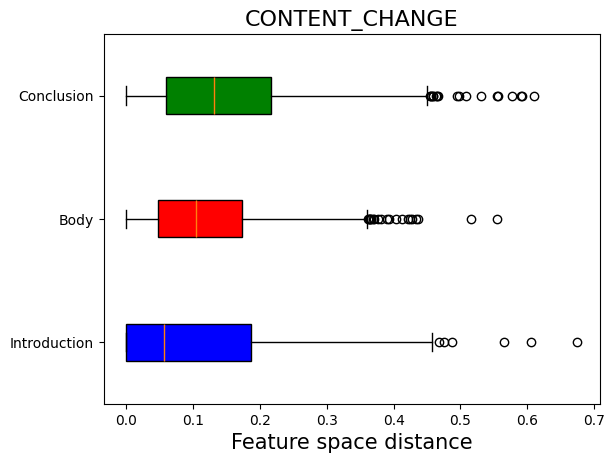

In [ ]:
test_one_way_anova(I, B, C, "CONTENT_CHANGE")

                   sum_sq      df          F        PR(>F)
Segment          0.528222     2.0  24.436548  2.716107e-11
Source           0.553136     1.0  51.178296  9.531003e-13
Segment:Source   0.575792     2.0  26.637249  3.068583e-12
Residual        59.789999  5532.0        NaN           NaN
(H>A) I-B:  WilcoxonResult(statistic=295966.0, pvalue=8.53378010368575e-25)
(H>A) I-C:  WilcoxonResult(statistic=195326.0, pvalue=0.9575126498680163)
(H>A) B-C:  WilcoxonResult(statistic=261585.0, pvalue=1.1807778173864248e-09)
--------------------------------------------------
(A>H) I-B:  WilcoxonResult(statistic=130460.0, pvalue=1.0)
(A>H) I-C:  WilcoxonResult(statistic=222829.0, pvalue=0.04248735013198363)
(A>H) B-C:  WilcoxonResult(statistic=164841.0, pvalue=0.9999999988192222)


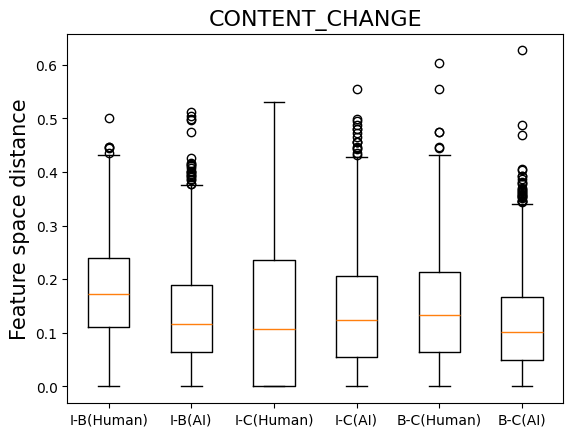

In [ ]:
test_two_way_anova(H_I_B, H_I_C, H_B_C, AI_I_B, AI_I_C, AI_B_C, "CONTENT_CHANGE")

### Content similarity

In [ ]:
df = pd.read_csv('reuter_feature_list.csv')
print(df.shape)
df = df.dropna()
df.shape

(5730, 8)


(5623, 8)

In [ ]:
def process_strings(s):
  s = s.replace('\n', '')
  s = s.replace('dtype=float32', '')
  s = s.replace('array(', '')
  s = s.replace(')', '')
  s = s.replace('[', '')
  s = s.replace(']', '')
  return s
def convert_to_traditional_form(text):
    # Split the text by comma to get individual numbers
    text = process_strings(text)
    numbers = text.split(', ')
    traditional_numbers = []
    # Convert each number from scientific notation to traditional form
    for number in numbers:
      try:
        traditional_numbers.append(float(number))
      except:
        continue
    # traditional_numbers = [float(number) for number in numbers[:-1]]
    D = 384
    N = len(traditional_numbers) // D
    array_2d = np.array(traditional_numbers).reshape(N, D)
    return array_2d

def get_avg_content_vector(s):
  embeddings = convert_to_traditional_form(s)
  return np.mean(embeddings, axis=0)

In [ ]:
col_name = 'content_vector'
intro_col = 'intro_' + col_name
body_col = 'body_' + col_name
conclusion_col = 'conclusion_' + col_name

In [ ]:
df[intro_col] = df['intro_embeddings'].progress_apply(get_avg_content_vector)
df[body_col] = df['body_embeddings'].progress_apply(get_avg_content_vector)
df[conclusion_col] = df['conclusion_embeddings'].progress_apply(get_avg_content_vector)

100%|██████████| 5623/5623 [00:03<00:00, 1738.46it/s]


In [ ]:
df.sample(2)

,key,source,intro_text,body_text,conclusion_text,intro_embeddings,body_embeddings,conclusion_embeddings,intro_content_similarity,body_content_similarity,conclusion_content_similarity,intro_content_vector,body_content_vector,conclusion_content_vector
3329,KeithWeir_1,text-bison-001,English soccer clubs face financial ruin if th...,"Sugar, who has also been chairman of Amstrad a...",Sugar believes that the current financial mode...,"[array([ 0.07776719, -0.24549128, 0.27808827,...","[array([-5.15034273e-02, 1.64624944e-01, -4.2...","[array([ 6.76631033e-02, -2.69971013e-01, -4.0...",0.5,0.675488,0.537286,"[0.07776719, -0.24549128, 0.27808827, -0.54659...","[0.2218720477166667, -0.07865198316666668, -0....","[0.21844099465, -0.11968106214999999, -0.23409..."
3588,LydiaZajc_17,text-bison-001,Canadian shoppers are increasingly turning to ...,"The survey, conducted by Ipsos Reid for the Re...",Patterson said that the growth of online shopp...,"[array([ 0.2266545 , -0.09311444, 0.03258847,...","[array([ 1.85869426e-01, -4.85798717e-02, -1.8...","[array([ 3.78928393e-01, -6.66378617e-01, -4.0...",0.5,0.407469,0.552216,"[0.2266545, -0.09311444, 0.03258847, -0.236492...","[0.0751631734, 0.045085641700000005, -0.143989...","[0.054962818999999975, -0.4414022626666667, -0..."


In [ ]:
h_intro_emd = []
h_body_emd = []
h_conclusion_emd = []
ai_intro_emd = []
ai_body_emd = []
ai_conclusion_emd = []

human_rows = df[df['source'] == 'human']

for i, row in human_rows.iterrows():
  try:
    # Get all rows with the current key but a different source
    key = row['key']
    other_sources = df[(df['key'] == key) & (df['source'] != 'human')]
    # print(other_sources.shape)
    # Sample a row from the other_sources DataFrame
    sampled_row = other_sources.sample(n=1, random_state=42).iloc[0]
    h_intro_emd.append(row[intro_col])
    h_body_emd.append(row[body_col])
    h_conclusion_emd.append(row[conclusion_col])

    ai_intro_emd.append(sampled_row[intro_col])
    ai_body_emd.append(sampled_row[body_col])
    ai_conclusion_emd.append(sampled_row[conclusion_col])
    # I.append(np.abs(row[intro_col]) - sampled_row[intro_col])
    # B.append(np.abs(row[body_col]) - sampled_row[body_col])
    # C.append(np.abs(row[conclusion_col]) - sampled_row[conclusion_col])
  except:
    continue

I  = []
B = []
C = []
for i in range(len(h_intro_emd)):
  I.append(calculate_distance(h_intro_emd[i], ai_intro_emd[i], method='cosine'))
  B.append(calculate_distance(h_body_emd[i], ai_body_emd[i], method='cosine'))
  C.append(calculate_distance(h_conclusion_emd[i], ai_conclusion_emd[i], method='cosine'))

H_I_B, H_I_C, H_B_C, AI_I_B, AI_I_C, AI_B_C = [], [], [], [], [], []
for i in range(len(h_intro_emd)):
  H_I_B.append(calculate_distance(h_intro_emd[i], h_body_emd[i], method='cosine'))
  H_I_C.append(calculate_distance(h_intro_emd[i], h_conclusion_emd[i], method='cosine'))
  H_B_C.append(calculate_distance(h_body_emd[i], h_conclusion_emd[i], method='cosine'))
  AI_I_B.append(calculate_distance(ai_intro_emd[i], ai_body_emd[i], method='cosine'))
  AI_I_C.append(calculate_distance(ai_intro_emd[i], ai_conclusion_emd[i], method='cosine'))
  AI_B_C.append(calculate_distance(ai_body_emd[i], ai_conclusion_emd[i], method='cosine'))


f_value:  126.72031381401582
p_value:  2.2040296246075693e-53
I>B:  WilcoxonResult(statistic=372450.0, pvalue=2.6048268953230416e-86)
I>C:  WilcoxonResult(statistic=255625.0, pvalue=8.245258203070359e-08)
B>C:  WilcoxonResult(statistic=93299.0, pvalue=1.0)
--------------------------------------------------
B>I:  WilcoxonResult(statistic=53976.0, pvalue=1.0)
C>I:  WilcoxonResult(statistic=170801.0, pvalue=0.999999917547418)
C>B:  WilcoxonResult(statistic=333127.0, pvalue=7.164423154380286e-50)


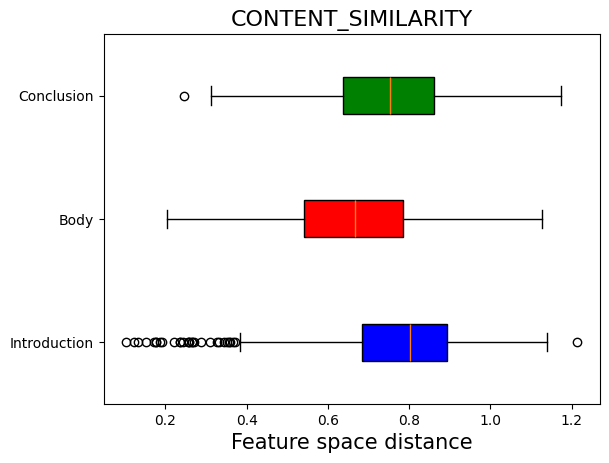

In [ ]:
test_one_way_anova(I, B, C, "CONTENT_SIMILARITY")

                    sum_sq      df            F         PR(>F)
Segment          14.986526     2.0   358.411410  4.307599e-147
Source           26.968296     1.0  1289.924684  4.143422e-254
Segment:Source    2.184213     2.0    52.236718   3.353045e-23
Residual        115.656840  5532.0          NaN            NaN
(H>A) I-B:  WilcoxonResult(statistic=334144.0, pvalue=1.0994501281103664e-50)
(H>A) I-C:  WilcoxonResult(statistic=368918.0, pvalue=1.2755880448032495e-82)
(H>A) B-C:  WilcoxonResult(statistic=373491.0, pvalue=2.053628037780911e-87)
--------------------------------------------------
(A>H) I-B:  WilcoxonResult(statistic=92282.0, pvalue=1.0)
(A>H) I-C:  WilcoxonResult(statistic=57508.0, pvalue=1.0)
(A>H) B-C:  WilcoxonResult(statistic=52935.0, pvalue=1.0)


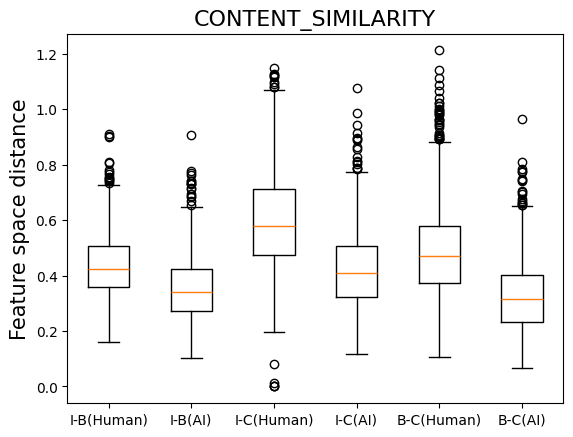

In [ ]:
test_two_way_anova(H_I_B, H_I_C, H_B_C, AI_I_B, AI_I_C, AI_B_C, "CONTENT_SIMILARITY")

### Pos_tag

In [ ]:
orig_df =  pd.read_csv('reuter_feature_list.csv')
pos_tags = ['ADJ', 'ADP', 'ADV', 'AUX', 'CONJ', 'DET', 'INTJ', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SYM', 'VERB', 'X']
pos_tag_counts = Counter({tag: 0 for tag in pos_tags})
pos_tag_str = str(pos_tag_counts)[8:-1]
mask = (orig_df['intro_pos_tag'] != pos_tag_str) & (orig_df['body_pos_tag'] != pos_tag_str) & (orig_df['conclusion_pos_tag'] != pos_tag_str)
df = orig_df[mask]
df.shape

(5643, 60)

In [ ]:
def get_pos_tag_percentage(pos_tag_counts, wc):
  D = ast.literal_eval(pos_tag_counts)
  for k in D.keys():
    D[k] = round(D[k]*100/wc,2)
  return D
intro_col = 'intro_pos_tag'
body_col = 'body_pos_tag'
conclusion_col = 'conclusion_pos_tag'
df['intro_pos_tag'] = df.apply(lambda row: get_pos_tag_percentage(row['intro_pos_tag'], row['intro_word_count']), axis=1)
df['body_pos_tag'] = df.apply(lambda row: get_pos_tag_percentage(row['body_pos_tag'], row['body_word_count']), axis=1)
df['conclusion_pos_tag'] = df.apply(lambda row: get_pos_tag_percentage(row['conclusion_pos_tag'], row['conclusion_word_count']), axis=1)

intro_col = 'intro_pos_tag'
body_col = 'body_pos_tag'
conclusion_col = 'conclusion_pos_tag'
df = df.sample(frac=1)



In [ ]:
h_intro_emd = []
h_body_emd = []
h_conclusion_emd = []
ai_intro_emd = []
ai_body_emd = []
ai_conclusion_emd = []
human_rows = df[df['source'] == 'human']

for i, row in human_rows.iterrows():
  try:
    # Get all rows with the current key but a different source
    key = row['key']
    other_sources = df[(df['key'] == key) & (df['source'] != 'human')]
    # print(other_sources.shape)
    # Sample a row from the other_sources DataFrame
    sampled_row = other_sources.sample(n=1, random_state=42).iloc[0]

    h_intro_emd.append(list(row[intro_col].values())[:len(pos_tags)])
    h_body_emd.append(list(row[body_col].values())[:len(pos_tags)])
    h_conclusion_emd.append(list(row[conclusion_col].values())[:len(pos_tags)])
    # print(h_intro_emd.shape, h_body_emd.shape, h_conclusion_emd.shape)



    ai_intro_emd.append(list(sampled_row[intro_col].values())[:len(pos_tags)])
    ai_body_emd.append(list(sampled_row[body_col].values())[:len(pos_tags)])
    ai_conclusion_emd.append(list(sampled_row[conclusion_col].values())[:len(pos_tags)])

  except:
    continue

I  = []
B = []
C = []
for i in range(len(h_intro_emd)):
  I.append(calculate_distance(h_intro_emd[i], ai_intro_emd[i]))
  B.append(calculate_distance(h_body_emd[i], ai_body_emd[i]))
  C.append(calculate_distance(h_conclusion_emd[i], ai_conclusion_emd[i]))

f_value:  466.50862151455675
p_value:  1.2485909630368227e-175
I-B:  WilcoxonResult(statistic=422213.0, pvalue=3.385655456035829e-133)
I-C:  WilcoxonResult(statistic=252942.0, pvalue=2.3357343532523358e-05)
B-C:  WilcoxonResult(statistic=39198.0, pvalue=1.0)


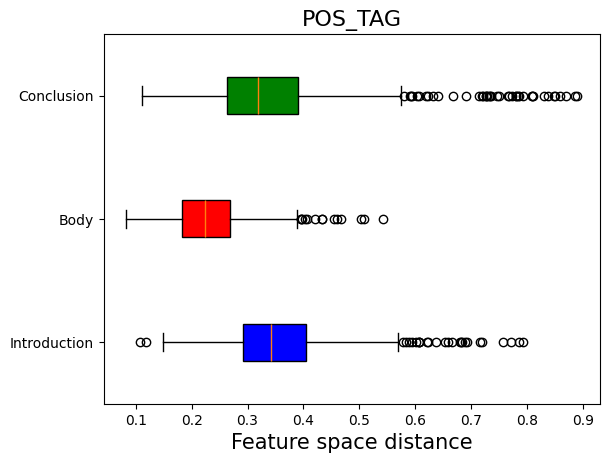

In [ ]:
test_one_way_anova(I, B, C, "POS_TAG")

In [ ]:
H_I_B, H_I_C, H_B_C, AI_I_B, AI_I_C, AI_B_C = [], [], [], [], [], []
for i in range(len(h_intro_emd)):
  H_I_B.append(calculate_distance(h_intro_emd[i], h_body_emd[i]))
  H_I_C.append(calculate_distance(h_intro_emd[i], h_conclusion_emd[i]))
  H_B_C.append(calculate_distance(h_body_emd[i], h_conclusion_emd[i]))
  AI_I_B.append(calculate_distance(ai_intro_emd[i], ai_body_emd[i]))
  AI_I_C.append(calculate_distance(ai_intro_emd[i], ai_conclusion_emd[i]))
  AI_B_C.append(calculate_distance(ai_body_emd[i], ai_conclusion_emd[i]))


                   sum_sq      df           F         PR(>F)
Segment          5.970944     2.0  279.599868  1.774002e-116
Source           1.200866     1.0  112.465281   4.977229e-26
Segment:Source   0.702269     2.0   32.884987   6.328499e-15
Residual        59.901667  5610.0         NaN            NaN
I-B:  WilcoxonResult(statistic=242385.0, pvalue=0.0025915521856113293)
I-C:  WilcoxonResult(statistic=282071.0, pvalue=1.5702818502870983e-14)
B-C:  WilcoxonResult(statistic=306328.0, pvalue=3.334065815545928e-26)


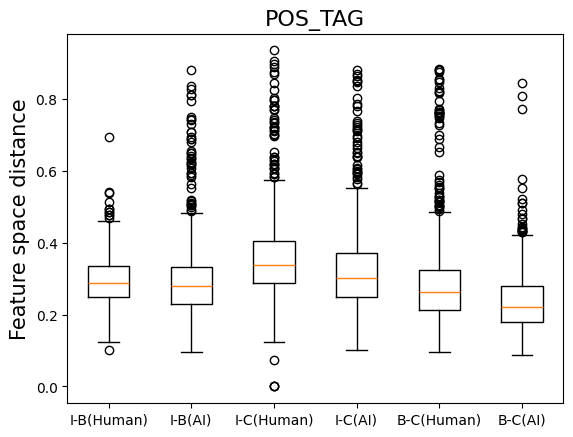

In [ ]:
test_two_way_anova(H_I_B, H_I_C, H_B_C, AI_I_B, AI_I_C, AI_B_C, "POS_TAG")

### NER tags

In [ ]:
orig_df =  pd.read_csv('reuter_feature_list.csv')
ner_tags =  ['PERSON', 'NORP', 'FAC', 'ORG', 'GPE', 'LOC', 'PRODUCT', 'EVENT', 'WORK_OF_ART', 'LAW', 'LANGUAGE', 'DATE', 'TIME', 'PERCENT', 'MONEY', 'QUANTITY', 'ORDINAL', 'CARDINAL']
ner_tag_counts = Counter({tag: 0 for tag in ner_tags})
ner_tag_str = str(ner_tag_counts)[8:-1]
mask = (orig_df['intro_ner_tags'] != ner_tag_str) & (orig_df['body_ner_tags'] != ner_tag_str) & (orig_df['conclusion_ner_tags'] != ner_tag_str)
df = orig_df[mask]
def get_ner_tag_percentage(ner_tag_counts, wc):
  D = ast.literal_eval(ner_tag_counts)
  for k in D.keys():
    D[k] = round(D[k]*100/wc,2)
  return D
intro_col = 'intro_ner_tags'
body_col = 'body_ner_tags'
conclusion_col = 'conclusion_ner_tags'
df['intro_ner_tags'] = df.apply(lambda row: get_ner_tag_percentage(row['intro_ner_tags'], row['intro_word_count']), axis=1)
df['body_ner_tags'] = df.apply(lambda row: get_ner_tag_percentage(row['body_ner_tags'], row['body_word_count']), axis=1)
df['conclusion_ner_tags'] = df.apply(lambda row: get_ner_tag_percentage(row['conclusion_ner_tags'], row['conclusion_word_count']), axis=1)

In [ ]:
h_intro_emd = []
h_body_emd = []
h_conclusion_emd = []
ai_intro_emd = []
ai_body_emd = []
ai_conclusion_emd = []
human_rows = df[df['source'] == 'human']

for i, row in human_rows.iterrows():
  try:
    # Get all rows with the current key but a different source
    key = row['key']
    other_sources = df[(df['key'] == key) & (df['source'] != 'human')]
    # print(other_sources.shape)
    # Sample a row from the other_sources DataFrame
    sampled_row = other_sources.sample(n=1, random_state=42).iloc[0]

    h_intro_emd.append(list(row[intro_col].values())[:len(pos_tags)])
    h_body_emd.append(list(row[body_col].values())[:len(pos_tags)])
    h_conclusion_emd.append(list(row[conclusion_col].values())[:len(pos_tags)])
    # print(h_intro_emd.shape, h_body_emd.shape, h_conclusion_emd.shape)



    ai_intro_emd.append(list(sampled_row[intro_col].values())[:len(pos_tags)])
    ai_body_emd.append(list(sampled_row[body_col].values())[:len(pos_tags)])
    ai_conclusion_emd.append(list(sampled_row[conclusion_col].values())[:len(pos_tags)])

  except:
    continue

I  = []
B = []
C = []
for i in range(len(h_intro_emd)):
  I.append(calculate_distance(h_intro_emd[i], ai_intro_emd[i]))
  B.append(calculate_distance(h_body_emd[i], ai_body_emd[i]))
  C.append(calculate_distance(h_conclusion_emd[i], ai_conclusion_emd[i]))

In [ ]:
for i in range(len(I)):
  if math.isnan(I[i]):
    I[i] = 1
  if math.isnan(B[i]):
    B[i] = 1
  if math.isnan(C[i]):
    C[i] = 1

f_value:  43.72747318083488
p_value:  2.1271188388321032e-19
I-B:  WilcoxonResult(statistic=224838.0, pvalue=1.6285980803187924e-10)
I-C:  WilcoxonResult(statistic=134488.5, pvalue=0.9999998178684165)
B-C:  WilcoxonResult(statistic=101155.0, pvalue=1.0)


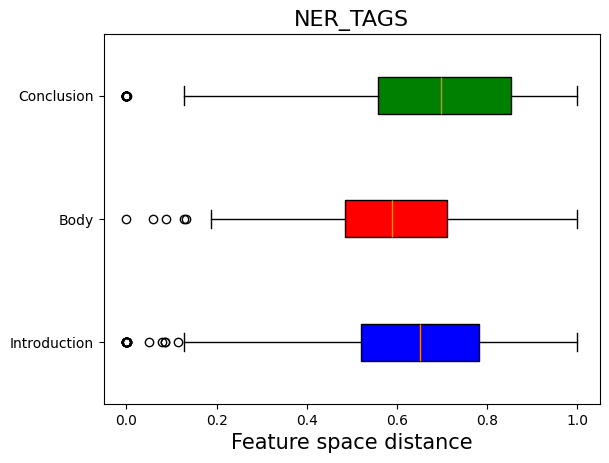

In [ ]:
test_one_way_anova(I, B, C, "NER_TAGS")

In [ ]:
H_I_B, H_I_C, H_B_C, AI_I_B, AI_I_C, AI_B_C = [], [], [], [], [], []
for i in range(len(h_intro_emd)):
  H_I_B.append(calculate_distance(h_intro_emd[i], h_body_emd[i]))
  H_I_C.append(calculate_distance(h_intro_emd[i], h_conclusion_emd[i]))
  H_B_C.append(calculate_distance(h_body_emd[i], h_conclusion_emd[i]))
  AI_I_B.append(calculate_distance(ai_intro_emd[i], ai_body_emd[i]))
  AI_I_C.append(calculate_distance(ai_intro_emd[i], ai_conclusion_emd[i]))
  AI_B_C.append(calculate_distance(ai_body_emd[i], ai_conclusion_emd[i]))


                    sum_sq      df          F        PR(>F)
Segment           0.384953     2.0   4.711191  9.033236e-03
Source            2.358506     1.0  57.728511  3.558588e-14
Segment:Source    1.682230     2.0  20.587738  1.243826e-09
Residual        208.361210  5100.0        NaN           NaN
I-B:  WilcoxonResult(statistic=191511.0, pvalue=0.07653966203929004)
I-C:  WilcoxonResult(statistic=232668.0, pvalue=4.369378715450232e-16)
B-C:  WilcoxonResult(statistic=202092.5, pvalue=0.0009738708306775613)


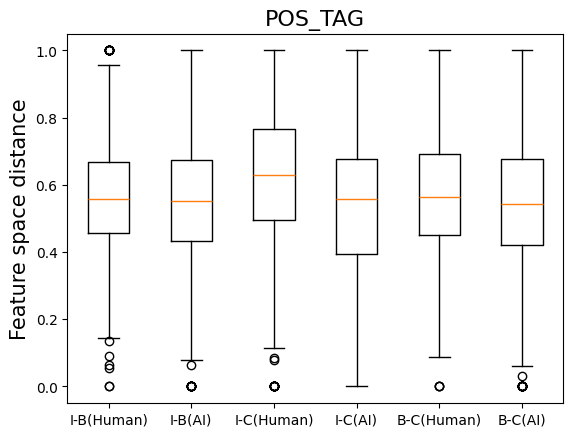

In [ ]:
test_two_way_anova(H_I_B, H_I_C, H_B_C, AI_I_B, AI_I_C, AI_B_C, "POS_TAG")

### Stopwords distribution

In [ ]:
orig_df = pd.read_csv('reuter_feature_list.csv')
mask = (orig_df['intro_stopwords'] != '{}') & (orig_df['body_stopwords'] != '{}') & (orig_df['conclusion_stopwords'] != '{}')
df = orig_df[mask]
def get_percentage_of_stopwords_count(s,wc):
  D = ast.literal_eval(s)
  counter = Counter(D)
  total_sum = sum(counter.values())
  return round(total_sum*100/wc,2)

intro_col = 'intro_stopwords'
body_col = 'body_stopwords'
conclusion_col = 'conclusion_stopwords'
df['intro_stopwords_frac'] = df.apply(lambda row: get_percentage_of_stopwords_count(row[intro_col], row['intro_word_count']), axis=1)
df['body_stopwords_frac'] = df.apply(lambda row: get_percentage_of_stopwords_count(row[body_col], row['body_word_count']), axis=1)
df['conclusion_stopwords_frac'] = df.apply(lambda row: get_percentage_of_stopwords_count(row[conclusion_col], row['conclusion_word_count']), axis=1)

In [ ]:
D = {}
for  index,row in df.iterrows():
  d = ast.literal_eval(row['intro_stopwords'])
  for k in d:
    if k not in D:
      D[k] = d[k]
    else:
      D[k] += d[k]
  d = ast.literal_eval(row['body_stopwords'])
  for k in d:
    if k not in D:
      D[k] = d[k]
    else:
      D[k] += d[k]
  d = ast.literal_eval(row['conclusion_stopwords'])
  for k in d:
    if k not in D:
      D[k] = d[k]
    else:
      D[k] += d[k]
  # print(d)
  # break

In [ ]:
total_counts = Counter(D)
K = 20
top_K_values = total_counts.most_common(K)
TOP_STOPWORDS = [item for item, _ in top_K_values]
stopwords_tags = TOP_STOPWORDS
print(stopwords_tags)

['the', 'to', 'and', 'in', 'of', 'a', "'s", 'for', 'is', 'that', 'its', 'on', 'has', 'with', 'as', 'it', 'will', 'by', 'from', 'be']


In [ ]:
def get_percentage_of_top_stopwords(s,wc):
  D = ast.literal_eval(s)
  top_D = {}
  for d in stopwords_tags:
    if d not in D: top_D[d] = 0
    else: top_D[d] = round(D[d]*100/wc,2)
  return top_D

intro_col = 'intro_stopwords'
body_col = 'body_stopwords'
conclusion_col = 'conclusion_stopwords'
df[intro_col] = df.apply(lambda row: get_percentage_of_top_stopwords(row[intro_col], row['intro_word_count']), axis=1)
df[body_col] = df.apply(lambda row: get_percentage_of_top_stopwords(row[body_col], row['body_word_count']), axis=1)
df[conclusion_col] = df.apply(lambda row: get_percentage_of_top_stopwords(row[conclusion_col], row['conclusion_word_count']), axis=1)

In [ ]:
h_intro_emd = []
h_body_emd = []
h_conclusion_emd = []
ai_intro_emd = []
ai_body_emd = []
ai_conclusion_emd = []
human_rows = df[df['source'] == 'human']

for i, row in human_rows.iterrows():
  try:
    # Get all rows with the current key but a different source
    key = row['key']
    other_sources = df[(df['key'] == key) & (df['source'] != 'human')]
    # print(other_sources.shape)
    # Sample a row from the other_sources DataFrame
    sampled_row = other_sources.sample(n=1, random_state=42).iloc[0]

    h_intro_emd.append(list(row[intro_col].values())[:len(pos_tags)])
    h_body_emd.append(list(row[body_col].values())[:len(pos_tags)])
    h_conclusion_emd.append(list(row[conclusion_col].values())[:len(pos_tags)])
    # print(h_intro_emd.shape, h_body_emd.shape, h_conclusion_emd.shape)



    ai_intro_emd.append(list(sampled_row[intro_col].values())[:len(pos_tags)])
    ai_body_emd.append(list(sampled_row[body_col].values())[:len(pos_tags)])
    ai_conclusion_emd.append(list(sampled_row[conclusion_col].values())[:len(pos_tags)])

  except:
    continue

I  = []
B = []
C = []
for i in range(len(h_intro_emd)):
  I.append(calculate_distance(h_intro_emd[i], ai_intro_emd[i]))
  B.append(calculate_distance(h_body_emd[i], ai_body_emd[i]))
  C.append(calculate_distance(h_conclusion_emd[i], ai_conclusion_emd[i]))

f_value:  943.9333313441389
p_value:  9.4394387477e-314
I-B:  WilcoxonResult(statistic=426534.0, pvalue=2.8361934053524596e-145)
I-C:  WilcoxonResult(statistic=318116.0, pvalue=1.2002681853614252e-35)
B-C:  WilcoxonResult(statistic=28426.0, pvalue=1.0)


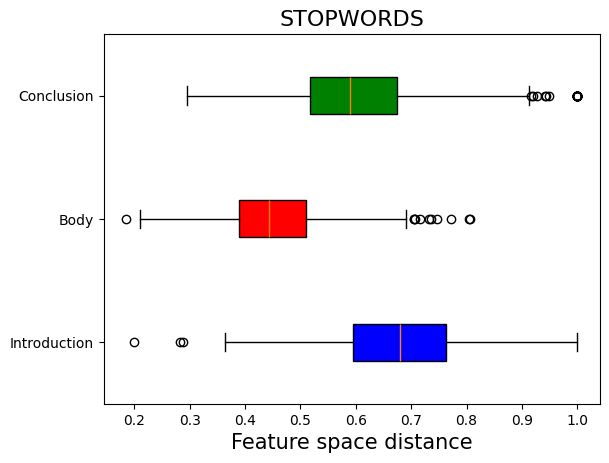

In [ ]:
test_one_way_anova(I, B, C, "STOPWORDS")

In [ ]:
H_I_B, H_I_C, H_B_C, AI_I_B, AI_I_C, AI_B_C = [], [], [], [], [], []
for i in range(len(h_intro_emd)):
  H_I_B.append(calculate_distance(h_intro_emd[i], h_body_emd[i]))
  H_I_C.append(calculate_distance(h_intro_emd[i], h_conclusion_emd[i]))
  H_B_C.append(calculate_distance(h_body_emd[i], h_conclusion_emd[i]))
  AI_I_B.append(calculate_distance(ai_intro_emd[i], ai_body_emd[i]))
  AI_I_C.append(calculate_distance(ai_intro_emd[i], ai_conclusion_emd[i]))
  AI_B_C.append(calculate_distance(ai_body_emd[i], ai_conclusion_emd[i]))


                   sum_sq      df           F         PR(>F)
Segment         13.731895     2.0  439.417505  6.201783e-178
Source          10.179769     1.0  651.500533  5.271440e-136
Segment:Source   0.758931     2.0   24.285617   3.151944e-11
Residual        87.094372  5574.0         NaN            NaN
I-B:  WilcoxonResult(statistic=295516.0, pvalue=2.491359124449667e-22)
I-C:  WilcoxonResult(statistic=341525.0, pvalue=6.670300933903349e-53)
B-C:  WilcoxonResult(statistic=342885.0, pvalue=5.16694102568384e-54)


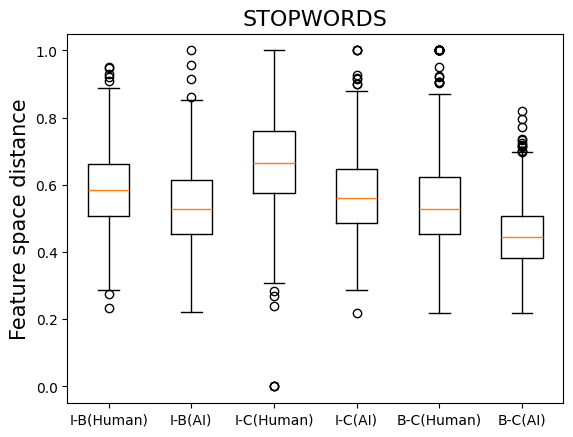

In [ ]:
test_two_way_anova(H_I_B, H_I_C, H_B_C, AI_I_B, AI_I_C, AI_B_C, "STOPWORDS")

## Enron

In [ ]:
import os
os.chdir("/content/drive/My Drive/PSU/text_variation_and_chess/enron_email_dataset")
!pwd

/content/drive/My Drive/PSU/text_variation_and_chess/enron_email_dataset


### VOC_richness

In [ ]:
orig_df =  pd.read_csv('enron_feature_list.csv')
col_name = 'brunet_idx'
intro_col = 'intro_' + col_name
body_col = 'body_' + col_name
conclusion_col = 'conclusion_' + col_name
mask = (orig_df[intro_col] != 0) & (orig_df[body_col] != 0) & (orig_df[conclusion_col] != 0) & (orig_df[intro_col] != 1) & (orig_df[body_col] != 1) & (orig_df[conclusion_col] != 1)
df = orig_df[mask]
df.shape

(7036, 60)

In [ ]:
h_intro_emd = []
h_body_emd = []
h_conclusion_emd = []
ai_intro_emd = []
ai_body_emd = []
ai_conclusion_emd = []

human_rows = df[df['source'] == 'human']

for i, row in human_rows.iterrows():
  try:
    # Get all rows with the current key but a different source
    key = row['key']
    other_sources = df[(df['key'] == key) & (df['source'] != 'human')]
    # print(other_sources.shape)
    # Sample a row from the other_sources DataFrame
    sampled_row = other_sources.sample(n=1, random_state=42).iloc[0]
    h_intro_emd.append(row[intro_col])
    h_body_emd.append(row[body_col])
    h_conclusion_emd.append(row[conclusion_col])

    ai_intro_emd.append(sampled_row[intro_col])
    ai_body_emd.append(sampled_row[body_col])
    ai_conclusion_emd.append(sampled_row[conclusion_col])
    # I.append(np.abs(row[intro_col]) - sampled_row[intro_col])
    # B.append(np.abs(row[body_col]) - sampled_row[body_col])
    # C.append(np.abs(row[conclusion_col]) - sampled_row[conclusion_col])
  except:
    continue

I  = []
B = []
C = []
for i in range(len(h_intro_emd)):
  I.append(calculate_distance(h_intro_emd[i], ai_intro_emd[i]))
  B.append(calculate_distance(h_body_emd[i], ai_body_emd[i]))
  C.append(calculate_distance(h_conclusion_emd[i], ai_conclusion_emd[i]))

H_I_B, H_I_C, H_B_C, AI_I_B, AI_I_C, AI_B_C = [], [], [], [], [], []
for i in range(len(h_intro_emd)):
  H_I_B.append(calculate_distance(h_intro_emd[i], h_body_emd[i]))
  H_I_C.append(calculate_distance(h_intro_emd[i], h_conclusion_emd[i]))
  H_B_C.append(calculate_distance(h_body_emd[i], h_conclusion_emd[i]))
  AI_I_B.append(calculate_distance(ai_intro_emd[i], ai_body_emd[i]))
  AI_I_C.append(calculate_distance(ai_intro_emd[i], ai_conclusion_emd[i]))
  AI_B_C.append(calculate_distance(ai_body_emd[i], ai_conclusion_emd[i]))


f_value:  4.280860405758481
p_value:  0.013907713088240297
I>B:  WilcoxonResult(statistic=289675.0, pvalue=0.8930691231434266)
I>C:  WilcoxonResult(statistic=274172.0, pvalue=0.9948873986142431)
B>C:  WilcoxonResult(statistic=289379.0, pvalue=0.8981539920686311)
--------------------------------------------------
B>I:  WilcoxonResult(statistic=315875.0, pvalue=0.10693087685657343)
C>I:  WilcoxonResult(statistic=328081.0, pvalue=0.00511260138575682)
C>B:  WilcoxonResult(statistic=316171.0, pvalue=0.10184600793136889)


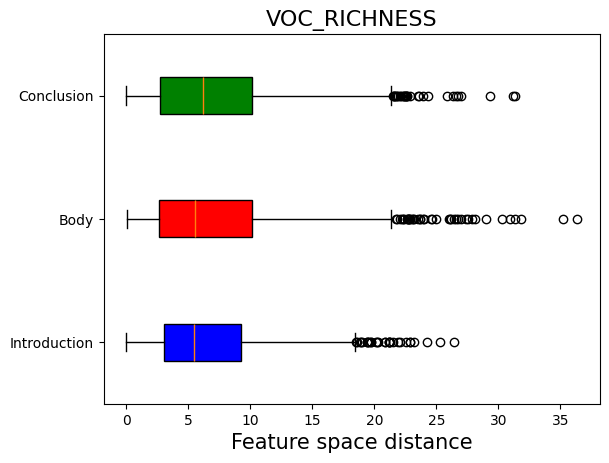

In [ ]:
test_one_way_anova(I, B, C, "VOC_RICHNESS")

                       sum_sq      df            F        PR(>F)
Segment         189212.495369     2.0  1012.526719  0.000000e+00
Source            7262.679753     1.0    77.729087  1.492141e-18
Segment:Source    4399.422917     2.0    23.542490  6.485713e-11
Residual        616115.689008  6594.0          NaN           NaN
(H>A) I-B:  WilcoxonResult(statistic=306000.0, pvalue=0.3797985970586488)
(H>A) I-C:  WilcoxonResult(statistic=364842.0, pvalue=6.373129916586151e-10)
(H>A) B-C:  WilcoxonResult(statistic=400735.0, pvalue=7.35293941638468e-21)
--------------------------------------------------
(A>H) I-B:  WilcoxonResult(statistic=299550.0, pvalue=0.6202014029413512)
(A>H) I-C:  WilcoxonResult(statistic=237411.0, pvalue=0.999999999362687)
(A>H) B-C:  WilcoxonResult(statistic=204815.0, pvalue=1.0)


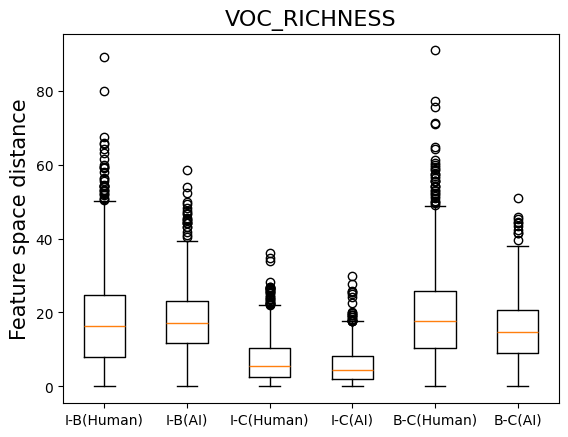

In [ ]:
test_two_way_anova(H_I_B, H_I_C, H_B_C, AI_I_B, AI_I_C, AI_B_C, "VOC_RICHNESS")

### Readability score

In [ ]:
orig_df =  pd.read_csv('enron_feature_list.csv')
score_name = 'flesch_reading_ease'
col_name = 'reading_scores'
intro_col = 'intro_' + col_name
body_col = 'body_' + col_name
conclusion_col = 'conclusion_' + col_name
mask = (orig_df['intro_reading_scores'] != '{}') & (orig_df['body_reading_scores'] != '{}') & (orig_df['conclusion_reading_scores'] != '{}')
df = orig_df[mask]

In [ ]:
h_intro_emd = []
h_body_emd = []
h_conclusion_emd = []
ai_intro_emd = []
ai_body_emd = []
ai_conclusion_emd = []

human_rows = df[df['source'] == 'human']

for i, row in human_rows.iterrows():
  try:
    # Get all rows with the current key but a different source
    key = row['key']
    other_sources = df[(df['key'] == key) & (df['source'] != 'human')]
    # print(other_sources.shape)
    # Sample a row from the other_sources DataFrame
    sampled_row = other_sources.sample(n=1, random_state=42).iloc[0]
    h_intro_emd.append(ast.literal_eval(row[intro_col])[score_name])
    h_body_emd.append(ast.literal_eval(row[body_col])[score_name])
    h_conclusion_emd.append(ast.literal_eval(row[conclusion_col])[score_name])

    ai_intro_emd.append(ast.literal_eval(sampled_row[intro_col])[score_name])
    ai_body_emd.append(ast.literal_eval(sampled_row[body_col])[score_name])
    ai_conclusion_emd.append(ast.literal_eval(sampled_row[conclusion_col])[score_name])
    # I.append(np.abs(row[intro_col]) - sampled_row[intro_col])
    # B.append(np.abs(row[body_col]) - sampled_row[body_col])
    # C.append(np.abs(row[conclusion_col]) - sampled_row[conclusion_col])
  except:
    continue

I  = []
B = []
C = []
for i in range(len(h_intro_emd)):
  I.append(calculate_distance(h_intro_emd[i], ai_intro_emd[i]))
  B.append(calculate_distance(h_body_emd[i], ai_body_emd[i]))
  C.append(calculate_distance(h_conclusion_emd[i], ai_conclusion_emd[i]))

H_I_B, H_I_C, H_B_C, AI_I_B, AI_I_C, AI_B_C = [], [], [], [], [], []
for i in range(len(h_intro_emd)):
  H_I_B.append(calculate_distance(h_intro_emd[i], h_body_emd[i]))
  H_I_C.append(calculate_distance(h_intro_emd[i], h_conclusion_emd[i]))
  H_B_C.append(calculate_distance(h_body_emd[i], h_conclusion_emd[i]))
  AI_I_B.append(calculate_distance(ai_intro_emd[i], ai_body_emd[i]))
  AI_I_C.append(calculate_distance(ai_intro_emd[i], ai_conclusion_emd[i]))
  AI_B_C.append(calculate_distance(ai_body_emd[i], ai_conclusion_emd[i]))


f_value:  167.87224566988579
p_value:  7.114263838773983e-71
I>B:  WilcoxonResult(statistic=742527.0, pvalue=2.7481663773581282e-61)
I>C:  WilcoxonResult(statistic=561607.5, pvalue=4.213551107955596e-06)
B>C:  WilcoxonResult(statistic=290406.5, pvalue=1.0)
--------------------------------------------------
B>I:  WilcoxonResult(statistic=242379.0, pvalue=1.0)
C>I:  WilcoxonResult(statistic=426107.5, pvalue=0.9999957864488921)
C>B:  WilcoxonResult(statistic=698714.5, pvalue=2.7425908638907437e-41)


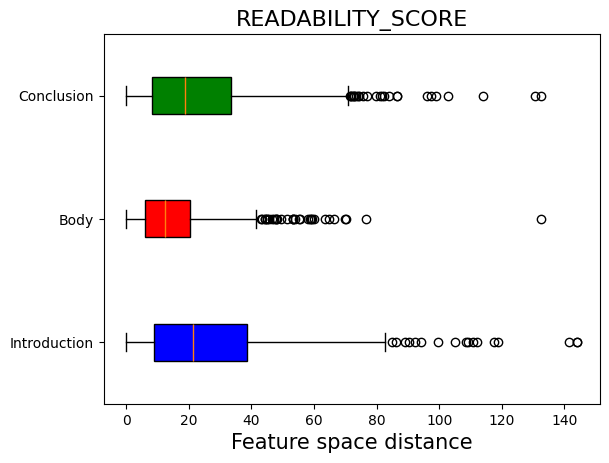

In [ ]:
test_one_way_anova(I, B, C, "READABILITY_SCORE")

                      sum_sq      df           F        PR(>F)
Segment         2.005581e+04     2.0   27.189585  1.696821e-12
Source          3.865756e+04     1.0  104.815845  1.863003e-24
Segment:Source  4.799650e+04     2.0   65.068689  9.055890e-29
Residual        3.109103e+06  8430.0         NaN           NaN
(H>A) I-B:  WilcoxonResult(statistic=425959.5, pvalue=0.9999951172220114)
(H>A) I-C:  WilcoxonResult(statistic=638288.0, pvalue=6.387979038402985e-22)
(H>A) B-C:  WilcoxonResult(statistic=661380.5, pvalue=3.1292411225793676e-28)
--------------------------------------------------
(A>H) I-B:  WilcoxonResult(statistic=560350.5, pvalue=4.882777988656538e-06)
(A>H) I-C:  WilcoxonResult(statistic=348022.0, pvalue=1.0)
(A>H) B-C:  WilcoxonResult(statistic=327740.5, pvalue=1.0)


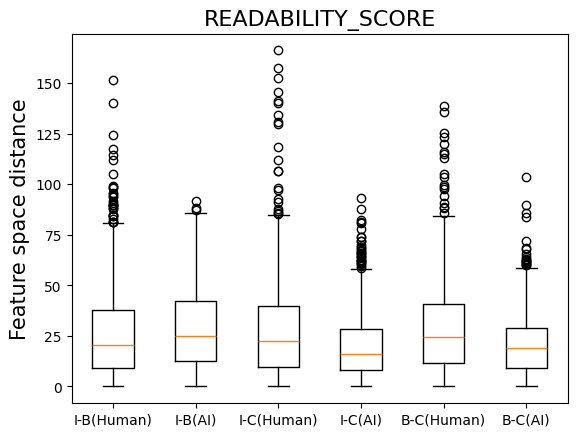

In [ ]:
test_two_way_anova(H_I_B, H_I_C, H_B_C, AI_I_B, AI_I_C, AI_B_C, "READABILITY_SCORE")

### AVG sentiment score

In [ ]:
orig_df = pd.read_csv('enron_feature_list.csv')
mask = (orig_df['intro_polarity_scores'] != '[]') & (orig_df['body_polarity_scores'] != '[]') & (orig_df['conclusion_polarity_scores'] != '[]')
df = orig_df[mask]

In [ ]:
def get_mean_from_column(L):
  means = []
  for s in L:
    d = ast.literal_eval(s)
    means.append(np.average(d))
  return means
intro_col = 'intro_polarity_scores'
body_col = 'body_polarity_scores'
conclusion_col = 'conclusion_polarity_scores'

In [ ]:
h_intro_emd = []
h_body_emd = []
h_conclusion_emd = []
ai_intro_emd = []
ai_body_emd = []
ai_conclusion_emd = []

human_rows = df[df['source'] == 'human']

for i, row in human_rows.iterrows():
  try:
    # Get all rows with the current key but a different source
    key = row['key']
    other_sources = df[(df['key'] == key) & (df['source'] != 'human')]
    # print(other_sources.shape)
    # Sample a row from the other_sources DataFrame
    sampled_row = other_sources.sample(n=1, random_state=42).iloc[0]
    h_intro_emd.append(np.average(ast.literal_eval(row[intro_col])))
    h_body_emd.append(np.average(ast.literal_eval(row[body_col])))
    h_conclusion_emd.append(np.average(ast.literal_eval(row[conclusion_col])))

    ai_intro_emd.append(np.average(ast.literal_eval(sampled_row[intro_col])))
    ai_body_emd.append(np.average(ast.literal_eval(sampled_row[body_col])))
    ai_conclusion_emd.append(np.average(ast.literal_eval(sampled_row[conclusion_col])))
    # I.append(np.abs(row[intro_col]) - sampled_row[intro_col])
    # B.append(np.abs(row[body_col]) - sampled_row[body_col])
    # C.append(np.abs(row[conclusion_col]) - sampled_row[conclusion_col])
  except:
    continue

I  = []
B = []
C = []
for i in range(len(h_intro_emd)):
  I.append(calculate_distance(h_intro_emd[i], ai_intro_emd[i]))
  B.append(calculate_distance(h_body_emd[i], ai_body_emd[i]))
  C.append(calculate_distance(h_conclusion_emd[i], ai_conclusion_emd[i]))

H_I_B, H_I_C, H_B_C, AI_I_B, AI_I_C, AI_B_C = [], [], [], [], [], []
for i in range(len(h_intro_emd)):
  H_I_B.append(calculate_distance(h_intro_emd[i], h_body_emd[i]))
  H_I_C.append(calculate_distance(h_intro_emd[i], h_conclusion_emd[i]))
  H_B_C.append(calculate_distance(h_body_emd[i], h_conclusion_emd[i]))
  AI_I_B.append(calculate_distance(ai_intro_emd[i], ai_body_emd[i]))
  AI_I_C.append(calculate_distance(ai_intro_emd[i], ai_conclusion_emd[i]))
  AI_B_C.append(calculate_distance(ai_body_emd[i], ai_conclusion_emd[i]))


f_value:  608.1500550327443
p_value:  8.935888058910019e-233
I>B:  WilcoxonResult(statistic=381300.5, pvalue=0.9999999941224439)
I>C:  WilcoxonResult(statistic=122665.5, pvalue=1.0)
B>C:  WilcoxonResult(statistic=127015.5, pvalue=1.0)
--------------------------------------------------
B>I:  WilcoxonResult(statistic=546902.5, pvalue=5.8775561248328675e-09)
C>I:  WilcoxonResult(statistic=786560.5, pvalue=1.3620263701501287e-119)
C>B:  WilcoxonResult(statistic=853684.5, pvalue=9.821673366715452e-128)


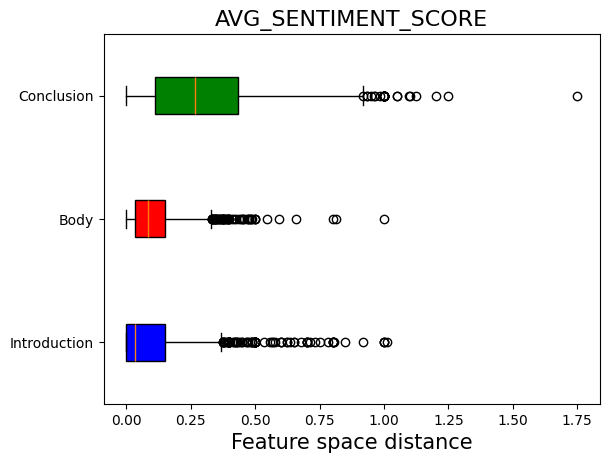

In [ ]:
test_one_way_anova(I, B, C, "AVG_SENTIMENT_SCORE")

                    sum_sq      df           F         PR(>F)
Segment          20.961684     2.0  346.428733  2.579453e-145
Source           25.327024     1.0  837.147330  1.399977e-175
Segment:Source   11.299980     2.0  186.752058   4.365084e-80
Residual        255.040904  8430.0         NaN            NaN
(H>A) I-B:  WilcoxonResult(statistic=411385.5, pvalue=0.9998588477433197)
(H>A) I-C:  WilcoxonResult(statistic=159330.0, pvalue=1.0)
(H>A) B-C:  WilcoxonResult(statistic=191649.0, pvalue=1.0)
--------------------------------------------------
(A>H) I-B:  WilcoxonResult(statistic=516817.5, pvalue=0.00014115225668030808)
(A>H) I-C:  WilcoxonResult(statistic=753946.0, pvalue=9.362266916013099e-96)
(A>H) B-C:  WilcoxonResult(statistic=789051.0, pvalue=4.650514494200689e-87)


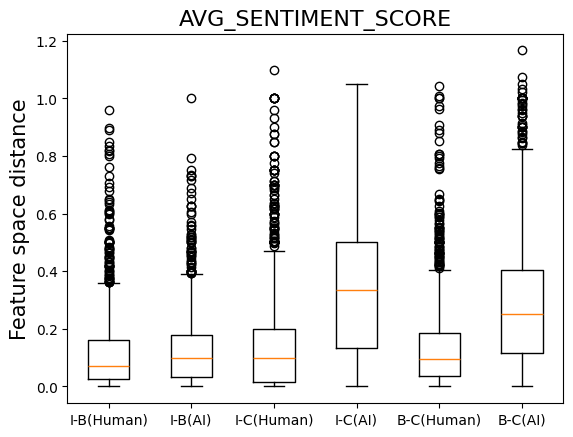

In [ ]:
test_two_way_anova(H_I_B, H_I_C, H_B_C, AI_I_B, AI_I_C, AI_B_C, "AVG_SENTIMENT_SCORE")

### AVG formality score

In [ ]:
orig_df =  pd.read_csv('enron_feature_list.csv')
intro_col = 'intro_formality_score'
body_col = 'body_formality_score'
conclusion_col = 'conclusion_formality_score'
mask = (orig_df[intro_col] != '[]') & (orig_df[body_col] != '[]') & (orig_df[conclusion_col] != '[]')
df = orig_df[mask]
df.shape

(7654, 60)

In [ ]:
h_intro_emd = []
h_body_emd = []
h_conclusion_emd = []
ai_intro_emd = []
ai_body_emd = []
ai_conclusion_emd = []

human_rows = df[df['source'] == 'human']

for i, row in human_rows.iterrows():
  try:
    # Get all rows with the current key but a different source
    key = row['key']
    other_sources = df[(df['key'] == key) & (df['source'] != 'human')]
    # print(other_sources.shape)
    # Sample a row from the other_sources DataFrame
    sampled_row = other_sources.sample(n=1, random_state=42).iloc[0]
    h_intro_emd.append(np.average(ast.literal_eval(row[intro_col])))
    h_body_emd.append(np.average(ast.literal_eval(row[body_col])))
    h_conclusion_emd.append(np.average(ast.literal_eval(row[conclusion_col])))

    ai_intro_emd.append(np.average(ast.literal_eval(sampled_row[intro_col])))
    ai_body_emd.append(np.average(ast.literal_eval(sampled_row[body_col])))
    ai_conclusion_emd.append(np.average(ast.literal_eval(sampled_row[conclusion_col])))
    # I.append(np.abs(row[intro_col]) - sampled_row[intro_col])
    # B.append(np.abs(row[body_col]) - sampled_row[body_col])
    # C.append(np.abs(row[conclusion_col]) - sampled_row[conclusion_col])
  except:
    continue

I  = []
B = []
C = []
for i in range(len(h_intro_emd)):
  I.append(calculate_distance(h_intro_emd[i], ai_intro_emd[i]))
  B.append(calculate_distance(h_body_emd[i], ai_body_emd[i]))
  C.append(calculate_distance(h_conclusion_emd[i], ai_conclusion_emd[i]))

H_I_B, H_I_C, H_B_C, AI_I_B, AI_I_C, AI_B_C = [], [], [], [], [], []
for i in range(len(h_intro_emd)):
  H_I_B.append(calculate_distance(h_intro_emd[i], h_body_emd[i]))
  H_I_C.append(calculate_distance(h_intro_emd[i], h_conclusion_emd[i]))
  H_B_C.append(calculate_distance(h_body_emd[i], h_conclusion_emd[i]))
  AI_I_B.append(calculate_distance(ai_intro_emd[i], ai_body_emd[i]))
  AI_I_C.append(calculate_distance(ai_intro_emd[i], ai_conclusion_emd[i]))
  AI_B_C.append(calculate_distance(ai_body_emd[i], ai_conclusion_emd[i]))


f_value:  77.88021284277828
p_value:  6.123723506264649e-34
I>B:  WilcoxonResult(statistic=647428.5, pvalue=5.1268345983647124e-24)
I>C:  WilcoxonResult(statistic=500601.0, pvalue=0.31205289700102645)
B>C:  WilcoxonResult(statistic=328729.5, pvalue=1.0)
--------------------------------------------------
B>I:  WilcoxonResult(statistic=341692.5, pvalue=1.0)
C>I:  WilcoxonResult(statistic=485709.0, pvalue=0.6879471029989735)
C>B:  WilcoxonResult(statistic=658985.5, pvalue=9.349606205976563e-28)


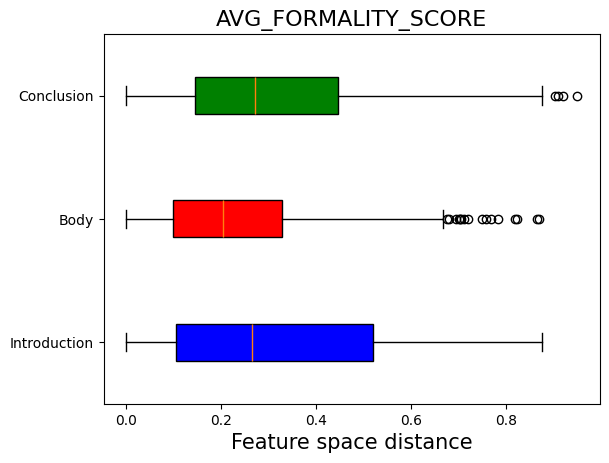

In [ ]:
test_one_way_anova(I, B, C, "AVG_FORMALITY_SCORE")

                    sum_sq      df           F         PR(>F)
Segment           0.523335     2.0    8.931622   1.333981e-04
Source           23.540411     1.0  803.516222  6.448993e-169
Segment:Source    0.166746     2.0    2.845816   5.814267e-02
Residual        246.971574  8430.0         NaN            NaN
(H>A) I-B:  WilcoxonResult(statistic=734061.5, pvalue=1.7787695647047507e-56)
(H>A) I-C:  WilcoxonResult(statistic=746525.5, pvalue=3.4053542678467096e-63)
(H>A) B-C:  WilcoxonResult(statistic=714346.5, pvalue=6.473714343800422e-48)
--------------------------------------------------
(A>H) I-B:  WilcoxonResult(statistic=253653.5, pvalue=1.0)
(A>H) I-C:  WilcoxonResult(statistic=238380.5, pvalue=1.0)
(A>H) B-C:  WilcoxonResult(statistic=273368.5, pvalue=1.0)


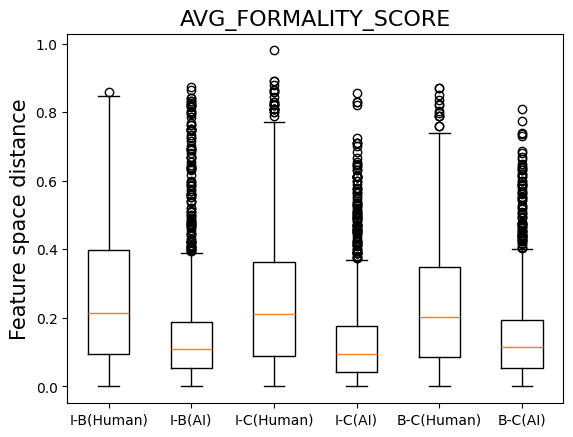

In [ ]:
test_two_way_anova(H_I_B, H_I_C, H_B_C, AI_I_B, AI_I_C, AI_B_C, "AVG_FORMALITY_SCORE")

### AVG surprisal scores

In [ ]:
orig_df = pd.read_csv('enron_feature_list.csv')
mask = (orig_df['intro_perplexity_scores'] != '[]') & (orig_df['body_perplexity_scores'] != '[]') & (orig_df['conclusion_perplexity_scores'] != '[]') & (orig_df['intro_avg_burstiness_score'] != 0) \
& (orig_df['conclusion_avg_burstiness_score'] != 0)  & (orig_df['intro_avg_burstiness_score'] <2000) & (orig_df['conclusion_avg_burstiness_score'] <2000) & (orig_df['body_avg_burstiness_score'] <2000)
df = orig_df[mask]
df.shape

(3398, 20)

In [ ]:
col_name = 'avg_perplexity_score'
intro_col = 'intro_' + col_name
body_col = 'body_' + col_name
conclusion_col = 'conclusion_' + col_name

In [ ]:
h_intro_emd = []
h_body_emd = []
h_conclusion_emd = []
ai_intro_emd = []
ai_body_emd = []
ai_conclusion_emd = []

human_rows = df[df['source'] == 'human']

for i, row in human_rows.iterrows():
  try:
    # Get all rows with the current key but a different source
    key = row['key']
    other_sources = df[(df['key'] == key) & (df['source'] != 'human')]
    # print(other_sources.shape)
    # Sample a row from the other_sources DataFrame
    sampled_row = other_sources.sample(n=1, random_state=42).iloc[0]
    h_intro_emd.append(row[intro_col])
    h_body_emd.append(row[body_col])
    h_conclusion_emd.append(row[conclusion_col])

    ai_intro_emd.append(sampled_row[intro_col])
    ai_body_emd.append(sampled_row[body_col])
    ai_conclusion_emd.append(sampled_row[conclusion_col])
    # I.append(np.abs(row[intro_col]) - sampled_row[intro_col])
    # B.append(np.abs(row[body_col]) - sampled_row[body_col])
    # C.append(np.abs(row[conclusion_col]) - sampled_row[conclusion_col])
  except:
    continue

I  = []
B = []
C = []
for i in range(len(h_intro_emd)):
  I.append(calculate_distance(h_intro_emd[i], ai_intro_emd[i]))
  B.append(calculate_distance(h_body_emd[i], ai_body_emd[i]))
  C.append(calculate_distance(h_conclusion_emd[i], ai_conclusion_emd[i]))

H_I_B, H_I_C, H_B_C, AI_I_B, AI_I_C, AI_B_C = [], [], [], [], [], []
for i in range(len(h_intro_emd)):
  H_I_B.append(calculate_distance(h_intro_emd[i], h_body_emd[i]))
  H_I_C.append(calculate_distance(h_intro_emd[i], h_conclusion_emd[i]))
  H_B_C.append(calculate_distance(h_body_emd[i], h_conclusion_emd[i]))
  AI_I_B.append(calculate_distance(ai_intro_emd[i], ai_body_emd[i]))
  AI_I_C.append(calculate_distance(ai_intro_emd[i], ai_conclusion_emd[i]))
  AI_B_C.append(calculate_distance(ai_body_emd[i], ai_conclusion_emd[i]))


f_value:  18.820395677262816
p_value:  9.066380597670197e-09
I>B:  WilcoxonResult(statistic=42526.5, pvalue=0.003951942557060607)
I>C:  WilcoxonResult(statistic=30467.0, pvalue=0.9985740472077556)
B>C:  WilcoxonResult(statistic=25171.0, pvalue=0.999999969621449)
--------------------------------------------------
B>I:  WilcoxonResult(statistic=31009.5, pvalue=0.9960480574429393)
C>I:  WilcoxonResult(statistic=43453.0, pvalue=0.001425952792244497)
C>B:  WilcoxonResult(statistic=48749.0, pvalue=3.037855104388375e-08)


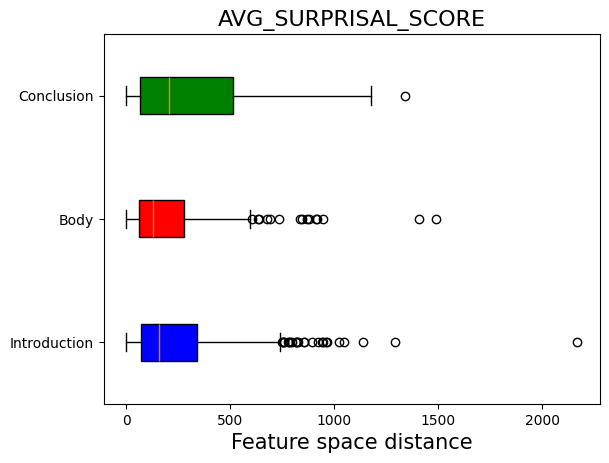

In [ ]:
test_one_way_anova(I, B, C, "AVG_SURPRISAL_SCORE")

                      sum_sq      df          F        PR(>F)
Segment         1.141339e+06     2.0   8.184980  2.870182e-04
Source          2.963165e+06     1.0  42.499997  8.660692e-11
Segment:Source  3.348356e+05     2.0   2.401235  9.083327e-02
Residual        1.602201e+08  2298.0        NaN           NaN
(H>A) I-B:  WilcoxonResult(statistic=33308.0, pvalue=0.9447499267200613)
(H>A) I-C:  WilcoxonResult(statistic=25691.5, pvalue=0.9999998875066343)
(H>A) B-C:  WilcoxonResult(statistic=30837.0, pvalue=0.9975479435932625)
--------------------------------------------------
(A>H) I-B:  WilcoxonResult(statistic=40228.0, pvalue=0.05525007327993871)
(A>H) I-C:  WilcoxonResult(statistic=48228.5, pvalue=1.1249336570555166e-07)
(A>H) B-C:  WilcoxonResult(statistic=43083.0, pvalue=0.002452056406737554)


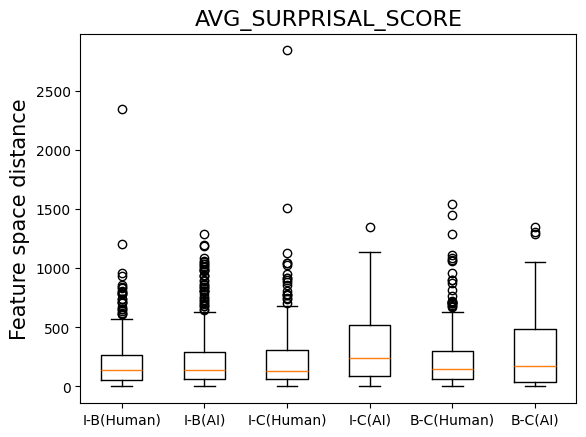

In [ ]:
test_two_way_anova(H_I_B, H_I_C, H_B_C, AI_I_B, AI_I_C, AI_B_C, "AVG_SURPRISAL_SCORE")

### Surprisal scores

In [ ]:
orig_df = pd.read_csv('enron_feature_list.csv')
mask = (orig_df['intro_perplexity_scores'] != '[]') & (orig_df['conclusion_perplexity_scores'] != '[]') & (orig_df['body_perplexity_scores'] != '[]')
df = orig_df[mask]
df.shape

(7655, 20)

In [ ]:
N = 50
from scipy.interpolate import interp1d
def convert_to_fixed_length_time_series(time_series):
    # Create an interpolation function
    x = np.arange(len(time_series))
    f = interp1d(x, time_series, kind='linear')

    # Resample the time series to a fixed length N
    new_x = np.linspace(0, len(time_series) - 1, N)
    new_time_series = f(new_x)
    return new_time_series
def get_fixed_len_perplexity_scores(perplexity_score):
  L = ast.literal_eval(perplexity_score)
  return convert_to_fixed_length_time_series(L)
intro_col = 'intro_perplexity_scores'
body_col = 'body_perplexity_scores'
conclusion_col = 'conclusion_perplexity_scores'
df[intro_col] = df[intro_col].apply(get_fixed_len_perplexity_scores)
df[body_col] = df[body_col].apply(get_fixed_len_perplexity_scores)
df[conclusion_col] = df[conclusion_col].apply(get_fixed_len_perplexity_scores)

In [ ]:
h_intro_emd = []
h_body_emd = []
h_conclusion_emd = []
ai_intro_emd = []
ai_body_emd = []
ai_conclusion_emd = []

human_rows = df[df['source'] == 'human']

for i, row in human_rows.iterrows():
  try:
    # Get all rows with the current key but a different source
    key = row['key']
    other_sources = df[(df['key'] == key) & (df['source'] != 'human')]
    # print(other_sources.shape)
    # Sample a row from the other_sources DataFrame
    sampled_row = other_sources.sample(n=1, random_state=42).iloc[0]
    h_intro_emd.append(row[intro_col])
    h_body_emd.append(row[body_col])
    h_conclusion_emd.append(row[conclusion_col])

    ai_intro_emd.append(sampled_row[intro_col])
    ai_body_emd.append(sampled_row[body_col])
    ai_conclusion_emd.append(sampled_row[conclusion_col])
    # I.append(np.abs(row[intro_col]) - sampled_row[intro_col])
    # B.append(np.abs(row[body_col]) - sampled_row[body_col])
    # C.append(np.abs(row[conclusion_col]) - sampled_row[conclusion_col])
  except:
    continue

I  = []
B = []
C = []
for i in range(len(h_intro_emd)):
  I.append(calculate_distance(h_intro_emd[i], ai_intro_emd[i]))
  B.append(calculate_distance(h_body_emd[i], ai_body_emd[i]))
  C.append(calculate_distance(h_conclusion_emd[i], ai_conclusion_emd[i]))

H_I_B, H_I_C, H_B_C, AI_I_B, AI_I_C, AI_B_C = [], [], [], [], [], []
for i in range(len(h_intro_emd)):
  H_I_B.append(calculate_distance(h_intro_emd[i], h_body_emd[i]))
  H_I_C.append(calculate_distance(h_intro_emd[i], h_conclusion_emd[i]))
  H_B_C.append(calculate_distance(h_body_emd[i], h_conclusion_emd[i]))
  AI_I_B.append(calculate_distance(ai_intro_emd[i], ai_body_emd[i]))
  AI_I_C.append(calculate_distance(ai_intro_emd[i], ai_conclusion_emd[i]))
  AI_B_C.append(calculate_distance(ai_body_emd[i], ai_conclusion_emd[i]))


f_value:  123.01193822882752
p_value:  1.195606845155812e-52
I>B:  WilcoxonResult(statistic=566388.0, pvalue=1.1963604237113362e-06)
I>C:  WilcoxonResult(statistic=281428.0, pvalue=1.0)
B>C:  WilcoxonResult(statistic=232700.0, pvalue=1.0)
--------------------------------------------------
B>I:  WilcoxonResult(statistic=422733.0, pvalue=0.9999988036395763)
C>I:  WilcoxonResult(statistic=707693.0, pvalue=8.145159227395233e-45)
C>B:  WilcoxonResult(statistic=756421.0, pvalue=1.3997786621436389e-66)


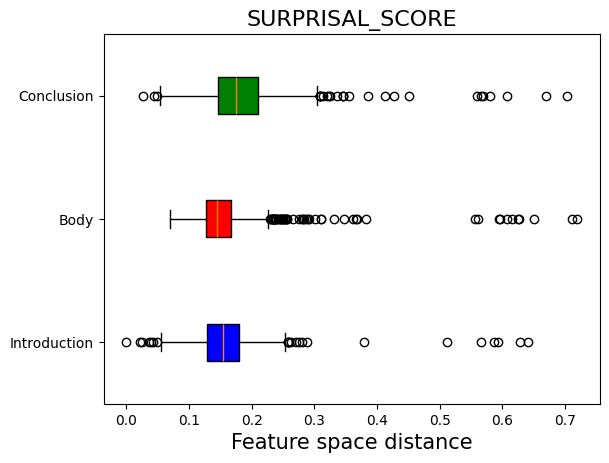

In [ ]:
test_one_way_anova(I, B, C, "SURPRISAL_SCORE")

                   sum_sq      df          F        PR(>F)
Segment          0.445940     2.0  70.492718  4.350965e-31
Source           0.000798     1.0   0.252208  6.155380e-01
Segment:Source   0.621053     2.0  98.174101  7.120128e-43
Residual        26.664253  8430.0        NaN           NaN
(H>A) I-B:  WilcoxonResult(statistic=552407.0, pvalue=7.266916204056131e-05)
(H>A) I-C:  WilcoxonResult(statistic=317529.0, pvalue=1.0)
(H>A) B-C:  WilcoxonResult(statistic=591957.0, pvalue=7.96275398166743e-11)
--------------------------------------------------
(A>H) I-B:  WilcoxonResult(statistic=436714.0, pvalue=0.9999273308379595)
(A>H) I-C:  WilcoxonResult(statistic=671592.0, pvalue=1.5194538187893802e-31)
(A>H) B-C:  WilcoxonResult(statistic=397164.0, pvalue=0.9999999999203725)


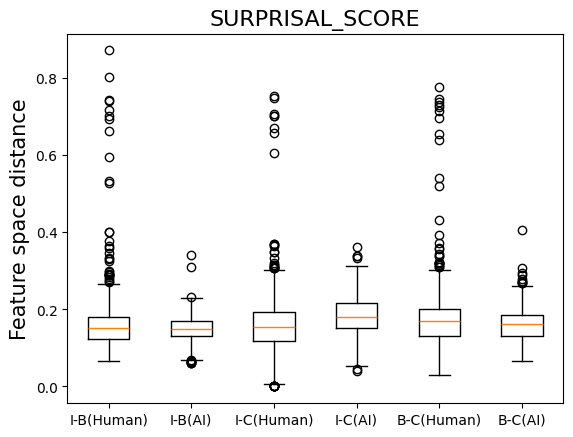

In [ ]:
test_two_way_anova(H_I_B, H_I_C, H_B_C, AI_I_B, AI_I_C, AI_B_C, "SURPRISAL_SCORE")

### Change of content

In [ ]:
!ls

 backups			      enron_mistral_generated_emails.csv
 enron_dataset.csv		      enron_prompts.csv
 enron_differen_versions	      enron_selected.csv
'Enron email data formatting.ipynb'  'Enron Similarity Measurement.ipynb'
 enron_embed_list1.csv		      enron_uid_scores1.csv
 enron_embed_list.csv		      enron_uid_scores.csv
'Enron feature extractions.ipynb'     gemini_email_summary.csv
 enron_feature_list1.csv	      gemini_split_enron.csv
 enron_feature_list.csv		      LADR-2009-11A
 enron_llama_generated_emails.csv     maildir
 enron_llm_data.csv		      Testing.ipynb
 enron_mail_20150507.tar.gz


In [ ]:
df = pd.read_csv('enron_feature_list.csv')
print(df.shape)
df = df.dropna()
df.shape

(7921, 8)


(7641, 8)

In [ ]:
def process_strings(s):
  s = s.replace('\n', '')
  s = s.replace('dtype=float32', '')
  s = s.replace('array(', '')
  s = s.replace(')', '')
  s = s.replace('[', '')
  s = s.replace(']', '')
  return s
def convert_to_traditional_form(text):
    # Split the text by comma to get individual numbers
    text = process_strings(text)
    numbers = text.split(', ')
    traditional_numbers = []
    # Convert each number from scientific notation to traditional form
    for number in numbers:
      try:
        traditional_numbers.append(float(number))
      except:
        continue
    # traditional_numbers = [float(number) for number in numbers[:-1]]
    D = 384
    N = len(traditional_numbers) // D
    array_2d = np.array(traditional_numbers).reshape(N, D)
    return array_2d

def get_content_change(s):
  embeddings = convert_to_traditional_form(s)
  # print(embeddings.shape)
  if len(embeddings)<2: # only one sentence, so we return the value 0.5 as no correlation value
    return 0.5
  n_sentences  = len(embeddings)
  D = []
  # print(n_sentences)
  for i in range(n_sentences-1):
    # print(embeddings[i])
    D.append(cosine_distance(embeddings[i], embeddings[i+1]))
  # print(embeddings.shape, D, np.mean(D))
  return np.mean(D)

def get_avg_content_vector(s):
  embeddings = convert_to_traditional_form(s)
  return np.mean(embeddings, axis=0)

In [ ]:
col_name = 'content_change'
intro_col = 'intro_' + col_name
body_col = 'body_' + col_name
conclusion_col = 'conclusion_' + col_name
df[intro_col] = df['intro_embeddings'].progress_apply(get_content_change)
df[body_col] = df['body_embeddings'].progress_apply(get_content_change)
df[conclusion_col] = df['conclusion_embeddings'].progress_apply(get_content_change)
df.sample(2)

100%|██████████| 7641/7641 [00:09<00:00, 798.67it/s] 


,key,source,intro_text,body_text,conclusion_text,intro_embeddings,body_embeddings,conclusion_embeddings,intro_content_change,body_content_change,conclusion_content_change
2296,Eric Bass_8,text-bison-001,"Hi Celeste,\n\nI'm writing to you with a conce...",I was initially told that I would not be eligi...,"Thank you for your time.\n\nSincerely,\nEric Bass","[array([ 0.03557884, -0.5390964 , 0.3530702 ,...","[array([ 4.43094701e-01, -5.97255230e-02, 1.8...","[array([-3.00583810e-01, 6.82198584e-01, 7.1...",0.50000,0.436357,0.683793
4219,Carol St Clair_208,gpt_3.5,"Hi Christian,\nI hope you're doing well. I wan...","Christian, since you'll be out of pocket from ...",Let me know if you need any further assistance...,"[array([ 5.11822581e-01, -5.04732803e-02, 4.4...","[array([ 2.84522444e-01, 3.70152667e-02, 1.8...","[array([-4.66657020e-02, -4.79866832e-01, 1.1...",0.98868,0.747063,0.782004


In [ ]:
h_intro_emd = []
h_body_emd = []
h_conclusion_emd = []
ai_intro_emd = []
ai_body_emd = []
ai_conclusion_emd = []

human_rows = df[df['source'] == 'human']

for i, row in human_rows.iterrows():
  try:
    # Get all rows with the current key but a different source
    key = row['key']
    other_sources = df[(df['key'] == key) & (df['source'] != 'human')]
    # print(other_sources.shape)
    # Sample a row from the other_sources DataFrame
    sampled_row = other_sources.sample(n=1, random_state=42).iloc[0]
    h_intro_emd.append(row[intro_col])
    h_body_emd.append(row[body_col])
    h_conclusion_emd.append(row[conclusion_col])

    ai_intro_emd.append(sampled_row[intro_col])
    ai_body_emd.append(sampled_row[body_col])
    ai_conclusion_emd.append(sampled_row[conclusion_col])
    # I.append(np.abs(row[intro_col]) - sampled_row[intro_col])
    # B.append(np.abs(row[body_col]) - sampled_row[body_col])
    # C.append(np.abs(row[conclusion_col]) - sampled_row[conclusion_col])
  except:
    continue

I  = []
B = []
C = []
for i in range(len(h_intro_emd)):
  I.append(calculate_distance(h_intro_emd[i], ai_intro_emd[i]))
  B.append(calculate_distance(h_body_emd[i], ai_body_emd[i]))
  C.append(calculate_distance(h_conclusion_emd[i], ai_conclusion_emd[i]))

H_I_B, H_I_C, H_B_C, AI_I_B, AI_I_C, AI_B_C = [], [], [], [], [], []
for i in range(len(h_intro_emd)):
  H_I_B.append(calculate_distance(h_intro_emd[i], h_body_emd[i]))
  H_I_C.append(calculate_distance(h_intro_emd[i], h_conclusion_emd[i]))
  H_B_C.append(calculate_distance(h_body_emd[i], h_conclusion_emd[i]))
  AI_I_B.append(calculate_distance(ai_intro_emd[i], ai_body_emd[i]))
  AI_I_C.append(calculate_distance(ai_intro_emd[i], ai_conclusion_emd[i]))
  AI_B_C.append(calculate_distance(ai_body_emd[i], ai_conclusion_emd[i]))


f_value:  77.41330493299847
p_value:  9.73882810032821e-34
I>B:  WilcoxonResult(statistic=612746.0, pvalue=7.196973984979939e-18)
I>C:  WilcoxonResult(statistic=441532.0, pvalue=0.9692195881620977)
B>C:  WilcoxonResult(statistic=293802.0, pvalue=1.0)
--------------------------------------------------
B>I:  WilcoxonResult(statistic=356782.0, pvalue=1.0)
C>I:  WilcoxonResult(statistic=496233.0, pvalue=0.030780411837902227)
C>B:  WilcoxonResult(statistic=675726.0, pvalue=2.0018354890380066e-37)


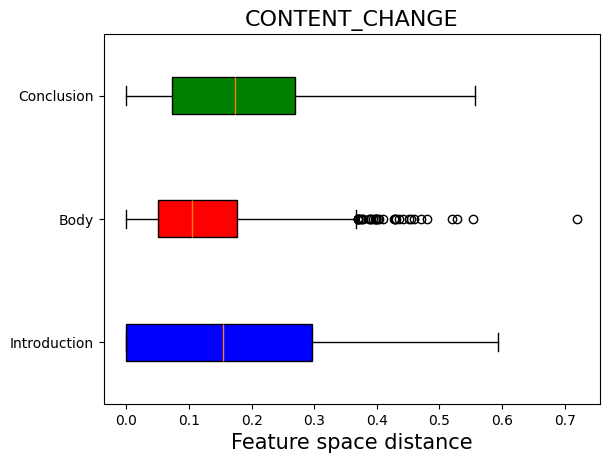

In [ ]:
test_one_way_anova(I, B, C, "CONTENT_CHANGE")

                    sum_sq      df           F        PR(>F)
Segment           1.179871     2.0   38.006992  3.702439e-17
Source            1.552369     1.0  100.012415  2.050791e-23
Segment:Source    0.127984     2.0    4.122716  1.623346e-02
Residual        129.544640  8346.0         NaN           NaN
(H>A) I-B:  WilcoxonResult(statistic=570203.0, pvalue=6.140082154440902e-09)
(H>A) I-C:  WilcoxonResult(statistic=520790.0, pvalue=0.00019411963388079464)
(H>A) B-C:  WilcoxonResult(statistic=609218.0, pvalue=5.351028174509445e-17)
--------------------------------------------------
(A>H) I-B:  WilcoxonResult(statistic=399325.0, pvalue=0.9999999938599179)
(A>H) I-C:  WilcoxonResult(statistic=416975.0, pvalue=0.9998058803661192)
(A>H) B-C:  WilcoxonResult(statistic=360310.0, pvalue=1.0)


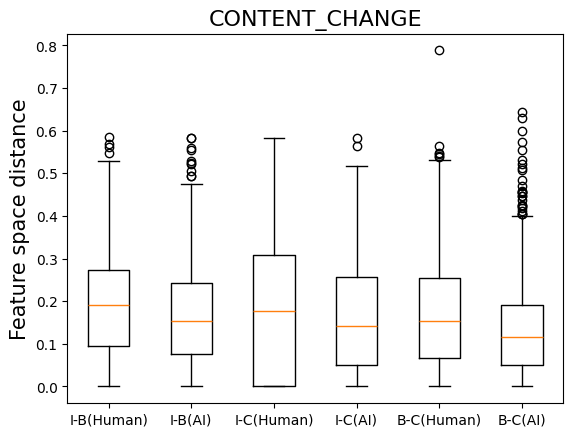

In [ ]:
test_two_way_anova(H_I_B, H_I_C, H_B_C, AI_I_B, AI_I_C, AI_B_C, "CONTENT_CHANGE")

### Content similarity

In [ ]:
col_name = 'content_vector'
intro_col = 'intro_' + col_name
body_col = 'body_' + col_name
conclusion_col = 'conclusion_' + col_name
df[intro_col] = df['intro_embeddings'].progress_apply(get_avg_content_vector)
df[body_col] = df['body_embeddings'].progress_apply(get_avg_content_vector)
df[conclusion_col] = df['conclusion_embeddings'].progress_apply(get_avg_content_vector)
df.sample(2)

100%|██████████| 7641/7641 [00:08<00:00, 929.63it/s] 


,key,source,intro_text,body_text,conclusion_text,intro_embeddings,body_embeddings,conclusion_embeddings,intro_content_change,body_content_change,conclusion_content_change,intro_content_vector,body_content_vector,conclusion_content_vector
7059,Gerald Nemec_53,llama2_chat,"Dear Dan,\nI hope this email finds you well.",I am attaching a draft of the MTG Admin. Agree...,Please let me know if you have any comments or...,"[array([-6.88939035e-01, -6.71346113e-02, 2.7...","[array([-1.04281819e+00, 3.57345194e-01, -2.7...","[array([-4.98527735e-01, 1.52346224e-01, 5.9...",0.5,0.808606,0.771226,"[-0.688939035, -0.0671346113, 0.270378649, -0....","[-0.34211500074999995, 0.09419170325, 0.051720...","[-0.350476779, 0.39495588849999996, 0.17975755..."
1240,Sara Shackleton_365,human,"OK, let me try to catch up here.",Brent may not get my e-mail for awhile. I bel...,This voice stuff is a bummer. Sara,"[array([ 0.3402922 , -0.2844149 , 0.31906724,...","[array([ 4.18934971e-02, -4.55671251e-01, 2.4...","[array([-8.44562501e-02, -4.39441353e-01, 2.8...",0.5,0.670659,0.905955,"[0.3402922, -0.2844149, 0.31906724, -0.1789836...","[0.059376526625, -0.26816664375, 0.1554747735,...","[0.07439834644999999, -0.296661742, 0.17469179..."


In [ ]:
h_intro_emd = []
h_body_emd = []
h_conclusion_emd = []
ai_intro_emd = []
ai_body_emd = []
ai_conclusion_emd = []

human_rows = df[df['source'] == 'human']

for i, row in human_rows.iterrows():
  try:
    # Get all rows with the current key but a different source
    key = row['key']
    other_sources = df[(df['key'] == key) & (df['source'] != 'human')]
    # print(other_sources.shape)
    # Sample a row from the other_sources DataFrame
    sampled_row = other_sources.sample(n=1, random_state=42).iloc[0]
    h_intro_emd.append(row[intro_col])
    h_body_emd.append(row[body_col])
    h_conclusion_emd.append(row[conclusion_col])

    ai_intro_emd.append(sampled_row[intro_col])
    ai_body_emd.append(sampled_row[body_col])
    ai_conclusion_emd.append(sampled_row[conclusion_col])
    # I.append(np.abs(row[intro_col]) - sampled_row[intro_col])
    # B.append(np.abs(row[body_col]) - sampled_row[body_col])
    # C.append(np.abs(row[conclusion_col]) - sampled_row[conclusion_col])
  except:
    continue

I  = []
B = []
C = []
for i in range(len(h_intro_emd)):
  I.append(calculate_distance(h_intro_emd[i], ai_intro_emd[i], method='cosine'))
  B.append(calculate_distance(h_body_emd[i], ai_body_emd[i], method='cosine'))
  C.append(calculate_distance(h_conclusion_emd[i], ai_conclusion_emd[i], method='cosine'))

H_I_B, H_I_C, H_B_C, AI_I_B, AI_I_C, AI_B_C = [], [], [], [], [], []
for i in range(len(h_intro_emd)):
  H_I_B.append(calculate_distance(h_intro_emd[i], h_body_emd[i], method='cosine'))
  H_I_C.append(calculate_distance(h_intro_emd[i], h_conclusion_emd[i], method='cosine'))
  H_B_C.append(calculate_distance(h_body_emd[i], h_conclusion_emd[i], method='cosine'))
  AI_I_B.append(calculate_distance(ai_intro_emd[i], ai_body_emd[i], method='cosine'))
  AI_I_C.append(calculate_distance(ai_intro_emd[i], ai_conclusion_emd[i], method='cosine'))
  AI_B_C.append(calculate_distance(ai_body_emd[i], ai_conclusion_emd[i], method='cosine'))


f_value:  849.6324341349289
p_value:  2.83527247159497e-310
I>B:  WilcoxonResult(statistic=906557.0, pvalue=2.883275683432501e-174)
I>C:  WilcoxonResult(statistic=537580.0, pvalue=0.0002149788757630246)
B>C:  WilcoxonResult(statistic=80025.0, pvalue=1.0)
--------------------------------------------------
B>I:  WilcoxonResult(statistic=62971.0, pvalue=1.0)
C>I:  WilcoxonResult(statistic=431948.0, pvalue=0.999785021124237)
C>B:  WilcoxonResult(statistic=889503.0, pvalue=1.204487616801151e-160)


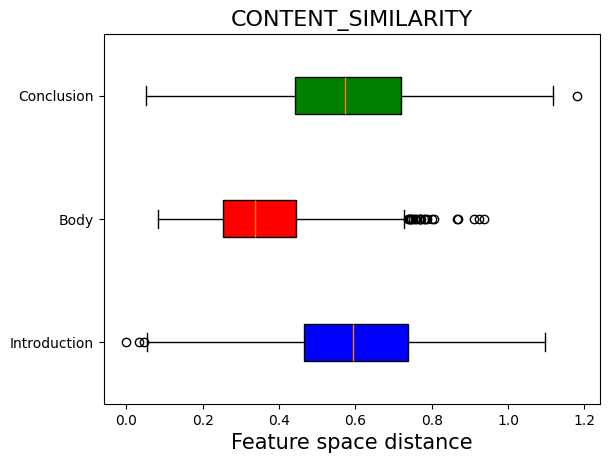

In [ ]:
test_one_way_anova(I, B, C, "CONTENT_SIMILARITY")

                    sum_sq      df           F         PR(>F)
Segment           1.876758     2.0   40.116531   4.579551e-18
Source           16.260386     1.0  695.145676  3.209174e-147
Segment:Source    6.985786     2.0  149.324226   1.917102e-64
Residual        195.224086  8346.0         NaN            NaN
(H>A) I-B:  WilcoxonResult(statistic=551986.0, pvalue=3.7085441612945936e-06)
(H>A) I-C:  WilcoxonResult(statistic=871833.0, pvalue=4.003067347737815e-147)
(H>A) B-C:  WilcoxonResult(statistic=697963.0, pvalue=3.809614414378919e-46)
--------------------------------------------------
(A>H) I-B:  WilcoxonResult(statistic=417542.0, pvalue=0.9999962914558387)
(A>H) I-C:  WilcoxonResult(statistic=97695.0, pvalue=1.0)
(A>H) B-C:  WilcoxonResult(statistic=271565.0, pvalue=1.0)


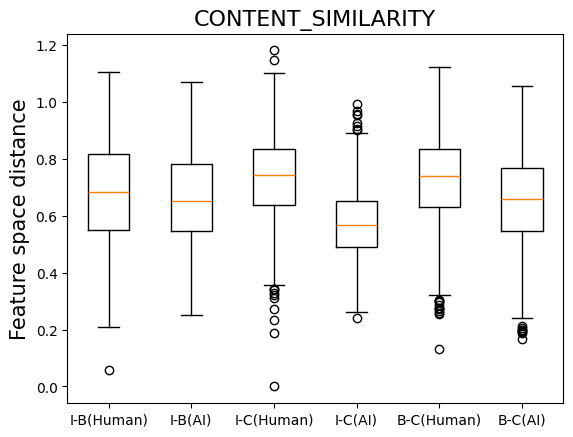

In [ ]:
test_two_way_anova(H_I_B, H_I_C, H_B_C, AI_I_B, AI_I_C, AI_B_C, "CONTENT_SIMILARITY")

### pos tag

In [ ]:
orig_df =  pd.read_csv('enron_feature_list.csv')
pos_tags = ['ADJ', 'ADP', 'ADV', 'AUX', 'CONJ', 'DET', 'INTJ', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SYM', 'VERB', 'X']
pos_tag_counts = Counter({tag: 0 for tag in pos_tags})
pos_tag_str = str(pos_tag_counts)[8:-1]
mask = (orig_df['intro_pos_tag'] != pos_tag_str) & (orig_df['body_pos_tag'] != pos_tag_str) & (orig_df['conclusion_pos_tag'] != pos_tag_str)
df = orig_df[mask]
df.shape

(7655, 60)

In [ ]:
def get_pos_tag_percentage(pos_tag_counts, wc):
  D = ast.literal_eval(pos_tag_counts)
  for k in D.keys():
    D[k] = round(D[k]*100/wc,2)
  return D
intro_col = 'intro_pos_tag'
body_col = 'body_pos_tag'
conclusion_col = 'conclusion_pos_tag'
df['intro_pos_tag'] = df.apply(lambda row: get_pos_tag_percentage(row['intro_pos_tag'], row['intro_word_count']), axis=1)
df['body_pos_tag'] = df.apply(lambda row: get_pos_tag_percentage(row['body_pos_tag'], row['body_word_count']), axis=1)
df['conclusion_pos_tag'] = df.apply(lambda row: get_pos_tag_percentage(row['conclusion_pos_tag'], row['conclusion_word_count']), axis=1)

intro_col = 'intro_pos_tag'
body_col = 'body_pos_tag'
conclusion_col = 'conclusion_pos_tag'
df = df.sample(frac=1)



In [ ]:
h_intro_emd = []
h_body_emd = []
h_conclusion_emd = []
ai_intro_emd = []
ai_body_emd = []
ai_conclusion_emd = []
human_rows = df[df['source'] == 'human']

for i, row in human_rows.iterrows():
  try:
    # Get all rows with the current key but a different source
    key = row['key']
    other_sources = df[(df['key'] == key) & (df['source'] != 'human')]
    # print(other_sources.shape)
    # Sample a row from the other_sources DataFrame
    sampled_row = other_sources.sample(n=1, random_state=42).iloc[0]

    h_intro_emd.append(list(row[intro_col].values())[:len(pos_tags)])
    h_body_emd.append(list(row[body_col].values())[:len(pos_tags)])
    h_conclusion_emd.append(list(row[conclusion_col].values())[:len(pos_tags)])
    # print(h_intro_emd.shape, h_body_emd.shape, h_conclusion_emd.shape)



    ai_intro_emd.append(list(sampled_row[intro_col].values())[:len(pos_tags)])
    ai_body_emd.append(list(sampled_row[body_col].values())[:len(pos_tags)])
    ai_conclusion_emd.append(list(sampled_row[conclusion_col].values())[:len(pos_tags)])

  except:
    continue

I  = []
B = []
C = []
for i in range(len(h_intro_emd)):
  I.append(calculate_distance(h_intro_emd[i], ai_intro_emd[i]))
  B.append(calculate_distance(h_body_emd[i], ai_body_emd[i]))
  C.append(calculate_distance(h_conclusion_emd[i], ai_conclusion_emd[i]))

f_value:  1115.7589896251861
p_value:  0.0
I-B:  WilcoxonResult(statistic=943001.0, pvalue=6.287550529683571e-191)
I-C:  WilcoxonResult(statistic=534192.0, pvalue=0.0034592142016973406)
B-C:  WilcoxonResult(statistic=32462.0, pvalue=1.0)


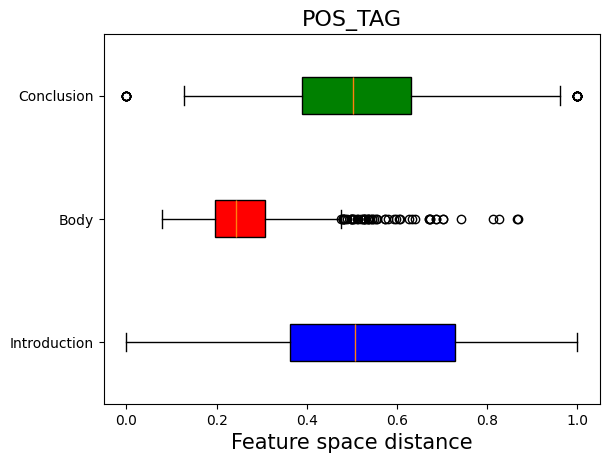

In [ ]:
test_one_way_anova(I, B, C, "POS_TAG")

In [ ]:
H_I_B, H_I_C, H_B_C, AI_I_B, AI_I_C, AI_B_C = [], [], [], [], [], []
for i in range(len(h_intro_emd)):
  H_I_B.append(calculate_distance(h_intro_emd[i], h_body_emd[i]))
  H_I_C.append(calculate_distance(h_intro_emd[i], h_conclusion_emd[i]))
  H_B_C.append(calculate_distance(h_body_emd[i], h_conclusion_emd[i]))
  AI_I_B.append(calculate_distance(ai_intro_emd[i], ai_body_emd[i]))
  AI_I_C.append(calculate_distance(ai_intro_emd[i], ai_conclusion_emd[i]))
  AI_B_C.append(calculate_distance(ai_body_emd[i], ai_conclusion_emd[i]))


                    sum_sq      df           F        PR(>F)
Segment           5.184405     2.0   78.647550  1.440634e-34
Source            4.740599     1.0  143.830015  7.159167e-33
Segment:Source    1.448392     2.0   21.972135  3.036747e-10
Residual        277.850578  8430.0         NaN           NaN
I-B:  WilcoxonResult(statistic=524237.0, pvalue=0.025652566547430002)
I-C:  WilcoxonResult(statistic=653048.0, pvalue=1.8359970538755444e-26)
B-C:  WilcoxonResult(statistic=658079.0, pvalue=3.352426643780593e-27)


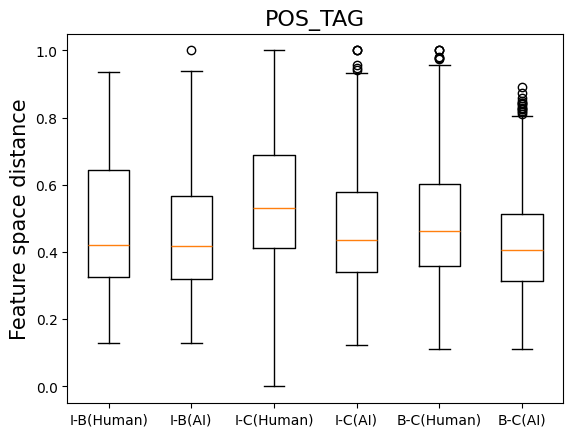

In [ ]:
test_two_way_anova(H_I_B, H_I_C, H_B_C, AI_I_B, AI_I_C, AI_B_C, "POS_TAG")

### NER tags

In [ ]:

ner_tags =  ['PERSON', 'NORP', 'FAC', 'ORG', 'GPE', 'LOC', 'PRODUCT', 'EVENT', 'WORK_OF_ART', 'LAW', 'LANGUAGE', 'DATE', 'TIME', 'PERCENT', 'MONEY', 'QUANTITY', 'ORDINAL', 'CARDINAL']
ner_tag_counts = Counter({tag: 0 for tag in ner_tags})
ner_tag_str = str(ner_tag_counts)[8:-1]
mask = (orig_df['intro_ner_tags'] != ner_tag_str) & (orig_df['body_ner_tags'] != ner_tag_str) & (orig_df['conclusion_ner_tags'] != ner_tag_str)
df = orig_df[mask]
def get_ner_tag_percentage(ner_tag_counts, wc):
  D = ast.literal_eval(ner_tag_counts)
  for k in D.keys():
    D[k] = round(D[k]*100/wc,2)
  return D
intro_col = 'intro_ner_tags'
body_col = 'body_ner_tags'
conclusion_col = 'conclusion_ner_tags'
df['intro_ner_tags'] = df.apply(lambda row: get_ner_tag_percentage(row['intro_ner_tags'], row['intro_word_count']), axis=1)
df['body_ner_tags'] = df.apply(lambda row: get_ner_tag_percentage(row['body_ner_tags'], row['body_word_count']), axis=1)
df['conclusion_ner_tags'] = df.apply(lambda row: get_ner_tag_percentage(row['conclusion_ner_tags'], row['conclusion_word_count']), axis=1)

In [ ]:
h_intro_emd = []
h_body_emd = []
h_conclusion_emd = []
ai_intro_emd = []
ai_body_emd = []
ai_conclusion_emd = []
human_rows = df[df['source'] == 'human']

for i, row in human_rows.iterrows():
  try:
    # Get all rows with the current key but a different source
    key = row['key']
    other_sources = df[(df['key'] == key) & (df['source'] != 'human')]
    # print(other_sources.shape)
    # Sample a row from the other_sources DataFrame
    sampled_row = other_sources.sample(n=1, random_state=42).iloc[0]

    h_intro_emd.append(list(row[intro_col].values())[:len(pos_tags)])
    h_body_emd.append(list(row[body_col].values())[:len(pos_tags)])
    h_conclusion_emd.append(list(row[conclusion_col].values())[:len(pos_tags)])
    # print(h_intro_emd.shape, h_body_emd.shape, h_conclusion_emd.shape)



    ai_intro_emd.append(list(sampled_row[intro_col].values())[:len(pos_tags)])
    ai_body_emd.append(list(sampled_row[body_col].values())[:len(pos_tags)])
    ai_conclusion_emd.append(list(sampled_row[conclusion_col].values())[:len(pos_tags)])

  except:
    continue

I  = []
B = []
C = []
for i in range(len(h_intro_emd)):
  I.append(calculate_distance(h_intro_emd[i], ai_intro_emd[i]))
  B.append(calculate_distance(h_body_emd[i], ai_body_emd[i]))
  C.append(calculate_distance(h_conclusion_emd[i], ai_conclusion_emd[i]))

In [ ]:
C

[0.14394735018022423,
 0.7716458075506889,
 0.8089584726358167,
 0.4368918683394204,
 1.0,
 0.7407188350052051,
 0.7336844145674856,
 0.5579230452841438,
 0.0,
 0.5570991107463582,
 0.2208957688490176,
 0.4556411274289413,
 0.48281293851614837,
 0.4352791471479427,
 0.6521377057902368,
 0.7132500784348472,
 1.0,
 0.43689186833942056,
 0.3292571451323525,
 0.6774119454589219,
 0.7406158568142615,
 0.39053168476875993,
 0.740806952380577,
 1.0,
 0.8800418507273634,
 0.6368538865031064,
 1.0,
 1.0,
 0.5579230452841438,
 0.5579230452841438,
 0.46404815118132975,
 1.0,
 0.0008007240525042048,
 1.0,
 0.7071067811865476,
 0.5698858283164411,
 0.3023948260753148,
 0.7356009681464298,
 1.0,
 0.740806952380577,
 0.3945985817625029,
 0.0,
 0.3294496932119941,
 0,
 0.5579230452841438,
 1.0,
 0.4364883535221759,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.8303791722523595,
 1.0,
 0.5579230452841438,
 0.5579230452841438,
 1.0,
 1.0,
 0.6779244301235926,
 0.0,
 0.6776045432457228,
 1.0,
 0.35230172109128904,
 0

f_value:  1.9532842159376242
p_value:  0.14206439892513315
I-B:  WilcoxonResult(statistic=128216.5, pvalue=0.004083888444818169)
I-C:  WilcoxonResult(statistic=91015.5, pvalue=0.09683174458713423)
B-C:  WilcoxonResult(statistic=106702.0, pvalue=0.7518200787655217)


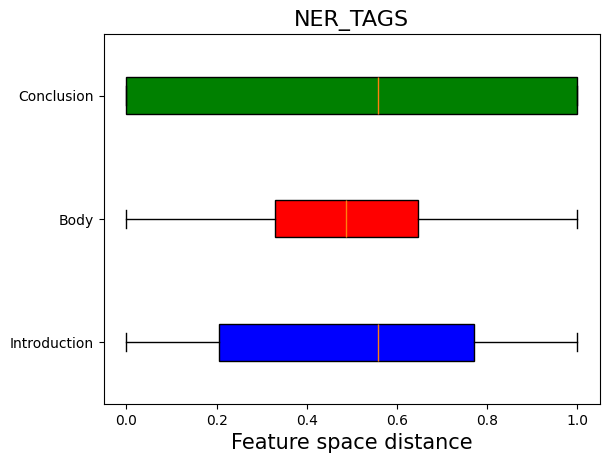

In [ ]:
test_one_way_anova(I, B, C, "NER_TAGS")

In [ ]:
H_I_B, H_I_C, H_B_C, AI_I_B, AI_I_C, AI_B_C = [], [], [], [], [], []
for i in range(len(h_intro_emd)):
  H_I_B.append(calculate_distance(h_intro_emd[i], h_body_emd[i]))
  H_I_C.append(calculate_distance(h_intro_emd[i], h_conclusion_emd[i]))
  H_B_C.append(calculate_distance(h_body_emd[i], h_conclusion_emd[i]))
  AI_I_B.append(calculate_distance(ai_intro_emd[i], ai_body_emd[i]))
  AI_I_C.append(calculate_distance(ai_intro_emd[i], ai_conclusion_emd[i]))
  AI_B_C.append(calculate_distance(ai_body_emd[i], ai_conclusion_emd[i]))


                    sum_sq      df           F        PR(>F)
Segment          22.154699     2.0  116.447373  5.973259e-50
Source            1.570543     1.0   16.509868  4.927918e-05
Segment:Source    8.021643     2.0   42.162579  7.411550e-19
Residual        400.677098  4212.0         NaN           NaN
I-B:  WilcoxonResult(statistic=104486.5, pvalue=0.22319106429821184)
I-C:  WilcoxonResult(statistic=112275.5, pvalue=8.939247741005099e-16)
B-C:  WilcoxonResult(statistic=73711.0, pvalue=0.9999671830478589)


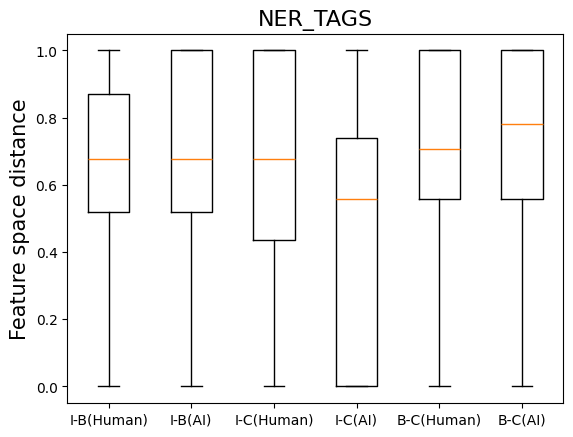

In [ ]:
test_two_way_anova(H_I_B, H_I_C, H_B_C, AI_I_B, AI_I_C, AI_B_C, "NER_TAGS")

### Stopwords

In [ ]:

mask = (orig_df['intro_stopwords'] != '{}') & (orig_df['body_stopwords'] != '{}') & (orig_df['conclusion_stopwords'] != '{}')
df = orig_df[mask]
def get_percentage_of_stopwords_count(s,wc):
  D = ast.literal_eval(s)
  counter = Counter(D)
  total_sum = sum(counter.values())
  return round(total_sum*100/wc,2)

intro_col = 'intro_stopwords'
body_col = 'body_stopwords'
conclusion_col = 'conclusion_stopwords'
df['intro_stopwords_frac'] = df.apply(lambda row: get_percentage_of_stopwords_count(row[intro_col], row['intro_word_count']), axis=1)
df['body_stopwords_frac'] = df.apply(lambda row: get_percentage_of_stopwords_count(row[body_col], row['body_word_count']), axis=1)
df['conclusion_stopwords_frac'] = df.apply(lambda row: get_percentage_of_stopwords_count(row[conclusion_col], row['conclusion_word_count']), axis=1)

In [ ]:
D = {}
for  index,row in df.iterrows():
  d = ast.literal_eval(row['intro_stopwords'])
  for k in d:
    if k not in D:
      D[k] = d[k]
    else:
      D[k] += d[k]
  d = ast.literal_eval(row['body_stopwords'])
  for k in d:
    if k not in D:
      D[k] = d[k]
    else:
      D[k] += d[k]
  d = ast.literal_eval(row['conclusion_stopwords'])
  for k in d:
    if k not in D:
      D[k] = d[k]
    else:
      D[k] += d[k]
  # print(d)
  # break

In [ ]:
total_counts = Counter(D)
K = 20
top_K_values = total_counts.most_common(K)
TOP_STOPWORDS = [item for item, _ in top_K_values]
stopwords_tags = TOP_STOPWORDS
print(stopwords_tags)

['the', 'to', 'i', 'and', 'you', 'a', 'of', 'this', 'for', 'in', 'that', 'with', 'we', 'on', 'have', 'be', 'your', 'is', 'our', 'it']


In [ ]:
def get_percentage_of_top_stopwords(s,wc):
  D = ast.literal_eval(s)
  top_D = {}
  for d in stopwords_tags:
    if d not in D: top_D[d] = 0
    else: top_D[d] = round(D[d]*100/wc,2)
  return top_D

intro_col = 'intro_stopwords'
body_col = 'body_stopwords'
conclusion_col = 'conclusion_stopwords'
df[intro_col] = df.apply(lambda row: get_percentage_of_top_stopwords(row[intro_col], row['intro_word_count']), axis=1)
df[body_col] = df.apply(lambda row: get_percentage_of_top_stopwords(row[body_col], row['body_word_count']), axis=1)
df[conclusion_col] = df.apply(lambda row: get_percentage_of_top_stopwords(row[conclusion_col], row['conclusion_word_count']), axis=1)

In [ ]:
h_intro_emd = []
h_body_emd = []
h_conclusion_emd = []
ai_intro_emd = []
ai_body_emd = []
ai_conclusion_emd = []
human_rows = df[df['source'] == 'human']

for i, row in human_rows.iterrows():
  try:
    # Get all rows with the current key but a different source
    key = row['key']
    other_sources = df[(df['key'] == key) & (df['source'] != 'human')]
    # print(other_sources.shape)
    # Sample a row from the other_sources DataFrame
    sampled_row = other_sources.sample(n=1, random_state=42).iloc[0]

    h_intro_emd.append(list(row[intro_col].values())[:len(pos_tags)])
    h_body_emd.append(list(row[body_col].values())[:len(pos_tags)])
    h_conclusion_emd.append(list(row[conclusion_col].values())[:len(pos_tags)])
    # print(h_intro_emd.shape, h_body_emd.shape, h_conclusion_emd.shape)



    ai_intro_emd.append(list(sampled_row[intro_col].values())[:len(pos_tags)])
    ai_body_emd.append(list(sampled_row[body_col].values())[:len(pos_tags)])
    ai_conclusion_emd.append(list(sampled_row[conclusion_col].values())[:len(pos_tags)])

  except:
    continue

I  = []
B = []
C = []
for i in range(len(h_intro_emd)):
  I.append(calculate_distance(h_intro_emd[i], ai_intro_emd[i]))
  B.append(calculate_distance(h_body_emd[i], ai_body_emd[i]))
  C.append(calculate_distance(h_conclusion_emd[i], ai_conclusion_emd[i]))

f_value:  394.5658339943829
p_value:  7.531434361914248e-152
I-B:  WilcoxonResult(statistic=404344.0, pvalue=5.326020555474683e-105)
I-C:  WilcoxonResult(statistic=208128.5, pvalue=0.7528599165534202)
B-C:  WilcoxonResult(statistic=54353.0, pvalue=1.0)


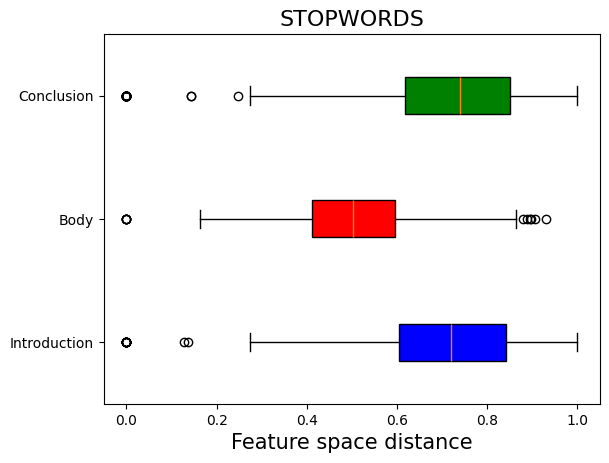

In [ ]:
test_one_way_anova(I, B, C, "STOPWORDS")

In [ ]:
H_I_B, H_I_C, H_B_C, AI_I_B, AI_I_C, AI_B_C = [], [], [], [], [], []
for i in range(len(h_intro_emd)):
  H_I_B.append(calculate_distance(h_intro_emd[i], h_body_emd[i]))
  H_I_C.append(calculate_distance(h_intro_emd[i], h_conclusion_emd[i]))
  H_B_C.append(calculate_distance(h_body_emd[i], h_conclusion_emd[i]))
  AI_I_B.append(calculate_distance(ai_intro_emd[i], ai_body_emd[i]))
  AI_I_C.append(calculate_distance(ai_intro_emd[i], ai_conclusion_emd[i]))
  AI_B_C.append(calculate_distance(ai_body_emd[i], ai_conclusion_emd[i]))


                    sum_sq      df          F        PR(>F)
Segment           1.370276     2.0  21.342929  5.830558e-10
Source            1.539416     1.0  47.954787  4.846112e-12
Segment:Source    2.454364     2.0  38.228296  3.228139e-17
Residual        181.437130  5652.0        NaN           NaN
I-B:  WilcoxonResult(statistic=205374.0, pvalue=0.9799546176449416)
I-C:  WilcoxonResult(statistic=317732.0, pvalue=3.635420038732478e-34)
B-C:  WilcoxonResult(statistic=273266.5, pvalue=5.194328945591121e-11)


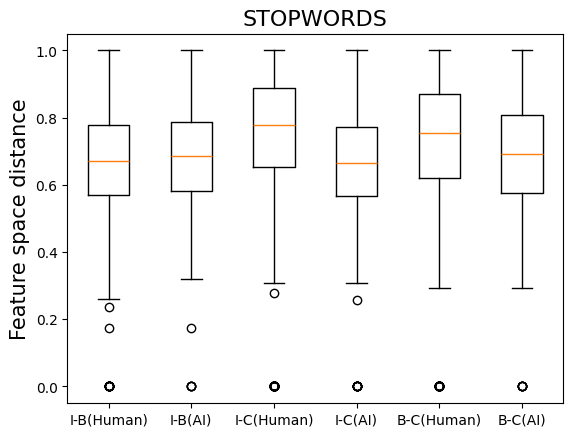

In [ ]:
test_two_way_anova(H_I_B, H_I_C, H_B_C, AI_I_B, AI_I_C, AI_B_C, "STOPWORDS")

## Persuade

In [ ]:
import os
os.chdir("/content/drive/My Drive/PSU/text_variation_and_chess/persuade_data")
!pwd

/content/drive/My Drive/PSU/text_variation_and_chess/persuade_data


In [ ]:
orig_df =  pd.read_csv('persuade_feature_list.csv')
def truncate_key(key_val):
  return key_val[:key_val.find('_')]
orig_df['key'] = orig_df['key'].apply(truncate_key)

### VOC_richness

In [ ]:
col_name = 'brunet_idx'
intro_col = 'intro_' + col_name
body_col = 'body_' + col_name
conclusion_col = 'conclusion_' + col_name
mask = (orig_df[intro_col] != 0) & (orig_df[body_col] != 0) & (orig_df[conclusion_col] != 0) & (orig_df[intro_col] != 1) & (orig_df[body_col] != 1) & (orig_df[conclusion_col] != 1)
df = orig_df[mask]
df.shape

(5422, 60)

In [ ]:
h_intro_emd = []
h_body_emd = []
h_conclusion_emd = []
ai_intro_emd = []
ai_body_emd = []
ai_conclusion_emd = []

human_rows = df[df['source'] == 'human']

for i, row in human_rows.iterrows():
  try:
    # Get all rows with the current key but a different source
    key = row['key']
    other_sources = df[(df['key'] == key) & (df['source'] != 'human')]
    # print(other_sources.shape)
    # Sample a row from the other_sources DataFrame
    sampled_row = other_sources.sample(n=1).iloc[0]
    h_intro_emd.append(row[intro_col])
    h_body_emd.append(row[body_col])
    h_conclusion_emd.append(row[conclusion_col])

    ai_intro_emd.append(sampled_row[intro_col])
    ai_body_emd.append(sampled_row[body_col])
    ai_conclusion_emd.append(sampled_row[conclusion_col])
    # I.append(np.abs(row[intro_col]) - sampled_row[intro_col])
    # B.append(np.abs(row[body_col]) - sampled_row[body_col])
    # C.append(np.abs(row[conclusion_col]) - sampled_row[conclusion_col])
  except:
    continue

I  = []
B = []
C = []
for i in range(len(h_intro_emd)):
  I.append(calculate_distance(h_intro_emd[i], ai_intro_emd[i]))
  B.append(calculate_distance(h_body_emd[i], ai_body_emd[i]))
  C.append(calculate_distance(h_conclusion_emd[i], ai_conclusion_emd[i]))

H_I_B, H_I_C, H_B_C, AI_I_B, AI_I_C, AI_B_C = [], [], [], [], [], []
for i in range(len(h_intro_emd)):
  H_I_B.append(calculate_distance(h_intro_emd[i], h_body_emd[i]))
  H_I_C.append(calculate_distance(h_intro_emd[i], h_conclusion_emd[i]))
  H_B_C.append(calculate_distance(h_body_emd[i], h_conclusion_emd[i]))
  AI_I_B.append(calculate_distance(ai_intro_emd[i], ai_body_emd[i]))
  AI_I_C.append(calculate_distance(ai_intro_emd[i], ai_conclusion_emd[i]))
  AI_B_C.append(calculate_distance(ai_body_emd[i], ai_conclusion_emd[i]))


f_value:  446.2604218217787
p_value:  3.2576320282174456e-179
I>B:  WilcoxonResult(statistic=229375.0, pvalue=1.0)
I>C:  WilcoxonResult(statistic=479931.0, pvalue=1.0)
B>C:  WilcoxonResult(statistic=1026427.0, pvalue=5.803751828993369e-56)
--------------------------------------------------
B>I:  WilcoxonResult(statistic=1194453.0, pvalue=9.056213240225174e-129)
C>I:  WilcoxonResult(statistic=943897.0, pvalue=2.2462235935996376e-31)
C>B:  WilcoxonResult(statistic=397401.0, pvalue=1.0)


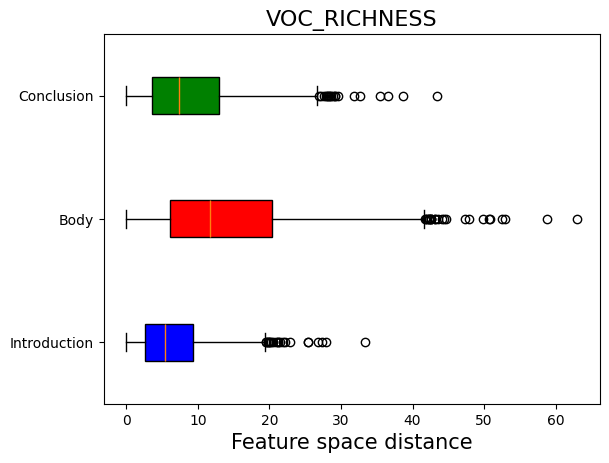

In [ ]:
test_one_way_anova(I, B, C, "VOC_RICHNESS")

                      sum_sq       df            F        PR(>F)
Segment         3.282658e+05      2.0  1597.767325  0.000000e+00
Source          2.320633e+03      1.0    22.590426  2.032447e-06
Segment:Source  1.315855e+04      2.0    64.046576  2.288527e-28
Residual        1.039180e+06  10116.0          NaN           NaN
(H>A) I-B:  WilcoxonResult(statistic=740416.0, pvalue=0.07718037828306498)
(H>A) I-C:  WilcoxonResult(statistic=553126.0, pvalue=0.999999999999999)
(H>A) B-C:  WilcoxonResult(statistic=893093.0, pvalue=6.901333672722239e-20)
--------------------------------------------------
(A>H) I-B:  WilcoxonResult(statistic=683412.0, pvalue=0.922819621716935)
(A>H) I-C:  WilcoxonResult(statistic=870702.0, pvalue=1.0531403782441523e-15)
(A>H) B-C:  WilcoxonResult(statistic=530735.0, pvalue=1.0)


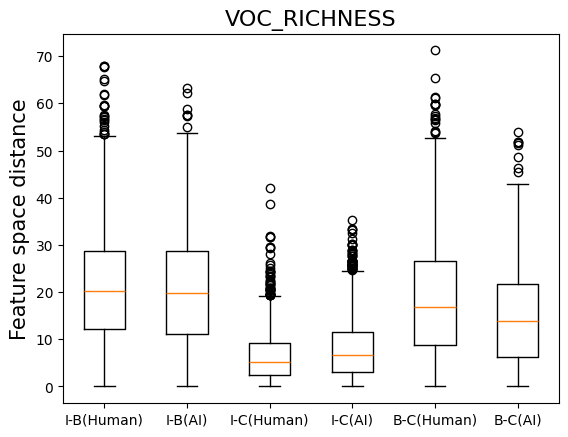

In [ ]:
test_two_way_anova(H_I_B, H_I_C, H_B_C, AI_I_B, AI_I_C, AI_B_C, "VOC_RICHNESS")

### readability score

In [ ]:
score_name = 'flesch_reading_ease'
col_name = 'reading_scores'
intro_col = 'intro_' + col_name
body_col = 'body_' + col_name
conclusion_col = 'conclusion_' + col_name
mask = (orig_df['intro_reading_scores'] != '{}') & (orig_df['body_reading_scores'] != '{}') & (orig_df['conclusion_reading_scores'] != '{}')
df = orig_df[mask]

In [ ]:
h_intro_emd = []
h_body_emd = []
h_conclusion_emd = []
ai_intro_emd = []
ai_body_emd = []
ai_conclusion_emd = []

human_rows = df[df['source'] == 'human']

for i, row in human_rows.iterrows():
  try:
    # Get all rows with the current key but a different source
    key = row['key']
    other_sources = df[(df['key'] == key) & (df['source'] != 'human')]
    # print(other_sources.shape)
    # Sample a row from the other_sources DataFrame
    sampled_row = other_sources.sample(n=1, ).iloc[0]
    h_intro_emd.append(ast.literal_eval(row[intro_col])[score_name])
    h_body_emd.append(ast.literal_eval(row[body_col])[score_name])
    h_conclusion_emd.append(ast.literal_eval(row[conclusion_col])[score_name])

    ai_intro_emd.append(ast.literal_eval(sampled_row[intro_col])[score_name])
    ai_body_emd.append(ast.literal_eval(sampled_row[body_col])[score_name])
    ai_conclusion_emd.append(ast.literal_eval(sampled_row[conclusion_col])[score_name])
    # I.append(np.abs(row[intro_col]) - sampled_row[intro_col])
    # B.append(np.abs(row[body_col]) - sampled_row[body_col])
    # C.append(np.abs(row[conclusion_col]) - sampled_row[conclusion_col])
  except:
    continue

I  = []
B = []
C = []
for i in range(len(h_intro_emd)):
  I.append(calculate_distance(h_intro_emd[i], ai_intro_emd[i]))
  B.append(calculate_distance(h_body_emd[i], ai_body_emd[i]))
  C.append(calculate_distance(h_conclusion_emd[i], ai_conclusion_emd[i]))

H_I_B, H_I_C, H_B_C, AI_I_B, AI_I_C, AI_B_C = [], [], [], [], [], []
for i in range(len(h_intro_emd)):
  H_I_B.append(calculate_distance(h_intro_emd[i], h_body_emd[i]))
  H_I_C.append(calculate_distance(h_intro_emd[i], h_conclusion_emd[i]))
  H_B_C.append(calculate_distance(h_body_emd[i], h_conclusion_emd[i]))
  AI_I_B.append(calculate_distance(ai_intro_emd[i], ai_body_emd[i]))
  AI_I_C.append(calculate_distance(ai_intro_emd[i], ai_conclusion_emd[i]))
  AI_B_C.append(calculate_distance(ai_body_emd[i], ai_conclusion_emd[i]))


f_value:  44.62532995276882
p_value:  6.137272161534348e-20
I>B:  WilcoxonResult(statistic=829752.5, pvalue=7.914323457763691e-09)
I>C:  WilcoxonResult(statistic=584660.0, pvalue=0.999999999969476)
B>C:  WilcoxonResult(statistic=440543.5, pvalue=1.0)
--------------------------------------------------
B>I:  WilcoxonResult(statistic=602525.5, pvalue=0.9999999920856766)
C>I:  WilcoxonResult(statistic=847618.0, pvalue=3.052400611811563e-11)
C>B:  WilcoxonResult(statistic=990042.5, pvalue=6.588397950545578e-43)


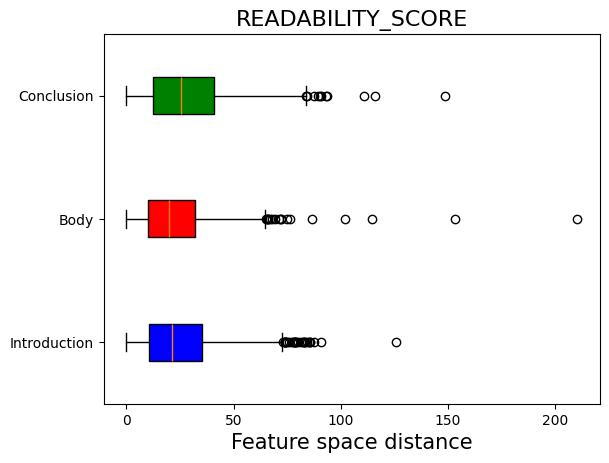

In [ ]:
test_one_way_anova(I, B, C, "READABILITY_SCORE")

                      sum_sq       df          F        PR(>F)
Segment         1.014146e+04      2.0  42.078018  6.325871e-19
Source          1.194224e+03      1.0   9.909936  1.648651e-03
Segment:Source  3.606688e+02      2.0   1.496454  2.239721e-01
Residual        1.222672e+06  10146.0        NaN           NaN
(H>A) I-B:  WilcoxonResult(statistic=770816.5, pvalue=0.0028481202523605123)
(H>A) I-C:  WilcoxonResult(statistic=703568.5, pvalue=0.7203283929165933)
(H>A) B-C:  WilcoxonResult(statistic=730241.0, pvalue=0.20327509079081407)
--------------------------------------------------
(A>H) I-B:  WilcoxonResult(statistic=659769.5, pvalue=0.9971518797476395)
(A>H) I-C:  WilcoxonResult(statistic=727017.5, pvalue=0.27967160708340666)
(A>H) B-C:  WilcoxonResult(statistic=696964.0, pvalue=0.7967249092091859)


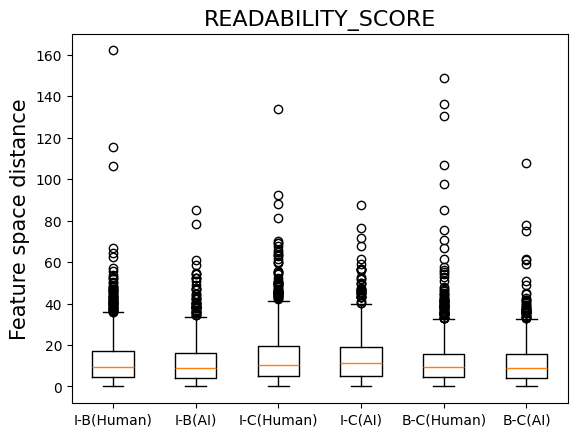

In [ ]:
test_two_way_anova(H_I_B, H_I_C, H_B_C, AI_I_B, AI_I_C, AI_B_C, "READABILITY_SCORE")

### AVG sentiment score

In [ ]:
mask = (orig_df['intro_polarity_scores'] != '[]') & (orig_df['body_polarity_scores'] != '[]') & (orig_df['conclusion_polarity_scores'] != '[]')
df = orig_df[mask]

In [ ]:
def get_mean_from_column(L):
  means = []
  for s in L:
    d = ast.literal_eval(s)
    means.append(np.average(d))
  return means
intro_col = 'intro_polarity_scores'
body_col = 'body_polarity_scores'
conclusion_col = 'conclusion_polarity_scores'

In [ ]:
h_intro_emd = []
h_body_emd = []
h_conclusion_emd = []
ai_intro_emd = []
ai_body_emd = []
ai_conclusion_emd = []

human_rows = df[df['source'] == 'human']

for i, row in human_rows.iterrows():
  try:
    # Get all rows with the current key but a different source
    key = row['key']
    other_sources = df[(df['key'] == key) & (df['source'] != 'human')]
    # print(other_sources.shape)
    # Sample a row from the other_sources DataFrame
    sampled_row = other_sources.sample(n=1,).iloc[0]
    h_intro_emd.append(np.average(ast.literal_eval(row[intro_col])))
    h_body_emd.append(np.average(ast.literal_eval(row[body_col])))
    h_conclusion_emd.append(np.average(ast.literal_eval(row[conclusion_col])))

    ai_intro_emd.append(np.average(ast.literal_eval(sampled_row[intro_col])))
    ai_body_emd.append(np.average(ast.literal_eval(sampled_row[body_col])))
    ai_conclusion_emd.append(np.average(ast.literal_eval(sampled_row[conclusion_col])))
    # I.append(np.abs(row[intro_col]) - sampled_row[intro_col])
    # B.append(np.abs(row[body_col]) - sampled_row[body_col])
    # C.append(np.abs(row[conclusion_col]) - sampled_row[conclusion_col])
  except:
    continue

I  = []
B = []
C = []
for i in range(len(h_intro_emd)):
  I.append(calculate_distance(h_intro_emd[i], ai_intro_emd[i]))
  B.append(calculate_distance(h_body_emd[i], ai_body_emd[i]))
  C.append(calculate_distance(h_conclusion_emd[i], ai_conclusion_emd[i]))

H_I_B, H_I_C, H_B_C, AI_I_B, AI_I_C, AI_B_C = [], [], [], [], [], []
for i in range(len(h_intro_emd)):
  H_I_B.append(calculate_distance(h_intro_emd[i], h_body_emd[i]))
  H_I_C.append(calculate_distance(h_intro_emd[i], h_conclusion_emd[i]))
  H_B_C.append(calculate_distance(h_body_emd[i], h_conclusion_emd[i]))
  AI_I_B.append(calculate_distance(ai_intro_emd[i], ai_body_emd[i]))
  AI_I_C.append(calculate_distance(ai_intro_emd[i], ai_conclusion_emd[i]))
  AI_B_C.append(calculate_distance(ai_body_emd[i], ai_conclusion_emd[i]))


In [ ]:
I

[]

f_value:  181.42133587522326
p_value:  7.941193692273705e-77
I>B:  WilcoxonResult(statistic=1066060.5, pvalue=3.5390144610057652e-68)
I>C:  WilcoxonResult(statistic=798732.5, pvalue=1.6275739817627207e-05)
B>C:  WilcoxonResult(statistic=430790.0, pvalue=1.0)
--------------------------------------------------
B>I:  WilcoxonResult(statistic=366217.5, pvalue=1.0)
C>I:  WilcoxonResult(statistic=631853.5, pvalue=0.9999837242601823)
C>B:  WilcoxonResult(statistic=1001488.0, pvalue=4.831608660511487e-46)


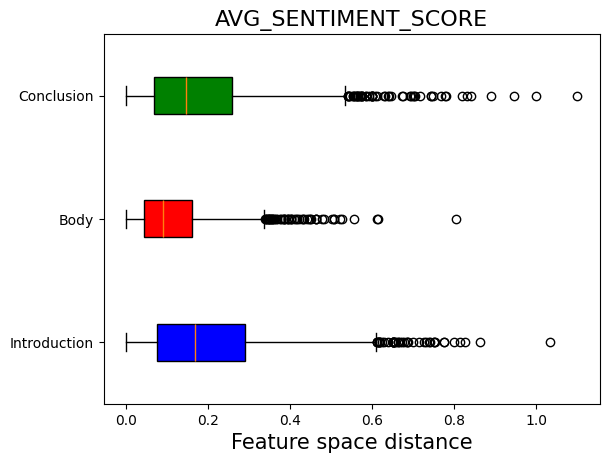

In [ ]:
test_one_way_anova(I, B, C, "AVG_SENTIMENT_SCORE")

                    sum_sq       df          F        PR(>F)
Segment           1.347544      2.0  34.262379  1.479318e-15
Source            1.895432      1.0  96.385685  1.192580e-22
Segment:Source    0.118275      2.0   3.007223  4.947283e-02
Residual        199.521840  10146.0        NaN           NaN
(H>A) I-B:  WilcoxonResult(statistic=789820.0, pvalue=0.00012334686147896535)
(H>A) I-C:  WilcoxonResult(statistic=817631.0, pvalue=2.217393395657339e-07)
(H>A) B-C:  WilcoxonResult(statistic=825231.5, pvalue=2.8589061442826682e-08)
--------------------------------------------------
(A>H) I-B:  WilcoxonResult(statistic=642458.0, pvalue=0.999876653138521)
(A>H) I-C:  WilcoxonResult(statistic=614647.0, pvalue=0.9999997782606604)
(A>H) B-C:  WilcoxonResult(statistic=607046.5, pvalue=0.9999999714109385)


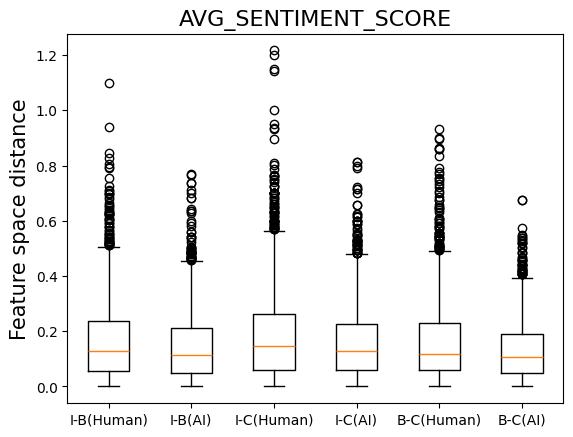

In [ ]:
test_two_way_anova(H_I_B, H_I_C, H_B_C, AI_I_B, AI_I_C, AI_B_C, "AVG_SENTIMENT_SCORE")

### AVG_formality score

In [ ]:
intro_col = 'intro_formality_score'
body_col = 'body_formality_score'
conclusion_col = 'conclusion_formality_score'
mask = (orig_df[intro_col] != '[]') & (orig_df[body_col] != '[]') & (orig_df[conclusion_col] != '[]')
df = orig_df[mask]
df.shape

(5440, 60)

In [ ]:
h_intro_emd = []
h_body_emd = []
h_conclusion_emd = []
ai_intro_emd = []
ai_body_emd = []
ai_conclusion_emd = []

human_rows = df[df['source'] == 'human']

for i, row in human_rows.iterrows():
  try:
    # Get all rows with the current key but a different source
    key = row['key']
    other_sources = df[(df['key'] == key) & (df['source'] != 'human')]
    # print(other_sources.shape)
    # Sample a row from the other_sources DataFrame
    sampled_row = other_sources.sample(n=1).iloc[0]
    h_intro_emd.append(np.average(ast.literal_eval(row[intro_col])))
    h_body_emd.append(np.average(ast.literal_eval(row[body_col])))
    h_conclusion_emd.append(np.average(ast.literal_eval(row[conclusion_col])))

    ai_intro_emd.append(np.average(ast.literal_eval(sampled_row[intro_col])))
    ai_body_emd.append(np.average(ast.literal_eval(sampled_row[body_col])))
    ai_conclusion_emd.append(np.average(ast.literal_eval(sampled_row[conclusion_col])))
    # I.append(np.abs(row[intro_col]) - sampled_row[intro_col])
    # B.append(np.abs(row[body_col]) - sampled_row[body_col])
    # C.append(np.abs(row[conclusion_col]) - sampled_row[conclusion_col])
  except:
    continue

I  = []
B = []
C = []
for i in range(len(h_intro_emd)):
  I.append(calculate_distance(h_intro_emd[i], ai_intro_emd[i]))
  B.append(calculate_distance(h_body_emd[i], ai_body_emd[i]))
  C.append(calculate_distance(h_conclusion_emd[i], ai_conclusion_emd[i]))

H_I_B, H_I_C, H_B_C, AI_I_B, AI_I_C, AI_B_C = [], [], [], [], [], []
for i in range(len(h_intro_emd)):
  H_I_B.append(calculate_distance(h_intro_emd[i], h_body_emd[i]))
  H_I_C.append(calculate_distance(h_intro_emd[i], h_conclusion_emd[i]))
  H_B_C.append(calculate_distance(h_body_emd[i], h_conclusion_emd[i]))
  AI_I_B.append(calculate_distance(ai_intro_emd[i], ai_body_emd[i]))
  AI_I_C.append(calculate_distance(ai_intro_emd[i], ai_conclusion_emd[i]))
  AI_B_C.append(calculate_distance(ai_body_emd[i], ai_conclusion_emd[i]))


f_value:  20.805956725893356
p_value:  1.0021794290412998e-09
I>B:  WilcoxonResult(statistic=799959.5, pvalue=1.013850360314903e-05)
I>C:  WilcoxonResult(statistic=652780.5, pvalue=0.9970810072152934)
B>C:  WilcoxonResult(statistic=556544.0, pvalue=0.999999999999999)
--------------------------------------------------
B>I:  WilcoxonResult(statistic=628935.5, pvalue=0.9999898614963969)
C>I:  WilcoxonResult(statistic=762622.5, pvalue=0.002918992784706692)
C>B:  WilcoxonResult(statistic=875734.0, pvalue=1.0114411511580907e-15)


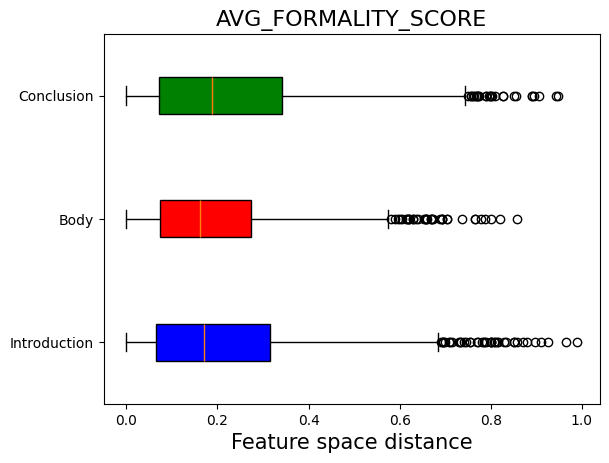

In [ ]:
test_one_way_anova(I, B, C, "AVG_FORMALITY_SCORE")

                    sum_sq       df           F         PR(>F)
Segment           0.237484      2.0    8.875124   1.409127e-04
Source            9.452514      1.0  706.509047  1.516024e-150
Segment:Source    0.693629      2.0   25.921954   5.900695e-12
Residual        135.745188  10146.0         NaN            NaN
(H>A) I-B:  WilcoxonResult(statistic=934177.5, pvalue=1.0244478989247986e-27)
(H>A) I-C:  WilcoxonResult(statistic=1074172.0, pvalue=8.217970072561934e-77)
(H>A) B-C:  WilcoxonResult(statistic=1002864.0, pvalue=1.815278152021322e-46)
--------------------------------------------------
(A>H) I-B:  WilcoxonResult(statistic=498100.5, pvalue=1.0)
(A>H) I-C:  WilcoxonResult(statistic=337868.0, pvalue=1.0)
(A>H) B-C:  WilcoxonResult(statistic=429414.0, pvalue=1.0)


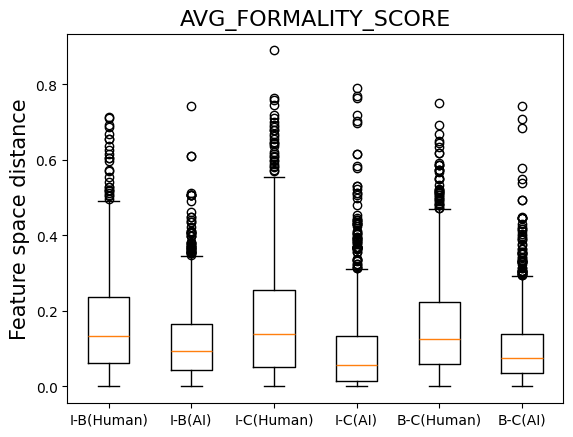

In [ ]:
test_two_way_anova(H_I_B, H_I_C, H_B_C, AI_I_B, AI_I_C, AI_B_C, "AVG_FORMALITY_SCORE")

### AVG_surprisal score

In [ ]:
orig_df = pd.read_csv('persuade_feature_list.csv')
def truncate_key(key_val):
  return key_val[:key_val.find('_')]
orig_df['key'] = orig_df['key'].apply(truncate_key)
mask = (orig_df['intro_perplexity_scores'] != '[]') & (orig_df['body_perplexity_scores'] != '[]') & (orig_df['conclusion_perplexity_scores'] != '[]') & (orig_df['intro_avg_burstiness_score'] != 0) \
& (orig_df['conclusion_avg_burstiness_score'] != 0)  & (orig_df['intro_avg_burstiness_score'] <2000) & (orig_df['conclusion_avg_burstiness_score'] <2000) & (orig_df['body_avg_burstiness_score'] <2000)
df = orig_df[mask]
df.shape

(3810, 20)

In [ ]:
df.columns

Index(['key', 'source', 'intro_text', 'body_text', 'conclusion_text', 'intro_uid_scores', 'conclusion_uid_scores', 'body_uid_scores', 'intro_perplexity_scores', 'intro_avg_perplexity_score', 'intro_std_perplexity_score', 'intro_avg_burstiness_score', 'conclusion_perplexity_scores', 'conclusion_avg_perplexity_score', 'conclusion_std_perplexity_score', 'conclusion_avg_burstiness_score', 'body_perplexity_scores', 'body_avg_perplexity_score', 'body_std_perplexity_score', 'body_avg_burstiness_score'], dtype='object')

In [ ]:
col_name = 'avg_perplexity_score'
intro_col = 'intro_' + col_name
body_col = 'body_' + col_name
conclusion_col = 'conclusion_' + col_name

In [ ]:
h_intro_emd = []
h_body_emd = []
h_conclusion_emd = []
ai_intro_emd = []
ai_body_emd = []
ai_conclusion_emd = []

human_rows = df[df['source'] == 'human']

for i, row in human_rows.iterrows():
  try:
    # Get all rows with the current key but a different source
    key = row['key']
    other_sources = df[(df['key'] == key) & (df['source'] != 'human')]
    # print(other_sources.shape)
    # Sample a row from the other_sources DataFrame
    sampled_row = other_sources.sample(n=1, ).iloc[0]
    h_intro_emd.append(row[intro_col])
    h_body_emd.append(row[body_col])
    h_conclusion_emd.append(row[conclusion_col])

    ai_intro_emd.append(sampled_row[intro_col])
    ai_body_emd.append(sampled_row[body_col])
    ai_conclusion_emd.append(sampled_row[conclusion_col])
    # I.append(np.abs(row[intro_col]) - sampled_row[intro_col])
    # B.append(np.abs(row[body_col]) - sampled_row[body_col])
    # C.append(np.abs(row[conclusion_col]) - sampled_row[conclusion_col])
  except:
    continue

I  = []
B = []
C = []
for i in range(len(h_intro_emd)):
  I.append(calculate_distance(h_intro_emd[i], ai_intro_emd[i]))
  B.append(calculate_distance(h_body_emd[i], ai_body_emd[i]))
  C.append(calculate_distance(h_conclusion_emd[i], ai_conclusion_emd[i]))

H_I_B, H_I_C, H_B_C, AI_I_B, AI_I_C, AI_B_C = [], [], [], [], [], []
for i in range(len(h_intro_emd)):
  H_I_B.append(calculate_distance(h_intro_emd[i], h_body_emd[i]))
  H_I_C.append(calculate_distance(h_intro_emd[i], h_conclusion_emd[i]))
  H_B_C.append(calculate_distance(h_body_emd[i], h_conclusion_emd[i]))
  AI_I_B.append(calculate_distance(ai_intro_emd[i], ai_body_emd[i]))
  AI_I_C.append(calculate_distance(ai_intro_emd[i], ai_conclusion_emd[i]))
  AI_B_C.append(calculate_distance(ai_body_emd[i], ai_conclusion_emd[i]))


f_value:  0.9277765594295633
p_value:  0.39553987845379224
I>B:  WilcoxonResult(statistic=246483.5, pvalue=0.9989983728206123)
I>C:  WilcoxonResult(statistic=266471.5, pvalue=0.8558688434128042)
B>C:  WilcoxonResult(statistic=293955.5, pvalue=0.04214262238175214)
--------------------------------------------------
B>I:  WilcoxonResult(statistic=307394.5, pvalue=0.0010016271793876442)
C>I:  WilcoxonResult(statistic=287406.5, pvalue=0.14413115658719577)
C>B:  WilcoxonResult(statistic=259922.5, pvalue=0.9578573776182479)


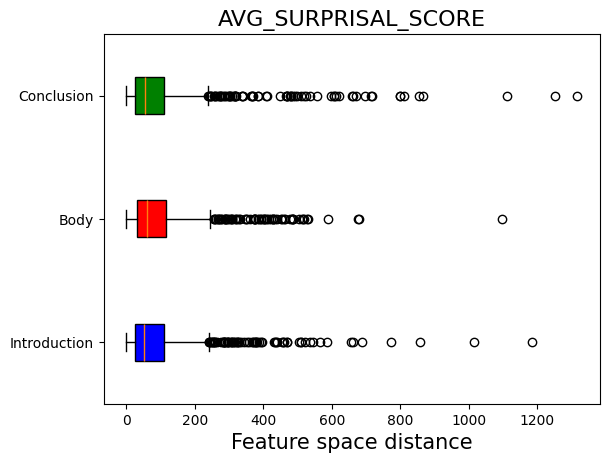

In [ ]:
test_one_way_anova(I, B, C, "AVG_SURPRISAL_SCORE")

                      sum_sq      df           F        PR(>F)
Segment         7.963803e+04     2.0    4.223760  1.468494e-02
Source          2.411003e+06     1.0  255.744585  1.850574e-56
Segment:Source  4.928938e+04     2.0    2.614159  7.330872e-02
Residual        5.944910e+07  6306.0         NaN           NaN
(H>A) I-B:  WilcoxonResult(statistic=367180.0, pvalue=2.716260063628869e-20)
(H>A) I-C:  WilcoxonResult(statistic=399965.0, pvalue=1.9283318372778154e-36)
(H>A) B-C:  WilcoxonResult(statistic=411894.0, pvalue=2.0886222432747985e-43)
--------------------------------------------------
(A>H) I-B:  WilcoxonResult(statistic=186698.0, pvalue=1.0)
(A>H) I-C:  WilcoxonResult(statistic=152861.0, pvalue=1.0)
(A>H) B-C:  WilcoxonResult(statistic=140932.0, pvalue=1.0)


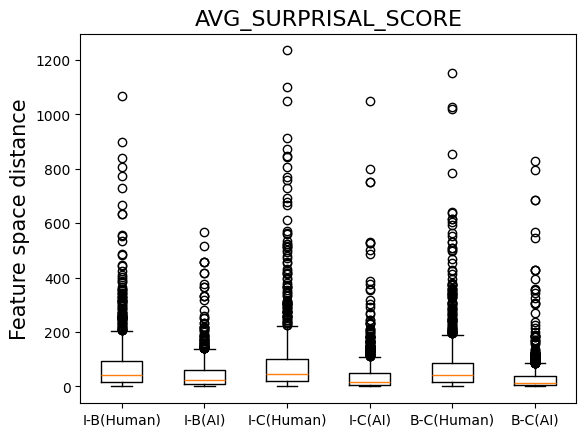

In [ ]:
test_two_way_anova(H_I_B, H_I_C, H_B_C, AI_I_B, AI_I_C, AI_B_C, "AVG_SURPRISAL_SCORE")

### surprisal scores

In [ ]:
mask = (orig_df['intro_perplexity_scores'] != '[]') & (orig_df['conclusion_perplexity_scores'] != '[]') & (orig_df['body_perplexity_scores'] != '[]')
df = orig_df[mask]
df = df.dropna()
df.shape

(3962, 20)

In [ ]:
N = 50
from scipy.interpolate import interp1d
def convert_to_fixed_length_time_series(time_series):
    # Create an interpolation function
    x = np.arange(len(time_series))
    f = interp1d(x, time_series, kind='linear')

    # Resample the time series to a fixed length N
    new_x = np.linspace(0, len(time_series) - 1, N)
    new_time_series = f(new_x)
    return new_time_series
def get_fixed_len_perplexity_scores(perplexity_score):
  L = ast.literal_eval(perplexity_score)
  return convert_to_fixed_length_time_series(L)
intro_col = 'intro_perplexity_scores'
body_col = 'body_perplexity_scores'
conclusion_col = 'conclusion_perplexity_scores'
df[intro_col] = df[intro_col].apply(get_fixed_len_perplexity_scores)
df[body_col] = df[body_col].apply(get_fixed_len_perplexity_scores)
df[conclusion_col] = df[conclusion_col].apply(get_fixed_len_perplexity_scores)

In [ ]:
h_intro_emd = []
h_body_emd = []
h_conclusion_emd = []
ai_intro_emd = []
ai_body_emd = []
ai_conclusion_emd = []

human_rows = df[df['source'] == 'human']

for i, row in human_rows.iterrows():
  try:
    # Get all rows with the current key but a different source
    key = row['key']
    other_sources = df[(df['key'] == key) & (df['source'] != 'human')]
    # print(other_sources.shape)
    # Sample a row from the other_sources DataFrame
    sampled_row = other_sources.sample(n=1,).iloc[0]
    h_intro_emd.append(row[intro_col])
    h_body_emd.append(row[body_col])
    h_conclusion_emd.append(row[conclusion_col])

    ai_intro_emd.append(sampled_row[intro_col])
    ai_body_emd.append(sampled_row[body_col])
    ai_conclusion_emd.append(sampled_row[conclusion_col])
    # I.append(np.abs(row[intro_col]) - sampled_row[intro_col])
    # B.append(np.abs(row[body_col]) - sampled_row[body_col])
    # C.append(np.abs(row[conclusion_col]) - sampled_row[conclusion_col])
  except:
    continue

I  = []
B = []
C = []
for i in range(len(h_intro_emd)):
  I.append(calculate_distance(h_intro_emd[i], ai_intro_emd[i]))
  B.append(calculate_distance(h_body_emd[i], ai_body_emd[i]))
  C.append(calculate_distance(h_conclusion_emd[i], ai_conclusion_emd[i]))

H_I_B, H_I_C, H_B_C, AI_I_B, AI_I_C, AI_B_C = [], [], [], [], [], []
for i in range(len(h_intro_emd)):
  H_I_B.append(calculate_distance(h_intro_emd[i], h_body_emd[i]))
  H_I_C.append(calculate_distance(h_intro_emd[i], h_conclusion_emd[i]))
  H_B_C.append(calculate_distance(h_body_emd[i], h_conclusion_emd[i]))
  AI_I_B.append(calculate_distance(ai_intro_emd[i], ai_body_emd[i]))
  AI_I_C.append(calculate_distance(ai_intro_emd[i], ai_conclusion_emd[i]))
  AI_B_C.append(calculate_distance(ai_body_emd[i], ai_conclusion_emd[i]))


f_value:  250.86248650479973
p_value:  1.3176767257535702e-104
I>B:  WilcoxonResult(statistic=347026.0, pvalue=1.0)
I>C:  WilcoxonResult(statistic=720420.0, pvalue=0.35102901548577664)
B>C:  WilcoxonResult(statistic=1100961.0, pvalue=5.478482368899883e-84)
--------------------------------------------------
B>I:  WilcoxonResult(statistic=1078490.0, pvalue=8.6063872544292665e-75)
C>I:  WilcoxonResult(statistic=705096.0, pvalue=0.6489709845142233)
C>B:  WilcoxonResult(statistic=324555.0, pvalue=1.0)


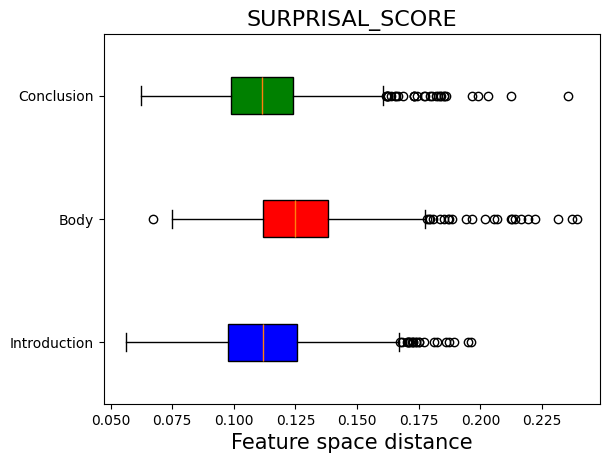

In [ ]:
test_one_way_anova(I, B, C, "SURPRISAL_SCORE")

                  sum_sq       df           F        PR(>F)
Segment         0.136459      2.0  148.518215  2.676996e-64
Source          0.080834      1.0  175.954654  7.957262e-40
Segment:Source  0.003384      2.0    3.682667  2.518952e-02
Residual        4.650052  10122.0         NaN           NaN
(H>A) I-B:  WilcoxonResult(statistic=586675.0, pvalue=0.9999999998462978)
(H>A) I-C:  WilcoxonResult(statistic=518896.0, pvalue=1.0)
(H>A) B-C:  WilcoxonResult(statistic=586781.0, pvalue=0.9999999998409655)
--------------------------------------------------
(A>H) I-B:  WilcoxonResult(statistic=838841.0, pvalue=1.5370217083307993e-10)
(A>H) I-C:  WilcoxonResult(statistic=906620.0, pvalue=1.8510998116861377e-22)
(A>H) B-C:  WilcoxonResult(statistic=838735.0, pvalue=1.590344677496395e-10)


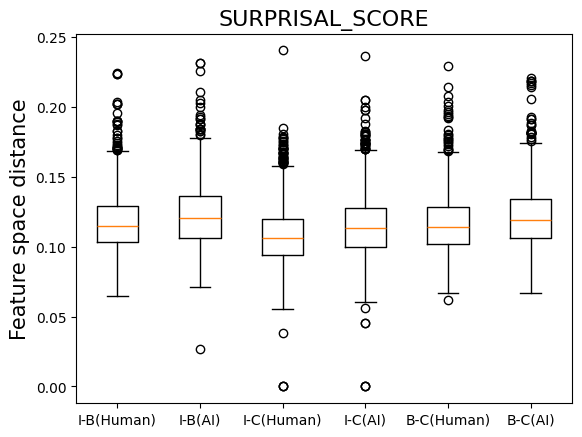

In [ ]:
test_two_way_anova(H_I_B, H_I_C, H_B_C, AI_I_B, AI_I_C, AI_B_C, "SURPRISAL_SCORE")

### Change of content

In [ ]:
df = pd.read_csv('persuade_feature_list.csv')
def truncate_key(key_val):
  return key_val[:key_val.find('_')]
orig_df['key'] = orig_df['key'].apply(truncate_key)
print(df.shape)
df = df.dropna()
df.shape

(5505, 8)


(5434, 8)

In [ ]:
def process_strings(s):
  s = s.replace('\n', '')
  s = s.replace('dtype=float32', '')
  s = s.replace('array(', '')
  s = s.replace(')', '')
  s = s.replace('[', '')
  s = s.replace(']', '')
  return s
def convert_to_traditional_form(text):
    # Split the text by comma to get individual numbers
    text = process_strings(text)
    numbers = text.split(', ')
    traditional_numbers = []
    # Convert each number from scientific notation to traditional form
    for number in numbers:
      try:
        traditional_numbers.append(float(number))
      except:
        continue
    # traditional_numbers = [float(number) for number in numbers[:-1]]
    D = 384
    N = len(traditional_numbers) // D
    array_2d = np.array(traditional_numbers).reshape(N, D)
    return array_2d

def get_content_change(s):
  embeddings = convert_to_traditional_form(s)
  # print(embeddings.shape)
  if len(embeddings)<2: # only one sentence, so we return the value 0.5 as no correlation value
    return 0.5
  n_sentences  = len(embeddings)
  D = []
  # print(n_sentences)
  for i in range(n_sentences-1):
    # print(embeddings[i])
    D.append(cosine_distance(embeddings[i], embeddings[i+1]))
  # print(embeddings.shape, D, np.mean(D))
  return np.mean(D)

def get_avg_content_vector(s):
  embeddings = convert_to_traditional_form(s)
  return np.mean(embeddings, axis=0)

In [ ]:
col_name = 'content_change'
intro_col = 'intro_' + col_name
body_col = 'body_' + col_name
conclusion_col = 'conclusion_' + col_name
df[intro_col] = df['intro_embeddings'].progress_apply(get_content_change)
df[body_col] = df['body_embeddings'].progress_apply(get_content_change)
df[conclusion_col] = df['conclusion_embeddings'].progress_apply(get_content_change)
df.sample(2)

100%|██████████| 5434/5434 [00:04<00:00, 1127.49it/s]


,key,source,intro_text,body_text,conclusion_text,intro_embeddings,body_embeddings,conclusion_embeddings,intro_content_change,body_content_change,conclusion_content_change
454,carfree_human_214,human,Reducing car usage is becoming a big thing in ...,Limiting car usage can prevent congestion in t...,"Since these cities have made this change, ther...","[array([ 5.91626227e-01, 2.69156814e-01, 3.1...","[array([ 3.54706049e-01, 5.86647630e-01, 1.9...","[array([ 0.23213978, 0.06276793, 0.34172028,...",0.423743,0.726058,0.500000
3550,electoral_mistral_36,mistral_7b,"Dear Senator,\n\nI am writing to express my su...","Firstly, the Electoral College system ensures ...","In conclusion, I believe that the Electoral Co...","[array([-0.43616378, -0.23207434, 0.08408535,...","[array([-0.09173977, -0.3093597 , -0.45489588,...","[array([-1.34234026e-01, -3.13490480e-01, -2.7...",0.375768,0.479138,0.695306


In [ ]:
df['key'] = df['key'].apply(truncate_key)

In [ ]:
h_intro_emd = []
h_body_emd = []
h_conclusion_emd = []
ai_intro_emd = []
ai_body_emd = []
ai_conclusion_emd = []

human_rows = df[df['source'] == 'human']

for i, row in human_rows.iterrows():
  try:
    # Get all rows with the current key but a different source
    key = row['key']
    other_sources = df[(df['key'] == key) & (df['source'] != 'human')]
    # print(other_sources.shape)
    # Sample a row from the other_sources DataFrame
    sampled_row = other_sources.sample(n=1, ).iloc[0]
    h_intro_emd.append(row[intro_col])
    h_body_emd.append(row[body_col])
    h_conclusion_emd.append(row[conclusion_col])

    ai_intro_emd.append(sampled_row[intro_col])
    ai_body_emd.append(sampled_row[body_col])
    ai_conclusion_emd.append(sampled_row[conclusion_col])
    # I.append(np.abs(row[intro_col]) - sampled_row[intro_col])
    # B.append(np.abs(row[body_col]) - sampled_row[body_col])
    # C.append(np.abs(row[conclusion_col]) - sampled_row[conclusion_col])
  except:
    continue

I  = []
B = []
C = []
for i in range(len(h_intro_emd)):
  I.append(calculate_distance(h_intro_emd[i], ai_intro_emd[i]))
  B.append(calculate_distance(h_body_emd[i], ai_body_emd[i]))
  C.append(calculate_distance(h_conclusion_emd[i], ai_conclusion_emd[i]))

H_I_B, H_I_C, H_B_C, AI_I_B, AI_I_C, AI_B_C = [], [], [], [], [], []
for i in range(len(h_intro_emd)):
  H_I_B.append(calculate_distance(h_intro_emd[i], h_body_emd[i]))
  H_I_C.append(calculate_distance(h_intro_emd[i], h_conclusion_emd[i]))
  H_B_C.append(calculate_distance(h_body_emd[i], h_conclusion_emd[i]))
  AI_I_B.append(calculate_distance(ai_intro_emd[i], ai_body_emd[i]))
  AI_I_C.append(calculate_distance(ai_intro_emd[i], ai_conclusion_emd[i]))
  AI_B_C.append(calculate_distance(ai_body_emd[i], ai_conclusion_emd[i]))


In [ ]:
I

f_value:  23.43035478923144
p_value:  7.432228363319236e-11
I>B:  WilcoxonResult(statistic=829577.0, pvalue=2.7306379662710916e-09)
I>C:  WilcoxonResult(statistic=702049.0, pvalue=0.5955042895081878)
B>C:  WilcoxonResult(statistic=582638.0, pvalue=0.9999999999589099)
--------------------------------------------------
B>I:  WilcoxonResult(statistic=595939.0, pvalue=0.9999999972693621)
C>I:  WilcoxonResult(statistic=711672.0, pvalue=0.4044957104918122)
C>B:  WilcoxonResult(statistic=842878.0, pvalue=4.10901233295695e-11)


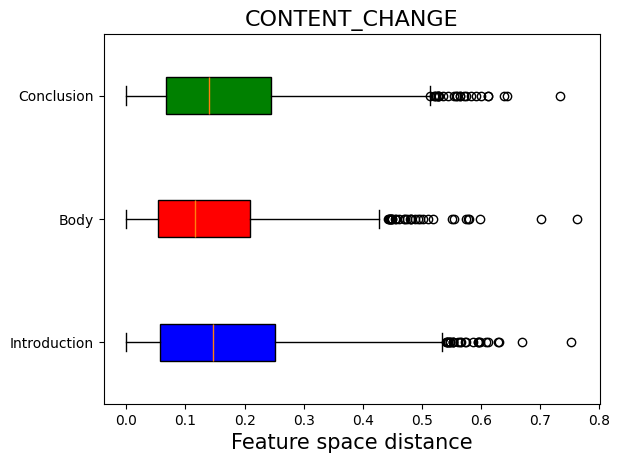

In [ ]:
test_one_way_anova(I, B, C, "CONTENT_CHANGE")

                    sum_sq       df          F        PR(>F)
Segment           0.358419      2.0  14.603547  4.643950e-07
Source            0.427953      1.0  34.873347  3.631793e-09
Segment:Source    0.043513      2.0   1.772894  1.698934e-01
Residual        124.287243  10128.0        NaN           NaN
(H>A) I-B:  WilcoxonResult(statistic=764981.0, pvalue=0.004562179696923965)
(H>A) I-C:  WilcoxonResult(statistic=741855.0, pvalue=0.03936471288626271)
(H>A) B-C:  WilcoxonResult(statistic=819762.0, pvalue=4.585372027476645e-08)
--------------------------------------------------
(A>H) I-B:  WilcoxonResult(statistic=660535.0, pvalue=0.995437820303076)
(A>H) I-C:  WilcoxonResult(statistic=671866.0, pvalue=0.9606352871137372)
(A>H) B-C:  WilcoxonResult(statistic=605754.0, pvalue=0.9999999541462797)


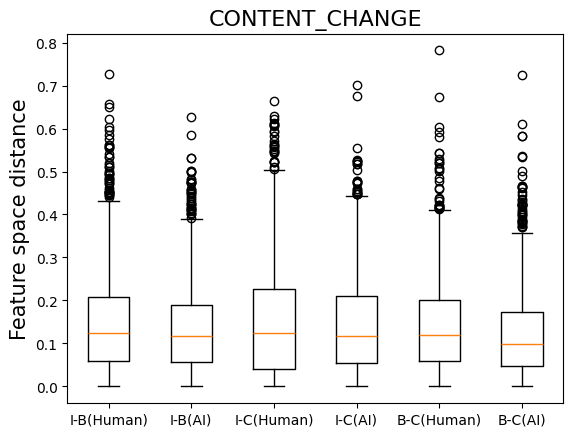

In [ ]:
test_two_way_anova(H_I_B, H_I_C, H_B_C, AI_I_B, AI_I_C, AI_B_C, "CONTENT_CHANGE")

### Content similarity

In [ ]:
col_name = 'content_vector'
intro_col = 'intro_' + col_name
body_col = 'body_' + col_name
conclusion_col = 'conclusion_' + col_name
df[intro_col] = df['intro_embeddings'].progress_apply(get_avg_content_vector)
df[body_col] = df['body_embeddings'].progress_apply(get_avg_content_vector)
df[conclusion_col] = df['conclusion_embeddings'].progress_apply(get_avg_content_vector)
df.sample(2)

100%|██████████| 5434/5434 [00:09<00:00, 570.91it/s]


,key,source,intro_text,body_text,conclusion_text,intro_embeddings,body_embeddings,conclusion_embeddings,intro_content_change,body_content_change,conclusion_content_change,intro_content_vector,body_content_vector,conclusion_content_vector
3168,facial,palm_text_bison,"Emotions are what make us human, and they allo...",The Facial Action Coding System (FACS) is a ne...,"Overall, I believe that the use of FACS in the...","[array([-3.64367068e-01, -1.04307078e-01, 3.6...","[array([-1.05127323e+00, -4.37039256e-01, -2.8...","[array([-3.73585671e-01, -3.01557034e-01, -3.9...",0.307969,0.518607,0.569053,"[-0.408034519, 0.014206191000000007, 0.2882481...","[-0.32443375928571433, -0.04758552427142858, -...","[-0.2998128305, -0.134048377, -0.1835081079999..."
2139,carfree,claude,Limiting car usage has several significant adv...,- Reducing personal contributions to greenhous...,"In summary, limiting car usage through individ...","[array([ 0.26659396, 0.39505565, 0.27933538,...","[array([ 1.93561718e-01, 4.82782274e-01, 3.7...","[array([ 0.37867796, 0.47280946, 0.27783597,...",0.494067,0.428343,0.493220,"[0.191875705, 0.475911325, 0.331108855, -0.150...","[0.32522700025, 0.3186719005, 0.25139919585000...","[0.15616729456666664, 0.3017972253333333, 0.12..."


In [ ]:
h_intro_emd = []
h_body_emd = []
h_conclusion_emd = []
ai_intro_emd = []
ai_body_emd = []
ai_conclusion_emd = []

human_rows = df[df['source'] == 'human']

for i, row in human_rows.iterrows():
  try:
    # Get all rows with the current key but a different source
    key = row['key']
    other_sources = df[(df['key'] == key) & (df['source'] != 'human')]
    # print(other_sources.shape)
    # Sample a row from the other_sources DataFrame
    sampled_row = other_sources.sample(n=1).iloc[0]
    h_intro_emd.append(row[intro_col])
    h_body_emd.append(row[body_col])
    h_conclusion_emd.append(row[conclusion_col])

    ai_intro_emd.append(sampled_row[intro_col])
    ai_body_emd.append(sampled_row[body_col])
    ai_conclusion_emd.append(sampled_row[conclusion_col])
    # I.append(np.abs(row[intro_col]) - sampled_row[intro_col])
    # B.append(np.abs(row[body_col]) - sampled_row[body_col])
    # C.append(np.abs(row[conclusion_col]) - sampled_row[conclusion_col])
  except:
    continue

I  = []
B = []
C = []
for i in range(len(h_intro_emd)):
  I.append(calculate_distance(h_intro_emd[i], ai_intro_emd[i], method='cosine'))
  B.append(calculate_distance(h_body_emd[i], ai_body_emd[i], method='cosine'))
  C.append(calculate_distance(h_conclusion_emd[i], ai_conclusion_emd[i], method='cosine'))

H_I_B, H_I_C, H_B_C, AI_I_B, AI_I_C, AI_B_C = [], [], [], [], [], []
for i in range(len(h_intro_emd)):
  H_I_B.append(calculate_distance(h_intro_emd[i], h_body_emd[i], method='cosine'))
  H_I_C.append(calculate_distance(h_intro_emd[i], h_conclusion_emd[i], method='cosine'))
  H_B_C.append(calculate_distance(h_body_emd[i], h_conclusion_emd[i], method='cosine'))
  AI_I_B.append(calculate_distance(ai_intro_emd[i], ai_body_emd[i], method='cosine'))
  AI_I_C.append(calculate_distance(ai_intro_emd[i], ai_conclusion_emd[i], method='cosine'))
  AI_B_C.append(calculate_distance(ai_body_emd[i], ai_conclusion_emd[i], method='cosine'))


f_value:  59.46646008240326
p_value:  2.9692851331304953e-26
I>B:  WilcoxonResult(statistic=995043.0, pvalue=4.4909383041650563e-45)
I>C:  WilcoxonResult(statistic=661893.0, pvalue=0.9950518192027612)
B>C:  WilcoxonResult(statistic=388545.0, pvalue=1.0)
--------------------------------------------------
B>I:  WilcoxonResult(statistic=432162.0, pvalue=1.0)
C>I:  WilcoxonResult(statistic=765312.0, pvalue=0.0049481807972387905)
C>B:  WilcoxonResult(statistic=1038660.0, pvalue=1.979490852900228e-59)


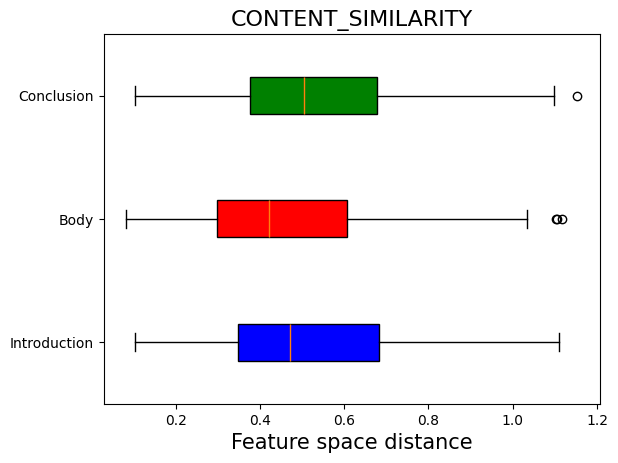

In [ ]:
test_one_way_anova(I, B, C, "CONTENT_SIMILARITY")

                    sum_sq       df            F         PR(>F)
Segment           1.070088      2.0    25.309762   1.085144e-11
Source           27.724581      1.0  1311.486262  3.719764e-270
Segment:Source    1.053139      2.0    24.908888   1.617059e-11
Residual        214.104076  10128.0          NaN            NaN
(H>A) I-B:  WilcoxonResult(statistic=1051191.0, pvalue=6.216285014452796e-64)
(H>A) I-C:  WilcoxonResult(statistic=1146384.0, pvalue=1.1523805044891822e-103)
(H>A) B-C:  WilcoxonResult(statistic=1123516.0, pvalue=3.145407537417678e-93)
--------------------------------------------------
(A>H) I-B:  WilcoxonResult(statistic=376014.0, pvalue=1.0)
(A>H) I-C:  WilcoxonResult(statistic=280821.0, pvalue=1.0)
(A>H) B-C:  WilcoxonResult(statistic=303689.0, pvalue=1.0)


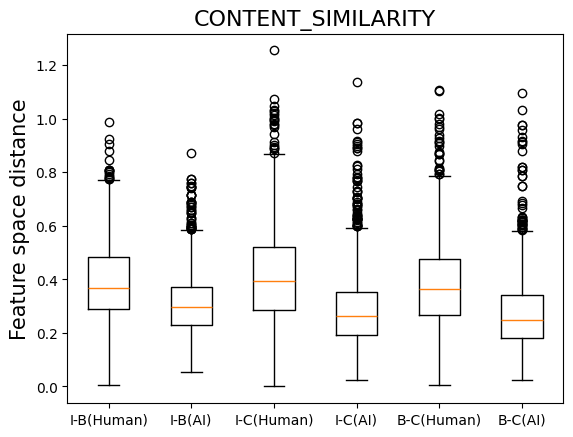

In [ ]:
test_two_way_anova(H_I_B, H_I_C, H_B_C, AI_I_B, AI_I_C, AI_B_C, "CONTENT_SIMILARITY")

### Pos_tag

In [ ]:

pos_tags = ['ADJ', 'ADP', 'ADV', 'AUX', 'CONJ', 'DET', 'INTJ', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SYM', 'VERB', 'X']
pos_tag_counts = Counter({tag: 0 for tag in pos_tags})
pos_tag_str = str(pos_tag_counts)[8:-1]
mask = (orig_df['intro_pos_tag'] != pos_tag_str) & (orig_df['body_pos_tag'] != pos_tag_str) & (orig_df['conclusion_pos_tag'] != pos_tag_str)
df = orig_df[mask]
df.shape

(5440, 60)

In [ ]:
def get_pos_tag_percentage(pos_tag_counts, wc):
  D = ast.literal_eval(pos_tag_counts)
  for k in D.keys():
    D[k] = round(D[k]*100/wc,2)
  return D
intro_col = 'intro_pos_tag'
body_col = 'body_pos_tag'
conclusion_col = 'conclusion_pos_tag'
df['intro_pos_tag'] = df.apply(lambda row: get_pos_tag_percentage(row['intro_pos_tag'], row['intro_word_count']), axis=1)
df['body_pos_tag'] = df.apply(lambda row: get_pos_tag_percentage(row['body_pos_tag'], row['body_word_count']), axis=1)
df['conclusion_pos_tag'] = df.apply(lambda row: get_pos_tag_percentage(row['conclusion_pos_tag'], row['conclusion_word_count']), axis=1)

intro_col = 'intro_pos_tag'
body_col = 'body_pos_tag'
conclusion_col = 'conclusion_pos_tag'
df = df.sample(frac=1)



In [ ]:
key

'driverless_human_207'

In [ ]:
h_intro_emd = []
h_body_emd = []
h_conclusion_emd = []
ai_intro_emd = []
ai_body_emd = []
ai_conclusion_emd = []
human_rows = df[df['source'] == 'human']

for i, row in human_rows.iterrows():
  try:
    # Get all rows with the current key but a different source
    key = row['key']
    other_sources = df[(df['key'] == key) & (df['source'] != 'human')]
    # print(other_sources.shape)
    # Sample a row from the other_sources DataFrame
    sampled_row = other_sources.sample(n=1).iloc[0]

    h_intro_emd.append(list(row[intro_col].values())[:len(pos_tags)])
    h_body_emd.append(list(row[body_col].values())[:len(pos_tags)])
    h_conclusion_emd.append(list(row[conclusion_col].values())[:len(pos_tags)])
    # print(h_intro_emd.shape, h_body_emd.shape, h_conclusion_emd.shape)



    ai_intro_emd.append(list(sampled_row[intro_col].values())[:len(pos_tags)])
    ai_body_emd.append(list(sampled_row[body_col].values())[:len(pos_tags)])
    ai_conclusion_emd.append(list(sampled_row[conclusion_col].values())[:len(pos_tags)])

  except:
    continue

I  = []
B = []
C = []
for i in range(len(h_intro_emd)):
  I.append(calculate_distance(h_intro_emd[i], ai_intro_emd[i]))
  B.append(calculate_distance(h_body_emd[i], ai_body_emd[i]))
  C.append(calculate_distance(h_conclusion_emd[i], ai_conclusion_emd[i]))

In [ ]:
I

[]

f_value:  438.1128852182713
p_value:  3.057669423434988e-176
I-B:  WilcoxonResult(statistic=1280540.0, pvalue=8.781256480068364e-174)
I-C:  WilcoxonResult(statistic=955047.0, pvalue=7.014500461016563e-33)
B-C:  WilcoxonResult(statistic=284356.0, pvalue=1.0)


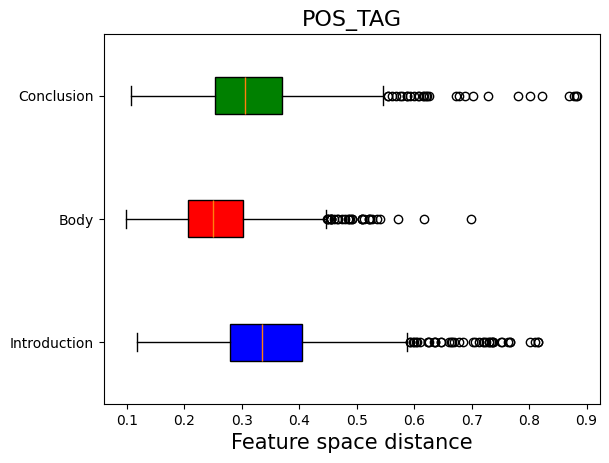

In [ ]:
test_one_way_anova(I, B, C, "POS_TAG")

In [ ]:
H_I_B, H_I_C, H_B_C, AI_I_B, AI_I_C, AI_B_C = [], [], [], [], [], []
for i in range(len(h_intro_emd)):
  H_I_B.append(calculate_distance(h_intro_emd[i], h_body_emd[i]))
  H_I_C.append(calculate_distance(h_intro_emd[i], h_conclusion_emd[i]))
  H_B_C.append(calculate_distance(h_body_emd[i], h_conclusion_emd[i]))
  AI_I_B.append(calculate_distance(ai_intro_emd[i], ai_body_emd[i]))
  AI_I_C.append(calculate_distance(ai_intro_emd[i], ai_conclusion_emd[i]))
  AI_B_C.append(calculate_distance(ai_body_emd[i], ai_conclusion_emd[i]))


                   sum_sq       df           F         PR(>F)
Segment          4.856042      2.0  282.131105  5.726506e-120
Source           2.986912      1.0  347.073150   3.405617e-76
Segment:Source   0.529585      2.0   30.768331   4.762587e-14
Residual        87.316495  10146.0         NaN            NaN
I-B:  WilcoxonResult(statistic=830829.0, pvalue=5.786932932124772e-09)
I-C:  WilcoxonResult(statistic=974607.0, pvalue=3.8321254619701894e-38)
B-C:  WilcoxonResult(statistic=1058008.0, pvalue=3.5722961045419544e-65)


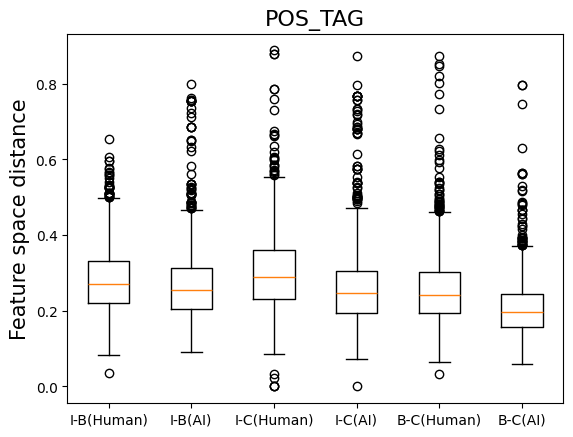

In [ ]:
test_two_way_anova(H_I_B, H_I_C, H_B_C, AI_I_B, AI_I_C, AI_B_C, "POS_TAG")

### NER Tags

In [ ]:

ner_tags =  ['PERSON', 'NORP', 'FAC', 'ORG', 'GPE', 'LOC', 'PRODUCT', 'EVENT', 'WORK_OF_ART', 'LAW', 'LANGUAGE', 'DATE', 'TIME', 'PERCENT', 'MONEY', 'QUANTITY', 'ORDINAL', 'CARDINAL']
ner_tag_counts = Counter({tag: 0 for tag in ner_tags})
ner_tag_str = str(ner_tag_counts)[8:-1]
mask = (orig_df['intro_ner_tags'] != ner_tag_str) & (orig_df['body_ner_tags'] != ner_tag_str) & (orig_df['conclusion_ner_tags'] != ner_tag_str)
df = orig_df[mask]
def get_ner_tag_percentage(ner_tag_counts, wc):
  D = ast.literal_eval(ner_tag_counts)
  for k in D.keys():
    D[k] = round(D[k]*100/wc,2)
  return D
intro_col = 'intro_ner_tags'
body_col = 'body_ner_tags'
conclusion_col = 'conclusion_ner_tags'
df['intro_ner_tags'] = df.apply(lambda row: get_ner_tag_percentage(row['intro_ner_tags'], row['intro_word_count']), axis=1)
df['body_ner_tags'] = df.apply(lambda row: get_ner_tag_percentage(row['body_ner_tags'], row['body_word_count']), axis=1)
df['conclusion_ner_tags'] = df.apply(lambda row: get_ner_tag_percentage(row['conclusion_ner_tags'], row['conclusion_word_count']), axis=1)

In [ ]:
h_intro_emd = []
h_body_emd = []
h_conclusion_emd = []
ai_intro_emd = []
ai_body_emd = []
ai_conclusion_emd = []
human_rows = df[df['source'] == 'human']

for i, row in human_rows.iterrows():
  try:
    # Get all rows with the current key but a different source
    key = row['key']
    other_sources = df[(df['key'] == key) & (df['source'] != 'human')]
    # print(other_sources.shape)
    # Sample a row from the other_sources DataFrame
    sampled_row = other_sources.sample(n=1).iloc[0]

    h_intro_emd.append(list(row[intro_col].values())[:len(pos_tags)])
    h_body_emd.append(list(row[body_col].values())[:len(pos_tags)])
    h_conclusion_emd.append(list(row[conclusion_col].values())[:len(pos_tags)])
    # print(h_intro_emd.shape, h_body_emd.shape, h_conclusion_emd.shape)



    ai_intro_emd.append(list(sampled_row[intro_col].values())[:len(pos_tags)])
    ai_body_emd.append(list(sampled_row[body_col].values())[:len(pos_tags)])
    ai_conclusion_emd.append(list(sampled_row[conclusion_col].values())[:len(pos_tags)])

  except:
    continue

I  = []
B = []
C = []
for i in range(len(h_intro_emd)):
  I.append(calculate_distance(h_intro_emd[i], ai_intro_emd[i]))
  B.append(calculate_distance(h_body_emd[i], ai_body_emd[i]))
  C.append(calculate_distance(h_conclusion_emd[i], ai_conclusion_emd[i]))

f_value:  8.78656989378944
p_value:  0.00015736343694338213
I-B:  WilcoxonResult(statistic=165081.5, pvalue=0.1302544830533809)
I-C:  WilcoxonResult(statistic=137876.5, pvalue=7.577581423921812e-05)
B-C:  WilcoxonResult(statistic=165385.5, pvalue=0.0036737957069852044)


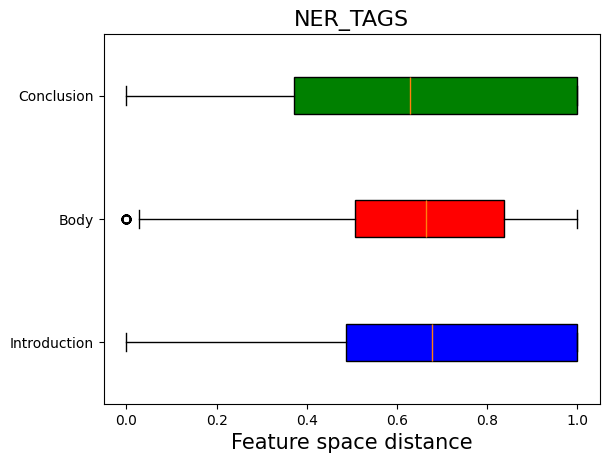

In [ ]:
test_one_way_anova(I, B, C, "NER_TAGS")

In [ ]:
H_I_B, H_I_C, H_B_C, AI_I_B, AI_I_C, AI_B_C = [], [], [], [], [], []
for i in range(len(h_intro_emd)):
  H_I_B.append(calculate_distance(h_intro_emd[i], h_body_emd[i]))
  H_I_C.append(calculate_distance(h_intro_emd[i], h_conclusion_emd[i]))
  H_B_C.append(calculate_distance(h_body_emd[i], h_conclusion_emd[i]))
  AI_I_B.append(calculate_distance(ai_intro_emd[i], ai_body_emd[i]))
  AI_I_C.append(calculate_distance(ai_intro_emd[i], ai_conclusion_emd[i]))
  AI_B_C.append(calculate_distance(ai_body_emd[i], ai_conclusion_emd[i]))


                    sum_sq      df          F        PR(>F)
Segment          10.808975     2.0  60.529032  1.033881e-26
Source            1.973718     1.0  22.105188  2.647939e-06
Segment:Source    0.762246     2.0   4.268493  1.405206e-02
Residual        463.402281  5190.0        NaN           NaN
I-B:  WilcoxonResult(statistic=177786.0, pvalue=0.21921250023957217)
I-C:  WilcoxonResult(statistic=169408.0, pvalue=0.0003366656693750274)
B-C:  WilcoxonResult(statistic=199772.5, pvalue=1.7583451627935455e-06)


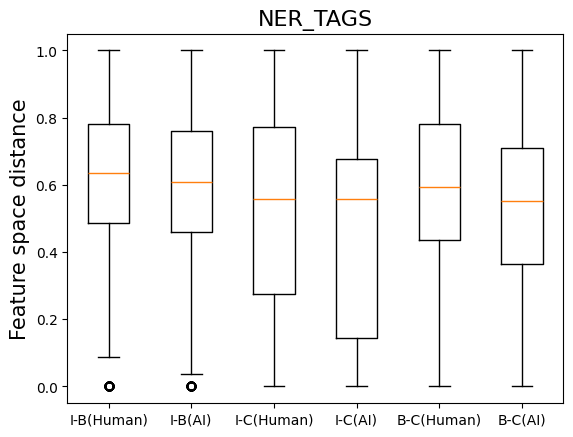

In [ ]:
test_two_way_anova(H_I_B, H_I_C, H_B_C, AI_I_B, AI_I_C, AI_B_C, "NER_TAGS")

### Stopwords

In [ ]:

mask = (orig_df['intro_stopwords'] != '{}') & (orig_df['body_stopwords'] != '{}') & (orig_df['conclusion_stopwords'] != '{}')
df = orig_df[mask]
def get_percentage_of_stopwords_count(s,wc):
  D = ast.literal_eval(s)
  counter = Counter(D)
  total_sum = sum(counter.values())
  return round(total_sum*100/wc,2)

intro_col = 'intro_stopwords'
body_col = 'body_stopwords'
conclusion_col = 'conclusion_stopwords'
df['intro_stopwords_frac'] = df.apply(lambda row: get_percentage_of_stopwords_count(row[intro_col], row['intro_word_count']), axis=1)
df['body_stopwords_frac'] = df.apply(lambda row: get_percentage_of_stopwords_count(row[body_col], row['body_word_count']), axis=1)
df['conclusion_stopwords_frac'] = df.apply(lambda row: get_percentage_of_stopwords_count(row[conclusion_col], row['conclusion_word_count']), axis=1)

In [ ]:
D = {}
for  index,row in df.iterrows():
  d = ast.literal_eval(row['intro_stopwords'])
  for k in d:
    if k not in D:
      D[k] = d[k]
    else:
      D[k] += d[k]
  d = ast.literal_eval(row['body_stopwords'])
  for k in d:
    if k not in D:
      D[k] = d[k]
    else:
      D[k] += d[k]
  d = ast.literal_eval(row['conclusion_stopwords'])
  for k in d:
    if k not in D:
      D[k] = d[k]
    else:
      D[k] += d[k]
  # print(d)
  # break

In [ ]:
total_counts = Counter(D)
K = 20
top_K_values = total_counts.most_common(K)
TOP_STOPWORDS = [item for item, _ in top_K_values]
stopwords_tags = TOP_STOPWORDS
print(stopwords_tags)

['the', 'and', 'to', 'of', 'a', 'in', 'that', 'is', 'it', 'for', 'i', 'on', 'can', 'are', 'be', 'this', 'you', 'not', 'have', "'s"]


In [ ]:
def get_percentage_of_top_stopwords(s,wc):
  D = ast.literal_eval(s)
  top_D = {}
  for d in stopwords_tags:
    if d not in D: top_D[d] = 0
    else: top_D[d] = round(D[d]*100/wc,2)
  return top_D

intro_col = 'intro_stopwords'
body_col = 'body_stopwords'
conclusion_col = 'conclusion_stopwords'
df[intro_col] = df.apply(lambda row: get_percentage_of_top_stopwords(row[intro_col], row['intro_word_count']), axis=1)
df[body_col] = df.apply(lambda row: get_percentage_of_top_stopwords(row[body_col], row['body_word_count']), axis=1)
df[conclusion_col] = df.apply(lambda row: get_percentage_of_top_stopwords(row[conclusion_col], row['conclusion_word_count']), axis=1)

In [ ]:
h_intro_emd = []
h_body_emd = []
h_conclusion_emd = []
ai_intro_emd = []
ai_body_emd = []
ai_conclusion_emd = []
human_rows = df[df['source'] == 'human']

for i, row in human_rows.iterrows():
  try:
    # Get all rows with the current key but a different source
    key = row['key']
    other_sources = df[(df['key'] == key) & (df['source'] != 'human')]
    # print(other_sources.shape)
    # Sample a row from the other_sources DataFrame
    sampled_row = other_sources.sample(n=1).iloc[0]

    h_intro_emd.append(list(row[intro_col].values())[:len(pos_tags)])
    h_body_emd.append(list(row[body_col].values())[:len(pos_tags)])
    h_conclusion_emd.append(list(row[conclusion_col].values())[:len(pos_tags)])
    # print(h_intro_emd.shape, h_body_emd.shape, h_conclusion_emd.shape)



    ai_intro_emd.append(list(sampled_row[intro_col].values())[:len(pos_tags)])
    ai_body_emd.append(list(sampled_row[body_col].values())[:len(pos_tags)])
    ai_conclusion_emd.append(list(sampled_row[conclusion_col].values())[:len(pos_tags)])

  except:
    continue

I  = []
B = []
C = []
for i in range(len(h_intro_emd)):
  I.append(calculate_distance(h_intro_emd[i], ai_intro_emd[i]))
  B.append(calculate_distance(h_body_emd[i], ai_body_emd[i]))
  C.append(calculate_distance(h_conclusion_emd[i], ai_conclusion_emd[i]))

f_value:  632.9258868109353
p_value:  4.783822670394448e-246
I-B:  WilcoxonResult(statistic=1307619.0, pvalue=6.449744823343694e-196)
I-C:  WilcoxonResult(statistic=911106.0, pvalue=1.2114460388473668e-23)
B-C:  WilcoxonResult(statistic=195708.0, pvalue=1.0)


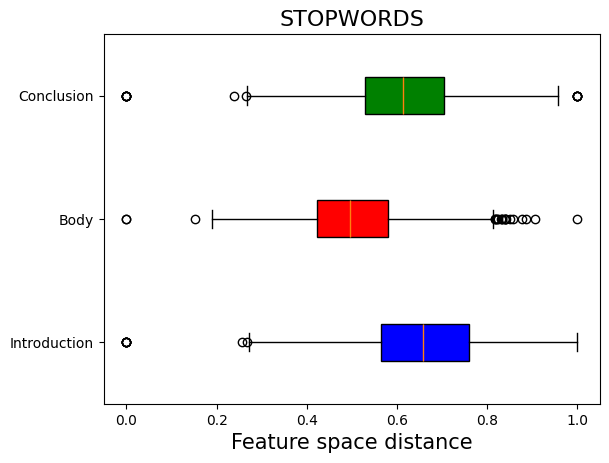

In [ ]:
test_one_way_anova(I, B, C, "STOPWORDS")

In [ ]:
H_I_B, H_I_C, H_B_C, AI_I_B, AI_I_C, AI_B_C = [], [], [], [], [], []
for i in range(len(h_intro_emd)):
  H_I_B.append(calculate_distance(h_intro_emd[i], h_body_emd[i]))
  H_I_C.append(calculate_distance(h_intro_emd[i], h_conclusion_emd[i]))
  H_B_C.append(calculate_distance(h_body_emd[i], h_conclusion_emd[i]))
  AI_I_B.append(calculate_distance(ai_intro_emd[i], ai_body_emd[i]))
  AI_I_C.append(calculate_distance(ai_intro_emd[i], ai_conclusion_emd[i]))
  AI_B_C.append(calculate_distance(ai_body_emd[i], ai_conclusion_emd[i]))


                    sum_sq       df           F        PR(>F)
Segment           8.485071      2.0  223.069739  1.575845e-95
Source            6.196634      1.0  325.814928  1.039094e-71
Segment:Source    1.390107      2.0   36.545460  1.533104e-16
Residual        192.394947  10116.0         NaN           NaN
I-B:  WilcoxonResult(statistic=794194.0, pvalue=1.963956727714957e-05)
I-C:  WilcoxonResult(statistic=992339.0, pvalue=6.459068311207181e-45)
B-C:  WilcoxonResult(statistic=963980.0, pvalue=1.1079477460218825e-36)


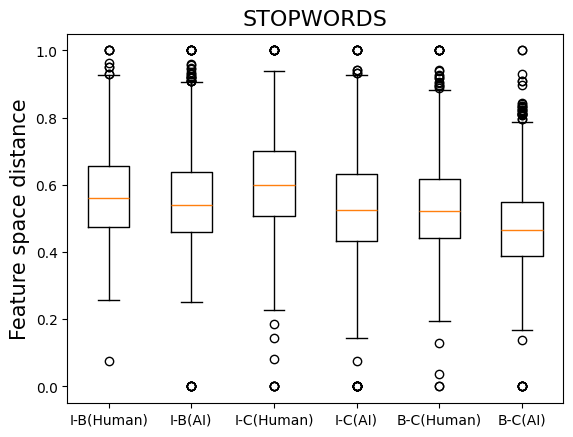

In [ ]:
test_two_way_anova(H_I_B, H_I_C, H_B_C, AI_I_B, AI_I_C, AI_B_C, "STOPWORDS")

### New Section